In [1]:
%matplotlib inline
import math
import re
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import re

from collections import defaultdict
from scipy.stats import pearsonr
import pandas as pd
from IPython.display import display


In [2]:
DATA_DIR = '.'

DATASETS = {
    "heart_diagnoses_1": "heart_diagnoses_1.csv",
    "laboratory_events_codes_2": "laboratory_events_codes_2.csv",
    "microbiology_events_codes_3": "microbiology_events_codes_3.csv",
    "procedure_code_4": "procedure_code_4.csv",
}
name = "heart_diagnoses_1"


In [3]:
df = pd.read_csv(f"{DATA_DIR}/{DATASETS['heart_diagnoses_1']}", index_col=False)

df.columns

Index(['note_id', 'subject_id', 'hadm_id', 'note_type', 'note_seq',
       'charttime', 'storetime', 'HPI', 'physical_exam', 'chief_complaint',
       'invasions', 'X-ray', 'CT', 'Ultrasound', 'CATH', 'ECG', 'MRI',
       'reports', 'subject_id_dx', 'icd_code', 'long_title', 'gender', 'age',
       'anchor_year', 'dod'],
      dtype='object')

# INspections

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4864 entries, 0 to 4863
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   note_id          4864 non-null   object 
 1   subject_id       4864 non-null   int64  
 2   hadm_id          4864 non-null   int64  
 3   note_type        4864 non-null   object 
 4   note_seq         4864 non-null   int64  
 5   charttime        4864 non-null   object 
 6   storetime        4864 non-null   object 
 7   HPI              4864 non-null   object 
 8   physical_exam    4864 non-null   object 
 9   chief_complaint  4852 non-null   object 
 10  invasions        4852 non-null   object 
 11  X-ray            4864 non-null   object 
 12  CT               4864 non-null   object 
 13  Ultrasound       4864 non-null   object 
 14  CATH             4864 non-null   object 
 15  ECG              4864 non-null   object 
 16  MRI              4864 non-null   object 
 17  reports       

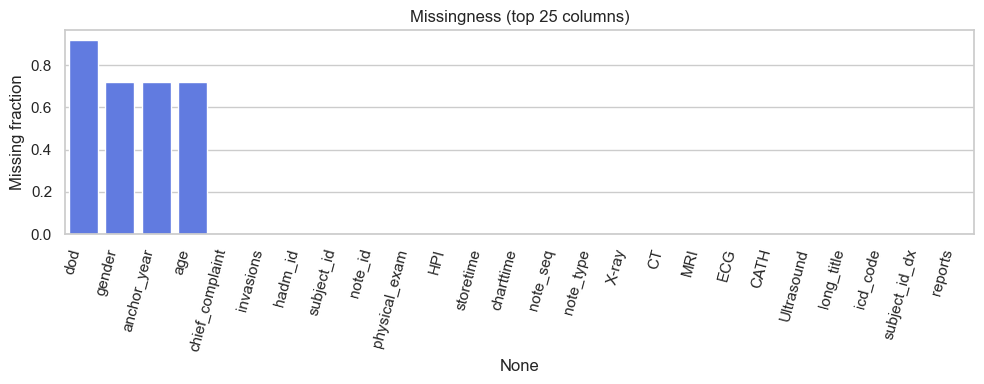

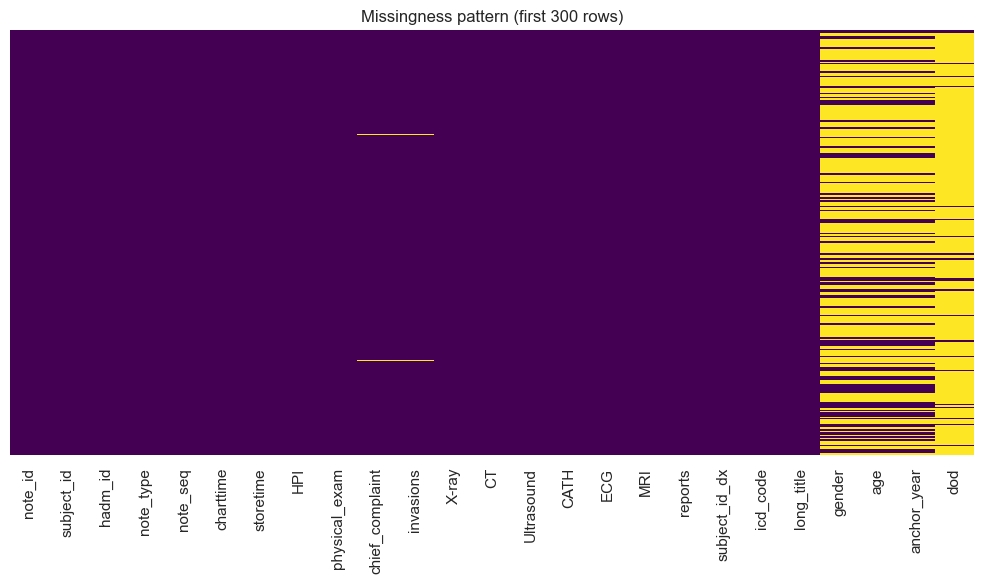

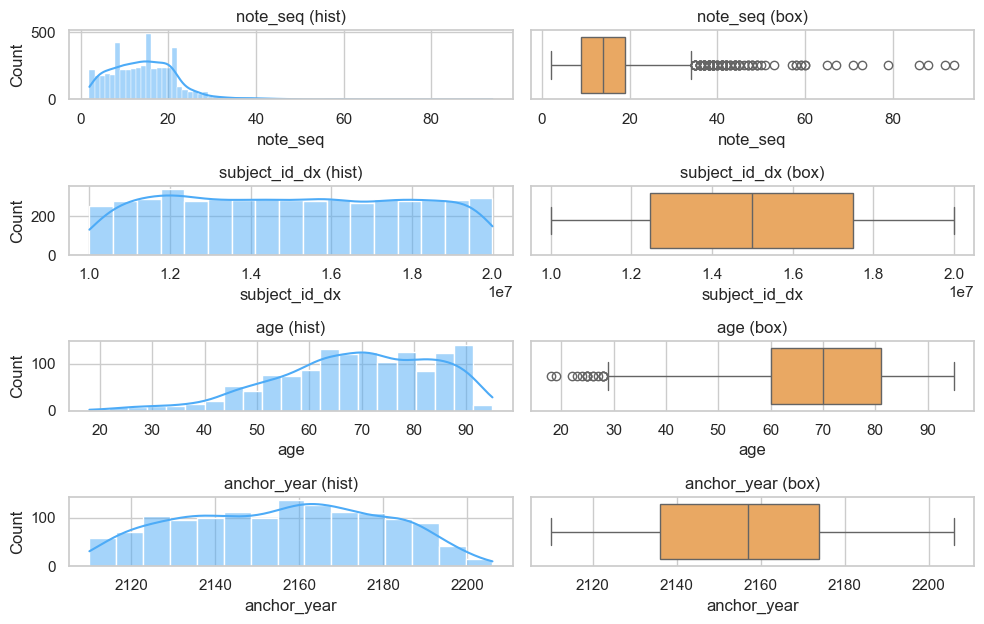

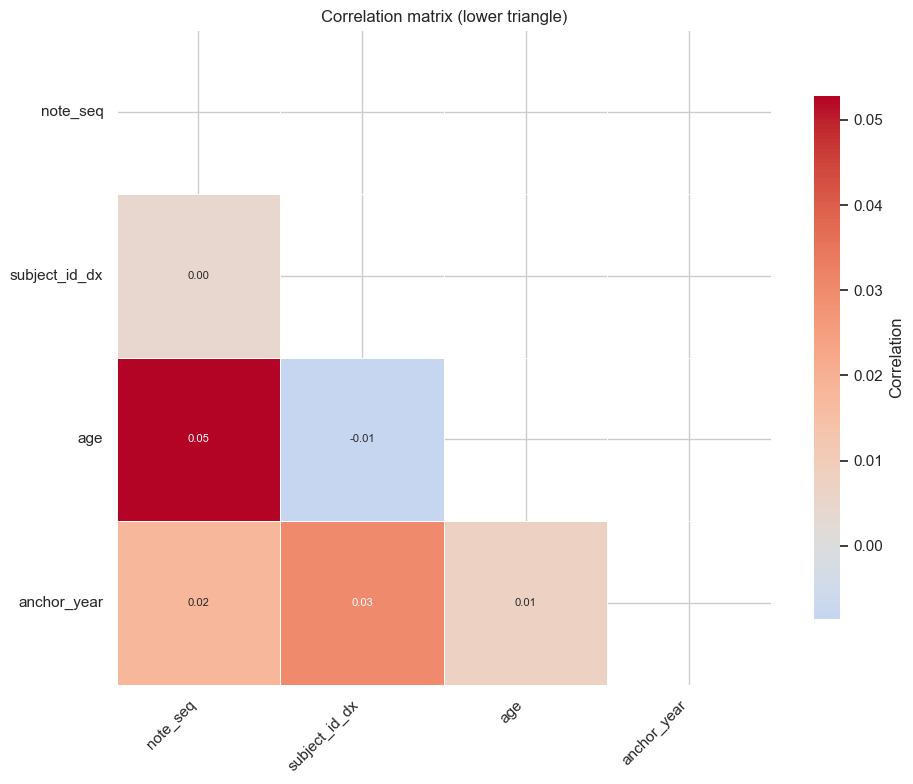

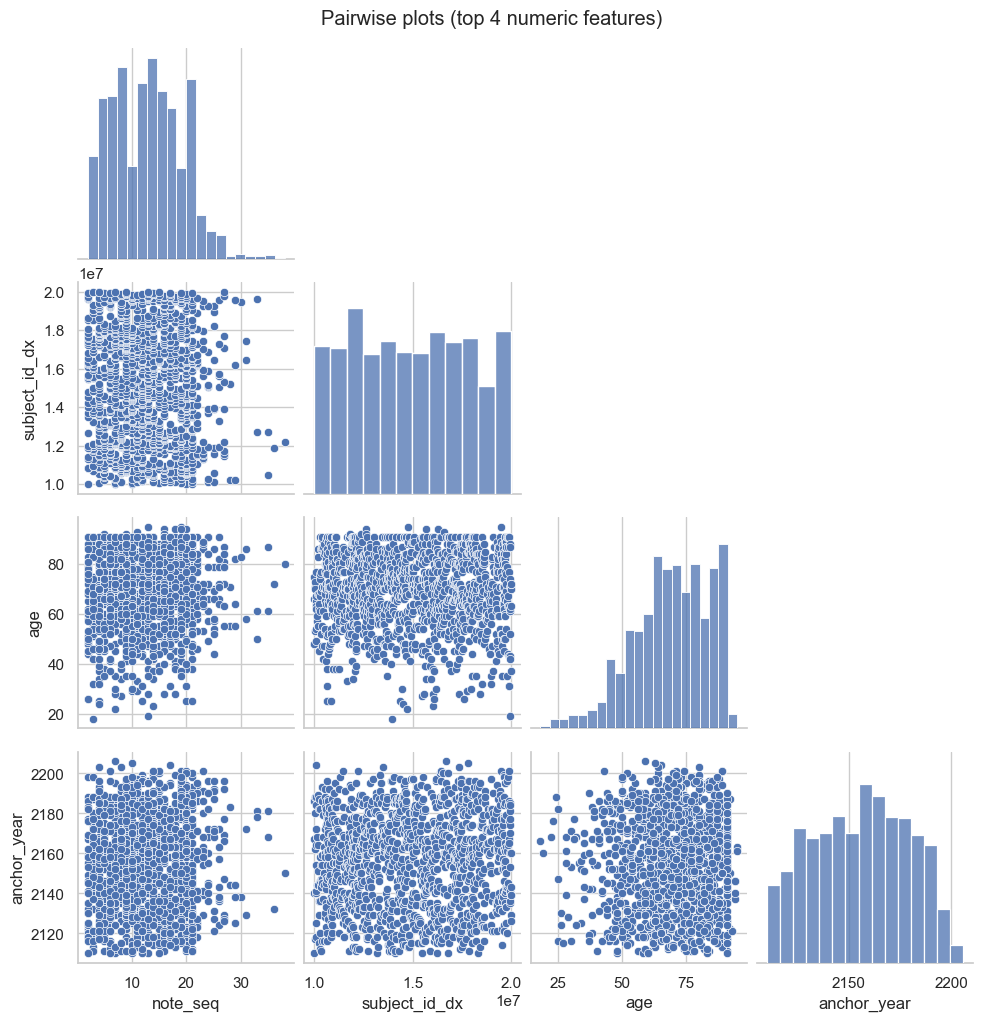

In [5]:
sns.set_theme(style="whitegrid", context="notebook")

def is_available(name):
    return name in globals()

# Choose table
table = df

# 1) Missingness bar + heatmap (top 25 cols)
mis = table.isna().mean().sort_values(ascending=False)
plt.figure(figsize=(10,4))
sns.barplot(x=mis.head(25).index, y=mis.head(25).values, color="#4c6ef5")
plt.xticks(rotation=75, ha="right")
plt.ylabel("Missing fraction")
plt.title("Missingness (top 25 columns)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(table.head(300).isna(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("Missingness pattern (first 300 rows)")
plt.tight_layout()
plt.show()

# 2) Numeric distributions: hist + box (stacked)
num_cols = [c for c in table.select_dtypes(include=[np.number]).columns if c not in ["subject_id","hadm_id"]]
n_show = min(len(num_cols), 12)
fig, axes = plt.subplots(n_show, 2, figsize=(10, 1.6*n_show))
for i, col in enumerate(num_cols[:n_show]):
    sns.histplot(table[col].dropna(), ax=axes[i,0], kde=True, color="#4dabf7")
    axes[i,0].set_title(f"{col} (hist)")
    sns.boxplot(x=table[col], ax=axes[i,1], color="#ffa94d")
    axes[i,1].set_title(f"{col} (box)")
plt.tight_layout()
plt.show()

# 3) Correlation: lower triangle heatmap
if len(num_cols) > 1:
    corr = table[num_cols].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, mask=mask, annot=True, fmt=".2f",
                cmap="coolwarm", center=0, square=True,
                linewidths=0.5, annot_kws={"size":8},
                cbar_kws={"label":"Correlation","shrink":0.8})
    plt.title("Correlation matrix (lower triangle)")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# 4) Pairwise glance (top 4 numeric cols)
top4 = num_cols[:4]
if len(top4) >= 2:
    sns.pairplot(table[top4].dropna(), corner=True, diag_kind="hist")
    plt.suptitle("Pairwise plots (top 4 numeric features)", y=1.02)
    plt.show()

## A

In [6]:
df.head(10)

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,HPI,physical_exam,chief_complaint,...,ECG,MRI,reports,subject_id_dx,icd_code,long_title,gender,age,anchor_year,dod
0,10000980-DS-20,10000980,29654838,DS,20,2188-01-06 03:00:00,2188-01-07 23:49:00,":\n___ yo woman with h/o hypertension, hyperli...","Admission exam:\nGENERAL- Oriented x3. Mood, a...",\nShortness of breath\n \n,...,['___ 7:56:06 ___ \nBaseline artifact. Sinus...,[],Sinus bradycardia with sinus arrhythmia | Prol...,10000980,I50,Heart failure,F,75.0,2186.0,2193-08-26
1,10000980-DS-21,10000980,26913865,DS,21,2189-07-04 03:00:00,2189-07-04 22:50:00,":\nThis is a ___ M with history of diabetes, d...",ADMISSION EXAM:\nGeneral- appears comfortable...,\ndyspnea\n \n,...,[],[],Sinus bradycardia with sinus arrhythmia | Prol...,10000980,I21,Acute myocardial infarction,F,75.0,2186.0,2193-08-26
2,10002013-DS-8,10002013,24760295,DS,8,2160-07-13 03:00:00,2160-07-15 16:59:00,":\n___ w/ PMH of CAD s/p PCI x3, s/p off-pump ...",Admission:\nVS- T 99.4 BP 157/88 HR 118 RR 24 ...,\nchest pain\n \n,...,['on admission- Sinus tachycardia. Extensive S...,[],Sinus tachycardia | Extensive ST-T changes may...,10002013,I21,Acute myocardial infarction,NaN,NaN,NaN,NaN
3,10002155-DS-8,10002155,23822395,DS,8,2129-08-19 03:00:00,2129-08-20 15:29:00,:\n___ is a ___ yo female with a past medical ...,"GENERAL: WDWN in NAD. Oriented x3. Mood, affec...",\nchest pressure\n \n,...,[': new LBBB with STE in V1 -V3 & V5 that in ...,[],*** CONSIDER ACUTE ST ELEVATION MI *** | Sinus...,10002155,I21,Acute myocardial infarction,NaN,NaN,NaN,NaN
4,10004457-DS-10,10004457,28723315,DS,10,2141-08-14 03:00:00,2141-08-14 21:50:00,:\nMr. ___ is a ___ with a hx of CAD (s/p DES ...,On Admission:\nVS- 97.8 157/64 101 18 98% RA \...,"\nAbnormal Stress Test, New AI\n \n",...,['(see exercise report for details). Resting s...,[],Sinus rhythm | Normal ECG,10004457,I35,Nonrheumatic aortic valve disorders,M,66.0,2140.0,NaN
5,10007058-DS-2,10007058,22954658,DS,2,2167-11-12 03:00:00,2167-11-13 14:39:00,:\nMr. ___ is a healthy ___ year-old male who ...,ADMISSION PHYSICAL EXAM:\n====================...,\nChest pain\n \n,...,"['(___): \nNSR, nl axis, no ST changes']",[],"Age not entered, assumed to be 50 years old f...",10007058,I21,Acute myocardial infarction,M,48.0,2167.0,NaN
6,10010424-DS-9,10010424,28388172,DS,9,2164-05-31 03:00:00,2164-06-24 13:20:00,:\nThis is a ___ year old male in his USOH wit...,VS: T=AF BP=127/69 HR= 72 RR=20 O2 sat= 98 \n...,\nDOE and Chest pressure\n \n,...,[],[],--- Warning: Data quality may affect interpret...,10010424,I25,Chronic ischemic heart disease,NaN,NaN,NaN,NaN
7,10012343-DS-3,10012343,27658045,DS,3,2146-03-22 03:00:00,2146-03-23 16:42:00,:\n___ F with h/o gastric bypass surgery prese...,VS: 97.9 104/70 60 16 99% on 2L \nGENERAL: NA...,\nchest pain\n \n,...,"[': NSR @58, LAD, Q in III, biphasic TW in V3-...",[],Sinus bradycardia with PVC(s) | Prolonged QT i...,10012343,I21,Acute myocardial infarction,NaN,NaN,NaN,NaN
8,10013569-DS-9,10013569,22891949,DS,9,2167-11-15 03:00:00,2167-11-18 21:36:00,:\n___ w/ PMH significant for CHF (LVEF 30% in...,"Admission:\n97.3, 145/79, 76, 20, 96% 2L nc. W...",\nDyspnea\n \n,...,[': Atrial sensing and ventricular pacing whic...,[],Ventricular pacing | Pacemaker rhythm - no fur...,10013569,I50,Heart failure,NaN,NaN,NaN,NaN
9,10014651-DS-4,10014651,20051301,DS,4,2138-05-01 03:00:00,2138-05-03 19:23:00,":\n___ is a ___ year old woman with HTN, HLD, ...",=======================\nADMISSION PHYSICAL EX...,"\nLeg swelling, dyspnea on exertion, orthopnea...",...,[],['I\nFINDINGS\n- Left Atrium ___ Veins (PV): M...,Sinus tachycardia. | Leftward axis | Inferior ...,10014651,I50,Heart failure,NaN,NaN,NaN,NaN


In [7]:
df.tail(10)


,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,HPI,physical_exam,chief_complaint,...,ECG,MRI,reports,subject_id_dx,icd_code,long_title,gender,age,anchor_year,dod
4854,10473769-DS-7,19998591,28160486,DS,7,2154-08-16 03:00:00,2154-08-16 18:22:00,":\n___ y/o woman with no known CAD, hx of htn,...",GENERAL: Anxious appearing elderly woman with ...,\nChest Pain\n \n,...,"[': \n___: NSR at ___hanges, small Q waves in...",[],Sinus rhythm. | ST junctional depression is no...,10473769,I21,Acute myocardial infarction,NaN,NaN,NaN,NaN
4855,17451560-DS-31,19998592,26305582,DS,31,2132-04-13 03:00:00,2132-04-14 01:52:00,":\n___ with CHFpEF, hypertension, paroxysmal a...",ADMISSION PHYSICAL EXAM: \nVS: 97.7 151/92 ...,\nBradycardia\n \n,...,['(___):\nno p-wave activity with regular vent...,[],Sinus bradycardia | Left axis deviation - ante...,17451560,I49,Other cardiac arrhythmias,NaN,NaN,NaN,NaN
4856,11984732-DS-17,19998593,20724148,DS,17,2119-02-26 03:00:00,2119-02-27 11:13:00,":\n___ w/PMHx significant for ___, CAD s/p CAB...","ADMISSION PHYSICAL EXAM:\nVS: T: 98.6, BP: 116...","\nSOB, fatigue\n \n",...,['___: Baseline artifact. Probable sinus or ec...,[],Possible ectopic atrial bradycardia | Right bu...,11984732,I44,Atrioventricular and left bundle-branch block,NaN,NaN,NaN,NaN
4857,10232096-DS-10,19998594,21324713,DS,10,2126-11-23 03:00:00,2126-11-24 11:04:00,:\n___ YO M w critical AS and CRI who presente...,ADMISSION\nVS: 95.8 102/58 72 20 99%2L 68 kg ...,\nchest pain \n \n,...,[],[],Sinus rhythm with 1st degree A-V block | Left ...,10232096,I35,Nonrheumatic aortic valve disorders,NaN,NaN,NaN,NaN
4858,12801290-DS-9,19998595,22746992,DS,9,2149-08-21 03:00:00,2149-08-23 15:40:00,:\n___ yo M with hx of ischemic cardiomyopathy...,admission exam \nVS: T: 96.8 BP: 111/92 HR: 64...,\nweakness\n \n,...,['___\nSinus rhythm. Baseline artifact makes i...,[],Possible ectopic atrial rhythm | Left axis dev...,12801290,I50,Heart failure,NaN,NaN,NaN,NaN
4859,13690559-DS-19,19998596,24860241,DS,19,2180-01-24 03:00:00,2180-01-24 20:12:00,:\nMs ___ is a ___ year old woman with carotid...,ADMISSION EXAM\n=====================\nVITALS:...,\nRight shoulder pain\n \n,...,['___:\nAtrial flutter with 4:1 conduction and...,[],Possible atrial flutter with rapid ventricular...,13690559,I48,Atrial fibrillation and flutter,NaN,NaN,NaN,NaN
4860,14997789-DS-12,19998597,23720781,DS,12,2131-10-11 03:00:00,2131-10-11 16:17:00,:\nMs. ___ is a ___ woman with renal cell carc...,Physical Exam:\nVS: T: T 95.7 bp 102/60 HR 1...,\nDyspnea\n \n,...,[],[],Sinus tachycardia. | Possible anterior infarct...,14997789,I31,Other diseases of pericardium,NaN,NaN,NaN,NaN
4861,10754991-DS-13,19998598,26940500,DS,13,2135-04-03 03:00:00,2135-04-05 00:12:00,":\n___ T2DM, fibromyalgia, GERD, hypothyroidis...",=================\nADMISSION EXAM:\n==========...,\nPalpitations\n \n,...,['(___): Narrow complex tachycardia. Supravent...,[],Supraventricular tachycardia | Sinus rhythm | ...,10754991,I47,Paroxysmal tachycardia,NaN,NaN,NaN,NaN
4862,17922874-DS-8,19998599,20343031,DS,8,2158-05-23 03:00:00,2158-05-23 20:55:00,":\n___ with H/O of type 2 diabetes mellitus, h...","General: Middle aged Caucasian man in NAD, com...","\nAbdominal pain, nausea, vomiting, and diarrh...",...,['Study Date of ___ 7:51:52 ___\nSinus rhythm ...,[],*** CONSIDER ACUTE ST ELEVATION MI *** | Sinus...,17922874,I30,Acute pericarditis,NaN,NaN,NaN,NaN
4863,16877397-DS-10,19998600,21593455,DS,10,2155-11-27 03:00:00,2155-12-07 18:35:00,:\nThe patient is an ___ year old male with a ...,"On admission\nVS: T 97.7, BP 134/73, HR 73, RR...",\nchest pain and dyspnea\n \n,...,[],[],Sinus rhythm | Leftward axis | Lateral ST elev...,16877397,I35,Nonrheumatic aortic valve disorders,NaN,NaN,NaN,NaN


## B

In [8]:
df.columns

Index(['note_id', 'subject_id', 'hadm_id', 'note_type', 'note_seq',
       'charttime', 'storetime', 'HPI', 'physical_exam', 'chief_complaint',
       'invasions', 'X-ray', 'CT', 'Ultrasound', 'CATH', 'ECG', 'MRI',
       'reports', 'subject_id_dx', 'icd_code', 'long_title', 'gender', 'age',
       'anchor_year', 'dod'],
      dtype='object')

In [9]:
df[df.columns[:10]].head(10)

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,HPI,physical_exam,chief_complaint
0,10000980-DS-20,10000980,29654838,DS,20,2188-01-06 03:00:00,2188-01-07 23:49:00,":\n___ yo woman with h/o hypertension, hyperli...","Admission exam:\nGENERAL- Oriented x3. Mood, a...",\nShortness of breath\n \n
1,10000980-DS-21,10000980,26913865,DS,21,2189-07-04 03:00:00,2189-07-04 22:50:00,":\nThis is a ___ M with history of diabetes, d...",ADMISSION EXAM:\nGeneral- appears comfortable...,\ndyspnea\n \n
2,10002013-DS-8,10002013,24760295,DS,8,2160-07-13 03:00:00,2160-07-15 16:59:00,":\n___ w/ PMH of CAD s/p PCI x3, s/p off-pump ...",Admission:\nVS- T 99.4 BP 157/88 HR 118 RR 24 ...,\nchest pain\n \n
3,10002155-DS-8,10002155,23822395,DS,8,2129-08-19 03:00:00,2129-08-20 15:29:00,:\n___ is a ___ yo female with a past medical ...,"GENERAL: WDWN in NAD. Oriented x3. Mood, affec...",\nchest pressure\n \n
4,10004457-DS-10,10004457,28723315,DS,10,2141-08-14 03:00:00,2141-08-14 21:50:00,:\nMr. ___ is a ___ with a hx of CAD (s/p DES ...,On Admission:\nVS- 97.8 157/64 101 18 98% RA \...,"\nAbnormal Stress Test, New AI\n \n"
5,10007058-DS-2,10007058,22954658,DS,2,2167-11-12 03:00:00,2167-11-13 14:39:00,:\nMr. ___ is a healthy ___ year-old male who ...,ADMISSION PHYSICAL EXAM:\n====================...,\nChest pain\n \n
6,10010424-DS-9,10010424,28388172,DS,9,2164-05-31 03:00:00,2164-06-24 13:20:00,:\nThis is a ___ year old male in his USOH wit...,VS: T=AF BP=127/69 HR= 72 RR=20 O2 sat= 98 \n...,\nDOE and Chest pressure\n \n
7,10012343-DS-3,10012343,27658045,DS,3,2146-03-22 03:00:00,2146-03-23 16:42:00,:\n___ F with h/o gastric bypass surgery prese...,VS: 97.9 104/70 60 16 99% on 2L \nGENERAL: NA...,\nchest pain\n \n
8,10013569-DS-9,10013569,22891949,DS,9,2167-11-15 03:00:00,2167-11-18 21:36:00,:\n___ w/ PMH significant for CHF (LVEF 30% in...,"Admission:\n97.3, 145/79, 76, 20, 96% 2L nc. W...",\nDyspnea\n \n
9,10014651-DS-4,10014651,20051301,DS,4,2138-05-01 03:00:00,2138-05-03 19:23:00,":\n___ is a ___ year old woman with HTN, HLD, ...",=======================\nADMISSION PHYSICAL EX...,"\nLeg swelling, dyspnea on exertion, orthopnea..."


In [10]:
df[df.columns[10:]].head(10)

,invasions,X-ray,CT,Ultrasound,CATH,ECG,MRI,reports,subject_id_dx,icd_code,long_title,gender,age,anchor_year,dod
0,\nNone\n \n,"['___:', 'views of the chest demonstrate low l...",[],['___:\nThe left atrium is mildly dilated. The...,[],['___ 7:56:06 ___ \nBaseline artifact. Sinus...,[],Sinus bradycardia with sinus arrhythmia | Prol...,10000980,I50,Heart failure,F,75.0,2186.0,2193-08-26
1,\nCardiac catheterization ___\n\n \n,[': ___\nRight upper lobe pneumonia or mass. ...,['CHEST: ___\n1. Diffuse confluent ground-gla...,[': ___\nThe left atrium is elongated. There i...,[': ___\n1. Selective coronary angiography of ...,[],[],Sinus bradycardia with sinus arrhythmia | Prol...,10000980,I21,Acute myocardial infarction,F,75.0,2186.0,2193-08-26
2,\ncardiac catheterization\n\n \n,['___- New moderate left pleural effusion with...,['Chest ___. No CT evidence for pulmonary emb...,[],['___. Selective coronary angiography of this ...,['on admission- Sinus tachycardia. Extensive S...,[],Sinus tachycardia | Extensive ST-T changes may...,10002013,I21,Acute myocardial infarction,NaN,NaN,NaN,NaN
3,\nCardiac cathetherization\n\n \n,[],"['anteriorly, no \ncrackles, wheezes or rhonch...",[],[': \nLMCA: 40% distal\nLAD: Occluded difficu...,[': new LBBB with STE in V1 -V3 & V5 that in ...,[],*** CONSIDER ACUTE ST ELEVATION MI *** | Sinus...,10002155,I21,Acute myocardial infarction,NaN,NaN,NaN,NaN
4,\nNone\n \n,[],['/MR or TEE is suggested to \nevaluate for po...,[': \nAnginal type symptoms with borderline i...,[],['(see exercise report for details). Resting s...,[],Sinus rhythm | Normal ECG,10004457,I35,Nonrheumatic aortic valve disorders,M,66.0,2140.0,NaN
5,\n___ - Percutaneous coronary intervention wit...,['___:\nLungs are fully expanded and clear. C...,['___:\n1. Infrarenal abdominal aortic aneury...,['(___): \nThe left atrium is mildly dilated....,['(___): RCA occluded with thrombus in mid- t...,"['(___): \nNSR, nl axis, no ST changes']",[],"Age not entered, assumed to be 50 years old f...",10007058,I21,Acute myocardial infarction,M,48.0,2167.0,NaN
6,\nCardiac catheterization\n\n \n,[],"['anteriorly. No \ncrackles, wheezes or rhonch...",[':\nThe left atrium is mildly dilated. Left v...,"['COMMENTS: \n1.', '. \nNow with femoral...",[],[],--- Warning: Data quality may affect interpret...,10010424,I25,Chronic ischemic heart disease,NaN,NaN,NaN,NaN
7,\nCardiac catheterization with stending of the...,[],[],['(Complete) Done ___ at 8:25:18 AM The left a...,"['Study Date of ___ 1. Selective', ""of this ri...","[': NSR @58, LAD, Q in III, biphasic TW in V3-...",[],Sinus bradycardia with PVC(s) | Prolonged QT i...,10012343,I21,Acute myocardial infarction,NaN,NaN,NaN,NaN
8,\nnone\n\n \n,[': IMPRESSION: Enlarged cardiac silhouette ...,[],[': There is mild symmetric left ventricular h...,[],[': Atrial sensing and ventricular pacing whic...,[],Ventricular pacing | Pacemaker rhythm - no fur...,10013569,I50,Heart failure,NaN,NaN,NaN,NaN
9,\nNone\n(Left Heart Catheterization at ___\n \n,[],['CHEST WITHOUT CONTRAST\n\nFINDINGS: \nTHORAC...,['The left atrial volume index is moderately i...,[],[],['I\nFINDINGS\n- Left Atrium ___ Veins (PV): M...,Sinus tachycardia. | Leftward axis | Inferior ...,10014651,I50,Heart failure,NaN,NaN,NaN,NaN


## C

In [11]:
df.columns

Index(['note_id', 'subject_id', 'hadm_id', 'note_type', 'note_seq',
       'charttime', 'storetime', 'HPI', 'physical_exam', 'chief_complaint',
       'invasions', 'X-ray', 'CT', 'Ultrasound', 'CATH', 'ECG', 'MRI',
       'reports', 'subject_id_dx', 'icd_code', 'long_title', 'gender', 'age',
       'anchor_year', 'dod'],
      dtype='object')

In [12]:
df["note_type"].unique()

array(['DS'], dtype=object)

In [13]:
nan_row = df[df['subject_id'] == 19998591]
nan_row

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,HPI,physical_exam,chief_complaint,...,ECG,MRI,reports,subject_id_dx,icd_code,long_title,gender,age,anchor_year,dod
4854,10473769-DS-7,19998591,28160486,DS,7,2154-08-16 03:00:00,2154-08-16 18:22:00,":\n___ y/o woman with no known CAD, hx of htn,...",GENERAL: Anxious appearing elderly woman with ...,\nChest Pain\n \n,...,"[': \n___: NSR at ___hanges, small Q waves in...",[],Sinus rhythm. | ST junctional depression is no...,10473769,I21,Acute myocardial infarction,NaN,NaN,NaN,NaN


In [14]:
nan_row = df[df['subject_id'] == 19998591]
nan_row

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,HPI,physical_exam,chief_complaint,...,ECG,MRI,reports,subject_id_dx,icd_code,long_title,gender,age,anchor_year,dod
4854,10473769-DS-7,19998591,28160486,DS,7,2154-08-16 03:00:00,2154-08-16 18:22:00,":\n___ y/o woman with no known CAD, hx of htn,...",GENERAL: Anxious appearing elderly woman with ...,\nChest Pain\n \n,...,"[': \n___: NSR at ___hanges, small Q waves in...",[],Sinus rhythm. | ST junctional depression is no...,10473769,I21,Acute myocardial infarction,NaN,NaN,NaN,NaN


# Data Understanding and Preprocessing, cleaning of DF1 - heart

In [15]:
df[['subject_id','hadm_id']].duplicated().any()

np.False_

In [16]:
df.groupby(['subject_id','hadm_id']).size().describe()

count    4864.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64

In [17]:
df.duplicated().sum()

np.int64(0)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4864 entries, 0 to 4863
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   note_id          4864 non-null   object 
 1   subject_id       4864 non-null   int64  
 2   hadm_id          4864 non-null   int64  
 3   note_type        4864 non-null   object 
 4   note_seq         4864 non-null   int64  
 5   charttime        4864 non-null   object 
 6   storetime        4864 non-null   object 
 7   HPI              4864 non-null   object 
 8   physical_exam    4864 non-null   object 
 9   chief_complaint  4852 non-null   object 
 10  invasions        4852 non-null   object 
 11  X-ray            4864 non-null   object 
 12  CT               4864 non-null   object 
 13  Ultrasound       4864 non-null   object 
 14  CATH             4864 non-null   object 
 15  ECG              4864 non-null   object 
 16  MRI              4864 non-null   object 
 17  reports       

## Findings

FIRST Findings:
- gender, age anchor_year and dod, invasions, chief_complaint with NANs => they are only is this df_slim_slim so we can handle them before merging
- some dtyppes need conversions: chart/storetimes, dod?
- age, acnor year, are int64 but with .0
- find and convert weird Nones: \nNone\n\n \nnone\n, [], 
['.']                                                                                                                   

## Check for wrong NaNs / non typical entries in each column

PLAN:
- first remove all "\n" and whitespaces
- then find occurences of wrong NaNS, and convert them to np.na

In [19]:
# Simple cleanup: remove newlines and extra whitespaces
def clean_whitespace(val):
    if isinstance(val, str):
        return val.replace('\n', '').replace('\r', '').strip()
    return val

for col in df.columns:
    df[col] = df[col].apply(clean_whitespace)

print("Whitespace cleanup completed")
df.info()

Whitespace cleanup completed
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4864 entries, 0 to 4863
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   note_id          4864 non-null   object 
 1   subject_id       4864 non-null   int64  
 2   hadm_id          4864 non-null   int64  
 3   note_type        4864 non-null   object 
 4   note_seq         4864 non-null   int64  
 5   charttime        4864 non-null   object 
 6   storetime        4864 non-null   object 
 7   HPI              4864 non-null   object 
 8   physical_exam    4864 non-null   object 
 9   chief_complaint  4852 non-null   object 
 10  invasions        4852 non-null   object 
 11  X-ray            4864 non-null   object 
 12  CT               4864 non-null   object 
 13  Ultrasound       4864 non-null   object 
 14  CATH             4864 non-null   object 
 15  ECG              4864 non-null   object 
 16  MRI              4864 non-null 

#### Find wrong NaNs

In [20]:
# compute and display value counts for every column (including NaNs)
value_counts_dict = {}

for col in df.columns:
    vc = df[col].value_counts(dropna=False)
    value_counts_dict[col] = vc
    print(f"\nColumn: '{col}'  | unique={vc.shape[0]}  | missing={df[col].isna().sum()}")
    # check the column's dtype (not the column name string)
    if not pd.api.types.is_numeric_dtype(df[col]) and col not in ["subject_id", "hadm_id", "note_id","charttime", "storetime", "dod"]:
        uniques = []
        for uni in df[col].unique():
            s = str(uni)
            if len(s) < 10:
                uniques.append(s)
        print(f"  sus Unique values: {uniques}")


Column: 'note_id'  | unique=4761  | missing=0

Column: 'subject_id'  | unique=4392  | missing=0

Column: 'hadm_id'  | unique=4761  | missing=0

Column: 'note_type'  | unique=1  | missing=0
  sus Unique values: ['DS']

Column: 'note_seq'  | unique=64  | missing=0

Column: 'charttime'  | unique=4466  | missing=0

Column: 'storetime'  | unique=4761  | missing=0

Column: 'HPI'  | unique=4760  | missing=0
  sus Unique values: []

Column: 'physical_exam'  | unique=4749  | missing=0
  sus Unique values: []

Column: 'chief_complaint'  | unique=1937  | missing=12
  sus Unique values: ['dyspnea', 'Dyspnea', 'Angina', 'lethargy', 'NSTEMI', 'tamponade', 'Syncope', 'Fall', 'SOB', 'VT storm', 'Vomiting', 'leg pain', 'nan', 'STEMI', 'DOE', 'hypoxia', 'Back pain', 'Weakness', 'angina', 'syncope', 'Fatigue', '___.', 'Cough', 'Hypoxia', '___ edema', 's/p STEMI', '___', 'hypoxemia', 'malaise', 'Fever', 'weakness', 'VTach', 'CP', 'Diarrhea', 'torsades', 'VF arrest', 'CHF', 's/p fall', 'SVT', 'Cough/SOB',

Findings - we found:
- TODO: ___ (e.g.: "['___']"s, ['___:']) is just anonymized, not a NaN IMO so we keep them?
- TODO: Also what about weird entries (e.g.:  "['or']", "xxxxxx", '***', )?

Safe wrong nans:
- to nan every non numeric col which is exactly "['-']", "['/']", "['.']", "[]", "['/']", "[':']", ...
- to np.NaN every non numeric, to_lower, column with ["none", "nan", "na", "N/A", "." ] in its entry

In [21]:
sus_entries = ['', '\nNone\n \n', 'none', 'None.', "None..", "na", 'nan', 'null', '[\'.\']', '[]', '.', 'NaT', 'n/a', 'na', 'not available',"pd.na", "<nat>", "['-']", "['/']", "['.']", "[]", "['/']", "[':']"]
for col in df.columns:
    print(f"Column '{col}'")
    for entry in sus_entries:
        if entry.strip():  # skip empty string for .isin() check
            mask = df[col].astype(str).str.lower().str.contains(entry.lower(), regex=False, na=False)
        else:
            mask = df[col].astype(str).str.strip() == ''
        
        cnt = mask.sum()
        if cnt > 0:
            print(f"  '{entry}': {cnt} occurrences")

Column 'note_id'


Column 'subject_id'
Column 'hadm_id'
Column 'note_type'
Column 'note_seq'
Column 'charttime'
Column 'storetime'
Column 'HPI'
  'none': 152 occurrences
  'None.': 8 occurrences
  'na': 4578 occurrences
  'nan': 229 occurrences
  '[]': 15 occurrences
  '.': 4862 occurrences
  'NaT': 755 occurrences
  'n/a': 25 occurrences
  'na': 4578 occurrences
  'not available': 18 occurrences
  '[]': 15 occurrences
Column 'physical_exam'
  'none': 126 occurrences
  'None.': 4 occurrences
  'None..': 1 occurrences
  'na': 3824 occurrences
  'nan': 19 occurrences
  '[]': 96 occurrences
  '.': 4626 occurrences
  'NaT': 591 occurrences
  'n/a': 3 occurrences
  'na': 3824 occurrences
  '[]': 96 occurrences
Column 'chief_complaint'
  'none': 2 occurrences
  'na': 249 occurrences
  'nan': 12 occurrences
  '.': 141 occurrences
  'NaT': 8 occurrences
  'n/a': 2 occurrences
  'na': 249 occurrences
Column 'invasions'
  '': 1 occurrences
  'none': 1487 occurrences
  'None.': 112 occurrences
  'None..': 1 occurre

### INspect weird entries
Findings - we found:
- TODO: ___ (e.g.: "['___']"s, ['___:']) is just anonymized, not a NaN IMO so we keep them?
- TODO: Also what about weird entries (e.g.:  "['or']", "xxxxxx", '***', )?

==> IMO remove bc we risk low quality data with wrong outliers

In [22]:
df.columns

Index(['note_id', 'subject_id', 'hadm_id', 'note_type', 'note_seq',
       'charttime', 'storetime', 'HPI', 'physical_exam', 'chief_complaint',
       'invasions', 'X-ray', 'CT', 'Ultrasound', 'CATH', 'ECG', 'MRI',
       'reports', 'subject_id_dx', 'icd_code', 'long_title', 'gender', 'age',
       'anchor_year', 'dod'],
      dtype='object')

In [23]:
weird_entries = ['or', 'xxxxxx', '***', '-', '/', '.', ':', "['.']", "['or']", "['xxxxxx']", "['***']", "['-']", "['/']", "[':']"]

# For each column, find and display rows with weird entries
for col in df.columns:
    if col in ['subject_id', 'hadm_id', 'note_id', 'charttime', 'storetime', 'dod']:
        continue
    
    str_col = df[col].astype(str).str.lower()
    
    for entry in weird_entries:
        # Check for exact bracket format or loose match
        mask = (str_col == f"['{entry}']") | (str_col == f"[{entry}]") | (str_col == entry)
        
        if mask.sum() > 0:
            print(f"\n{'='*80}")
            print(f"Column '{col}' | Entry: '{entry}' | Found: {mask.sum()} rows")
            print(f"{'='*80}")
            display(df[mask][[col, 'subject_id', 'hadm_id' , 'HPI', 'X-ray', 'CT', 'Ultrasound', 'CATH', 'ECG', 'MRI', 'icd_code', 'gender', 'age',]].head(10))


Column 'invasions' | Entry: 'xxxxxx' | Found: 1 rows


,invasions,subject_id,hadm_id,HPI,X-ray,CT,Ultrasound,CATH,ECG,MRI,icd_code,gender,age
4561,xxxxxx,19613127,29371998,":___ yo M with history of CABG ___ ___, DM, re...","[':\nCHEST, AP UPRIGHT: Lungs are clear. Cha...",[],['The left atrium is normal ___ size. No atria...,['Findings \nESTIMATED blood loss: <40 cc \n...,[],[],I21,NaN,NaN



Column 'invasions' | Entry: '***' | Found: 1 rows


,invasions,subject_id,hadm_id,HPI,X-ray,CT,Ultrasound,CATH,ECG,MRI,icd_code,gender,age
1444,***,13000446,21786912,:The patient is a ___ y/o man with a history o...,"[': Notable for RLL and LLL opacities', ""FINDI...",['CHEST W/O CONTRAST Study Date of ___ 1:30 __...,[],[],"[': Atrial Fibrillation, otherwise unchanged\n...",[],I50,NaN,NaN



Column 'invasions' | Entry: '.' | Found: 1 rows


,invasions,subject_id,hadm_id,HPI,X-ray,CT,Ultrasound,CATH,ECG,MRI,icd_code,gender,age
4123,.,18658392,20046985,":___ with a history of 3-vessel CABG in ___, C...",['___: Dictated report: No mediastinal widenin...,[],['___:'],['___: \nSelective coronary angiography in thi...,"[': NSR, 1mm STE in V2, subtle 0.25-0.5 STE in...",[],I21,NaN,NaN



Column 'CT' | Entry: 'or' | Found: 1 rows


,CT,subject_id,hadm_id,HPI,X-ray,CT,Ultrasound,CATH,ECG,MRI,icd_code,gender,age
3505,['or'],17390272,21500884,:Mr. ___ is a ___ y/o man with a PMH of stage ...,['___. \nApproved \nComparison to ___. ...,['or'],['The left atrium is normal ___ size. Left ven...,[],['___ ___. \nSinus rhythm with a normal infe...,[],I48,M,71.0



Column 'CT' | Entry: '.' | Found: 7 rows


,CT,subject_id,hadm_id,HPI,X-ray,CT,Ultrasound,CATH,ECG,MRI,icd_code,gender,age
508,['.'],11163793,20185129,:___ with aortic stenosis with worsening short...,[':\nSemi-upright portable radiograph of t...,['.'],[':\nThe left atrium is mildly dilated. The es...,[],[],[],I35,NaN,NaN
787,['.'],11726958,20977007,:___ male with a past medical history of hyper...,['(___)\nIMPRESSION: \nNo radiographic evid...,['.'],"[""(___):\nResults \nMeasurements \nNormal Ra...",[],[],[],I35,M,85.0
940,['.'],11997596,20044448,:admitted from the ED withasymptomatic hypoten...,['___:\nNear complete opacification of the rig...,['.'],['___\nThe estimated right atrial pressure is ...,[],[],[],I31,F,34.0
978,['.'],12075316,21685796,:HISTORY OF PRESENTING ILLNESS: Mr ___ is an _...,['___\nThe pacemaker leads terminate in the ex...,['.'],['___ (from ___):\n\n2. Moderately severe conc...,[],[],[],I50,NaN,NaN
1871,['.'],13933090,29951156,":___ yo male with h/o CAD s/p MI, CABG and PCI...",['on admission: Stable small right pleural eff...,['.'],['on ___: The left atrium is mildly dilated. ...,[],['on admission: Atrial fibrillation with rapid...,[],I21,NaN,NaN
4089,['.'],18579971,28956349,:Ms. ___ is a ___ year old female with CAD s/p...,['___ 5:14 ___\nSingle bedside AP examination ...,['.'],['___: The left atrium is mildly dilated. The ...,[],"['demonstrated NSR at 82 bpm. Nl axis, nl inte...",[],I50,NaN,NaN
4834,['.'],19998571,28956349,:Ms. ___ is a ___ year old female with CAD s/p...,['___ 5:14 ___\nSingle bedside AP examination ...,['.'],['___: The left atrium is mildly dilated. The ...,[],"['demonstrated NSR at 82 bpm. Nl axis, nl inte...",[],I50,NaN,NaN



Column 'CT' | Entry: ':' | Found: 1 rows


,CT,subject_id,hadm_id,HPI,X-ray,CT,Ultrasound,CATH,ECG,MRI,icd_code,gender,age
3698,[':'],17760700,25501463,:___ yo M with a history of asthma and seasona...,[],[':'],"[':\nNo evidence of right groin hematoma, pseu...","[':\n1.', ':\n1.', 'of this right dominant sys...",[],[],I21,NaN,NaN



Column 'CT' | Entry: '['.']' | Found: 7 rows


,CT,subject_id,hadm_id,HPI,X-ray,CT,Ultrasound,CATH,ECG,MRI,icd_code,gender,age
508,['.'],11163793,20185129,:___ with aortic stenosis with worsening short...,[':\nSemi-upright portable radiograph of t...,['.'],[':\nThe left atrium is mildly dilated. The es...,[],[],[],I35,NaN,NaN
787,['.'],11726958,20977007,:___ male with a past medical history of hyper...,['(___)\nIMPRESSION: \nNo radiographic evid...,['.'],"[""(___):\nResults \nMeasurements \nNormal Ra...",[],[],[],I35,M,85.0
940,['.'],11997596,20044448,:admitted from the ED withasymptomatic hypoten...,['___:\nNear complete opacification of the rig...,['.'],['___\nThe estimated right atrial pressure is ...,[],[],[],I31,F,34.0
978,['.'],12075316,21685796,:HISTORY OF PRESENTING ILLNESS: Mr ___ is an _...,['___\nThe pacemaker leads terminate in the ex...,['.'],['___ (from ___):\n\n2. Moderately severe conc...,[],[],[],I50,NaN,NaN
1871,['.'],13933090,29951156,":___ yo male with h/o CAD s/p MI, CABG and PCI...",['on admission: Stable small right pleural eff...,['.'],['on ___: The left atrium is mildly dilated. ...,[],['on admission: Atrial fibrillation with rapid...,[],I21,NaN,NaN
4089,['.'],18579971,28956349,:Ms. ___ is a ___ year old female with CAD s/p...,['___ 5:14 ___\nSingle bedside AP examination ...,['.'],['___: The left atrium is mildly dilated. The ...,[],"['demonstrated NSR at 82 bpm. Nl axis, nl inte...",[],I50,NaN,NaN
4834,['.'],19998571,28956349,:Ms. ___ is a ___ year old female with CAD s/p...,['___ 5:14 ___\nSingle bedside AP examination ...,['.'],['___: The left atrium is mildly dilated. The ...,[],"['demonstrated NSR at 82 bpm. Nl axis, nl inte...",[],I50,NaN,NaN



Column 'CT' | Entry: '['or']' | Found: 1 rows


,CT,subject_id,hadm_id,HPI,X-ray,CT,Ultrasound,CATH,ECG,MRI,icd_code,gender,age
3505,['or'],17390272,21500884,:Mr. ___ is a ___ y/o man with a PMH of stage ...,['___. \nApproved \nComparison to ___. ...,['or'],['The left atrium is normal ___ size. Left ven...,[],['___ ___. \nSinus rhythm with a normal infe...,[],I48,M,71.0



Column 'CT' | Entry: '[':']' | Found: 1 rows


,CT,subject_id,hadm_id,HPI,X-ray,CT,Ultrasound,CATH,ECG,MRI,icd_code,gender,age
3698,[':'],17760700,25501463,:___ yo M with a history of asthma and seasona...,[],[':'],"[':\nNo evidence of right groin hematoma, pseu...","[':\n1.', ':\n1.', 'of this right dominant sys...",[],[],I21,NaN,NaN



Column 'Ultrasound' | Entry: ':' | Found: 2 rows


,Ultrasound,subject_id,hadm_id,HPI,X-ray,CT,Ultrasound,CATH,ECG,MRI,icd_code,gender,age
1387,[':'],12881289,27293872,:Mr. ___ is a ___ gentleman with history of CH...,['S: Cardiomegaly is not changed. \nThere is \...,[],[':'],[],[':\nSinus bradycardia. Left anterior fascicul...,[],I50,NaN,NaN
3665,[':'],17689835,22966211,:___ year old male with a prior CAD history wh...,[],[': No significant carotid \nartery stenosis (...,[':'],[': 1. Selective coronary angiography in this ...,[],[],I25,NaN,NaN



Column 'Ultrasound' | Entry: '[':']' | Found: 2 rows


,Ultrasound,subject_id,hadm_id,HPI,X-ray,CT,Ultrasound,CATH,ECG,MRI,icd_code,gender,age
1387,[':'],12881289,27293872,:Mr. ___ is a ___ gentleman with history of CH...,['S: Cardiomegaly is not changed. \nThere is \...,[],[':'],[],[':\nSinus bradycardia. Left anterior fascicul...,[],I50,NaN,NaN
3665,[':'],17689835,22966211,:___ year old male with a prior CAD history wh...,[],[': No significant carotid \nartery stenosis (...,[':'],[': 1. Selective coronary angiography in this ...,[],[],I25,NaN,NaN



Column 'CATH' | Entry: 'or' | Found: 1 rows


,CATH,subject_id,hadm_id,HPI,X-ray,CT,Ultrasound,CATH,ECG,MRI,icd_code,gender,age
698,['or'],11523129,24110689,":___ with PMH of CHF, DM2, HTN, and pseudogout...",[],[],['___\nhe left atrium is elongated. The estima...,['or'],[],['I is recommended if \nclinically indicated f...,I50,F,77.0



Column 'CATH' | Entry: '['or']' | Found: 1 rows


,CATH,subject_id,hadm_id,HPI,X-ray,CT,Ultrasound,CATH,ECG,MRI,icd_code,gender,age
698,['or'],11523129,24110689,":___ with PMH of CHF, DM2, HTN, and pseudogout...",[],[],['___\nhe left atrium is elongated. The estima...,['or'],[],['I is recommended if \nclinically indicated f...,I50,F,77.0



Column 'ECG' | Entry: '-' | Found: 1 rows


,ECG,subject_id,hadm_id,HPI,X-ray,CT,Ultrasound,CATH,ECG,MRI,icd_code,gender,age
2539,['-'],15299366,20927864,":___ yoM with PMHx of CKD, HTN, hypothyroidism...",['___\nFINDINGS: \nModerate cardiomegaly is mi...,[],['showing ST segment changes in the presence \...,[],['-'],[],I50,M,74.0



Column 'ECG' | Entry: '/' | Found: 2 rows


,ECG,subject_id,hadm_id,HPI,X-ray,CT,Ultrasound,CATH,ECG,MRI,icd_code,gender,age
3112,['/'],16500918,29563225,":___ F with mild cognitive impairment,afib s/p...",['___\nIMPRESSION: \nInterval decrease in righ...,['CHEST ___\nIMPRESSION: \nNo evidence of pulm...,['___\nIMPRESSION: No significant ischemic ECG...,[],['/'],[],I50,NaN,NaN
3721,['/'],17848467,21582547,:___ yo M with Hx CAD (Ant MI in ___ s/p PCI w...,"['___: The cardiac, mediastinal and hilar \nco...",[],['___:\nINTERPRETATION: This ___ yo man s/p MI...,[],['/'],[],I25,NaN,NaN



Column 'ECG' | Entry: '.' | Found: 1 rows


,ECG,subject_id,hadm_id,HPI,X-ray,CT,Ultrasound,CATH,ECG,MRI,icd_code,gender,age
4350,['.'],19169852,23660326,:___ yom with h/o ETOH induced cardiomyopathy ...,[': Biventricular ICD device is again noted wi...,"['bilat, no r/rh/wh, good air movement, resp \...",[],[],['.'],[],I50,NaN,NaN



Column 'ECG' | Entry: '['.']' | Found: 1 rows


,ECG,subject_id,hadm_id,HPI,X-ray,CT,Ultrasound,CATH,ECG,MRI,icd_code,gender,age
4350,['.'],19169852,23660326,:___ yom with h/o ETOH induced cardiomyopathy ...,[': Biventricular ICD device is again noted wi...,"['bilat, no r/rh/wh, good air movement, resp \...",[],[],['.'],[],I50,NaN,NaN



Column 'ECG' | Entry: '['-']' | Found: 1 rows


,ECG,subject_id,hadm_id,HPI,X-ray,CT,Ultrasound,CATH,ECG,MRI,icd_code,gender,age
2539,['-'],15299366,20927864,":___ yoM with PMHx of CKD, HTN, hypothyroidism...",['___\nFINDINGS: \nModerate cardiomegaly is mi...,[],['showing ST segment changes in the presence \...,[],['-'],[],I50,M,74.0



Column 'ECG' | Entry: '['/']' | Found: 2 rows


,ECG,subject_id,hadm_id,HPI,X-ray,CT,Ultrasound,CATH,ECG,MRI,icd_code,gender,age
3112,['/'],16500918,29563225,":___ F with mild cognitive impairment,afib s/p...",['___\nIMPRESSION: \nInterval decrease in righ...,['CHEST ___\nIMPRESSION: \nNo evidence of pulm...,['___\nIMPRESSION: No significant ischemic ECG...,[],['/'],[],I50,NaN,NaN
3721,['/'],17848467,21582547,:___ yo M with Hx CAD (Ant MI in ___ s/p PCI w...,"['___: The cardiac, mediastinal and hilar \nco...",[],['___:\nINTERPRETATION: This ___ yo man s/p MI...,[],['/'],[],I25,NaN,NaN


### Convert Wront Nans to pd.na

In [24]:
# Safe entries to convert to NaN (exact matches or lowercase)
safe_nan_patterns = {
    'exact': ["['-']", "['/']", "['.']", "[]", "[':']"],  # exact bracket matches
    'lower': ["none", "nan", "na", "n/a", "null", 'none.', "not available", 'None.', "None..", 'None.', 'None..', ]  # case-insensitive
}

for col in df.columns:
    # Skip ID/datetime columns
    if col in ['subject_id', 'hadm_id', 'note_id', 'charttime', 'storetime', 'dod']:
        continue
    
    # Convert to string for comparison, preserve original NaNs
    str_col = df[col].astype(str)
    
    # Remove whitespace for comparison (but keep original values)
    str_col_clean = str_col.str.replace(r'\s+', '', regex=True)
    
    # Exact matches (case-sensitive, whitespace-ignored)
    mask = str_col_clean.isin(safe_nan_patterns['exact'])
    
    # Case-insensitive matches (whitespace-ignored)
    mask |= str_col_clean.str.lower().isin(safe_nan_patterns['lower'])
    
    # Apply conversion
    df.loc[mask, col] = np.nan
    
    if mask.sum() > 0:
        print(f"{col}: converted {mask.sum()} entries to NaN")

chief_complaint: converted 12 entries to NaN
invasions: converted 1487 entries to NaN
X-ray: converted 772 entries to NaN
CT: converted 3182 entries to NaN
Ultrasound: converted 580 entries to NaN
CATH: converted 2328 entries to NaN
ECG: converted 1594 entries to NaN
MRI: converted 4691 entries to NaN
gender: converted 3501 entries to NaN
age: converted 3501 entries to NaN
anchor_year: converted 3501 entries to NaN


Check sus entries after cleaning:

In [25]:
# compute and display value counts for every column (including NaNs)
value_counts_dict = {}

for col in df.columns:
    vc = df[col].value_counts(dropna=False)
    value_counts_dict[col] = vc
    print(f"\nColumn: '{col}'  | unique={vc.shape[0]}  | missing={df[col].isna().sum()}")
    # check the column's dtype (not the column name string)
    if not pd.api.types.is_numeric_dtype(df[col]) and col not in ["subject_id", "hadm_id", "note_id","charttime", "storetime", "dod"]:
        uniques = []
        for uni in df[col].unique():
            s = str(uni)
            if len(s) < 10:
                uniques.append(s)
        print(f"  sus Unique values: {uniques}")


Column: 'note_id'  | unique=4761  | missing=0

Column: 'subject_id'  | unique=4392  | missing=0

Column: 'hadm_id'  | unique=4761  | missing=0

Column: 'note_type'  | unique=1  | missing=0
  sus Unique values: ['DS']

Column: 'note_seq'  | unique=64  | missing=0

Column: 'charttime'  | unique=4466  | missing=0

Column: 'storetime'  | unique=4761  | missing=0

Column: 'HPI'  | unique=4760  | missing=0
  sus Unique values: []

Column: 'physical_exam'  | unique=4749  | missing=0
  sus Unique values: []

Column: 'chief_complaint'  | unique=1937  | missing=12
  sus Unique values: ['dyspnea', 'Dyspnea', 'Angina', 'lethargy', 'NSTEMI', 'tamponade', 'Syncope', 'Fall', 'SOB', 'VT storm', 'Vomiting', 'leg pain', 'nan', 'STEMI', 'DOE', 'hypoxia', 'Back pain', 'Weakness', 'angina', 'syncope', 'Fatigue', '___.', 'Cough', 'Hypoxia', '___ edema', 's/p STEMI', '___', 'hypoxemia', 'malaise', 'Fever', 'weakness', 'VTach', 'CP', 'Diarrhea', 'torsades', 'VF arrest', 'CHF', 's/p fall', 'SVT', 'Cough/SOB',

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4864 entries, 0 to 4863
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   note_id          4864 non-null   object 
 1   subject_id       4864 non-null   int64  
 2   hadm_id          4864 non-null   int64  
 3   note_type        4864 non-null   object 
 4   note_seq         4864 non-null   float64
 5   charttime        4864 non-null   object 
 6   storetime        4864 non-null   object 
 7   HPI              4864 non-null   object 
 8   physical_exam    4864 non-null   object 
 9   chief_complaint  4852 non-null   object 
 10  invasions        3377 non-null   object 
 11  X-ray            4092 non-null   object 
 12  CT               1682 non-null   object 
 13  Ultrasound       4284 non-null   object 
 14  CATH             2536 non-null   object 
 15  ECG              3270 non-null   object 
 16  MRI              173 non-null    object 
 17  reports       

## Handle .0 in some int64 columns: age, acnor year, note_seq, are int64 but with .0

In [27]:
df["age"].unique(), df["anchor_year"].unique()

(array([75., nan, 66., 48., 53., 71., 73., 70., 54., 64., 49., 65., 67.,
        77., 63., 62., 57., 59., 83., 55., 86., 68., 45., 91., 61., 74.,
        76., 52., 69., 90., 87., 47., 42., 84., 88., 80., 85., 72., 41.,
        82., 79., 25., 38., 31., 51., 89., 81., 44., 46., 60., 50., 58.,
        56., 78., 33., 92., 34., 37., 39., 94., 43., 35., 40., 18., 30.,
        24., 22., 95., 27., 28., 23., 26., 93., 29., 32., 19.]),
 array([2186.,   nan, 2140., 2167., 2110., 2188., 2180., 2117., 2162.,
        2125., 2118., 2164., 2204., 2141., 2154., 2184., 2172., 2168.,
        2144., 2151., 2189., 2136., 2182., 2187., 2115., 2129., 2146.,
        2158., 2120., 2112., 2143., 2147., 2111., 2193., 2159., 2145.,
        2116., 2179., 2137., 2150., 2163., 2183., 2192., 2160., 2128.,
        2130., 2142., 2174., 2135., 2148., 2123., 2133., 2166., 2178.,
        2196., 2177., 2161., 2175., 2170., 2127., 2165., 2152., 2149.,
        2131., 2169., 2138., 2124., 2155., 2185., 2190., 2195., 2176.,
  

In [28]:
for col in ["age", "anchor_year", "note_seq", "subject_id_dx"]:
    print(col, "dtype before:", df[col].dtype, "missing:", df[col].isna().sum())

    # coerce any weird strings like '2171.0' -> numeric (will produce NaN for unparseable)
    tmp = pd.to_numeric(df[col], errors='coerce')

    print("after coercion: missing:", tmp.isna().sum(), "unique count:", tmp.nunique(dropna=True))

    # Option A: keep missing values -> nullable integer dtype
    df[col] = tmp.astype('Int64')   # preserves <NA>

    # Option B (only if tmp.isna().sum()==0): convert to plain int
    # if tmp.isna().sum() == 0:
    #     df[col] = tmp.astype(int)

    print(col, "dtype after:", df[col].dtype)
    display(df[col].head(10).astype(str))

age dtype before: float64 missing: 3501
after coercion: missing: 3501 unique count: 75
age dtype after: Int64


0      75
1      75
2    <NA>
3    <NA>
4      66
5      48
6    <NA>
7    <NA>
8    <NA>
9    <NA>
Name: age, dtype: object

anchor_year dtype before: float64 missing: 3501
after coercion: missing: 3501 unique count: 96
anchor_year dtype after: Int64


0    2186
1    2186
2    <NA>
3    <NA>
4    2140
5    2167
6    <NA>
7    <NA>
8    <NA>
9    <NA>
Name: anchor_year, dtype: object

note_seq dtype before: float64 missing: 0
after coercion: missing: 0 unique count: 64
note_seq dtype after: Int64


0    20
1    21
2     8
3     8
4    10
5     2
6     9
7     3
8     9
9     4
Name: note_seq, dtype: object

subject_id_dx dtype before: float64 missing: 0
after coercion: missing: 0 unique count: 4289
subject_id_dx dtype after: Int64


0    10000980
1    10000980
2    10002013
3    10002155
4    10004457
5    10007058
6    10010424
7    10012343
8    10013569
9    10014651
Name: subject_id_dx, dtype: object

In [29]:
df["anchor_year"].unique(), df["age"].unique()

(<IntegerArray>
 [2186, <NA>, 2140, 2167, 2110, 2188, 2180, 2117, 2162, 2125, 2118, 2164, 2204,
  2141, 2154, 2184, 2172, 2168, 2144, 2151, 2189, 2136, 2182, 2187, 2115, 2129,
  2146, 2158, 2120, 2112, 2143, 2147, 2111, 2193, 2159, 2145, 2116, 2179, 2137,
  2150, 2163, 2183, 2192, 2160, 2128, 2130, 2142, 2174, 2135, 2148, 2123, 2133,
  2166, 2178, 2196, 2177, 2161, 2175, 2170, 2127, 2165, 2152, 2149, 2131, 2169,
  2138, 2124, 2155, 2185, 2190, 2195, 2176, 2134, 2171, 2132, 2156, 2139, 2198,
  2201, 2153, 2191, 2126, 2173, 2122, 2194, 2113, 2157, 2119, 2181, 2197, 2199,
  2203, 2114, 2121, 2200, 2206, 2205]
 Length: 97, dtype: Int64,
 <IntegerArray>
 [  75, <NA>,   66,   48,   53,   71,   73,   70,   54,   64,   49,   65,   67,
    77,   63,   62,   57,   59,   83,   55,   86,   68,   45,   91,   61,   74,
    76,   52,   69,   90,   87,   47,   42,   84,   88,   80,   85,   72,   41,
    82,   79,   25,   38,   31,   51,   89,   81,   44,   46,   60,   50,   58,
    56,   78,   33,   9

 ## Convert charttime storetime (form 2185-01-11 03:00:00) and dod (2152-04-28) to dates dtypes

In [30]:
cols = ['charttime', 'storetime']  

for col in cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        print(f"{col}: parsed {df[col].notna().sum()} values, {df[col].isna().sum()} NaT")

# handle dod separately
df['dod'] = pd.to_datetime(df['dod'], errors='coerce', format='%Y-%m-%d')
print(f"dod: parsed {df['dod'].notna().sum()} values, {df['dod'].isna().sum()} NaT")

display(df[[c for c in df.columns if c in cols] + ['dod']].head())

charttime: parsed 4864 values, 0 NaT
storetime: parsed 4864 values, 0 NaT
dod: parsed 398 values, 4466 NaT


,charttime,storetime,dod
0,2188-01-06 03:00:00,2188-01-07 23:49:00,2193-08-26
1,2189-07-04 03:00:00,2189-07-04 22:50:00,2193-08-26
2,2160-07-13 03:00:00,2160-07-15 16:59:00,NaT
3,2129-08-19 03:00:00,2129-08-20 15:29:00,NaT
4,2141-08-14 03:00:00,2141-08-14 21:50:00,NaT


## Little intermed inspection 

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4864 entries, 0 to 4863
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   note_id          4864 non-null   object        
 1   subject_id       4864 non-null   int64         
 2   hadm_id          4864 non-null   int64         
 3   note_type        4864 non-null   object        
 4   note_seq         4864 non-null   Int64         
 5   charttime        4864 non-null   datetime64[ns]
 6   storetime        4864 non-null   datetime64[ns]
 7   HPI              4864 non-null   object        
 8   physical_exam    4864 non-null   object        
 9   chief_complaint  4852 non-null   object        
 10  invasions        3377 non-null   object        
 11  X-ray            4092 non-null   object        
 12  CT               1682 non-null   object        
 13  Ultrasound       4284 non-null   object        
 14  CATH             2536 non-null   object 

In [32]:
df[df.columns[:10]].head(10)

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,HPI,physical_exam,chief_complaint
0,10000980-DS-20,10000980,29654838,DS,20,2188-01-06 03:00:00,2188-01-07 23:49:00,":___ yo woman with h/o hypertension, hyperlipi...","Admission exam:GENERAL- Oriented x3. Mood, aff...",Shortness of breath
1,10000980-DS-21,10000980,26913865,DS,21,2189-07-04 03:00:00,2189-07-04 22:50:00,":This is a ___ M with history of diabetes, dia...",ADMISSION EXAM:General- appears comfortable o...,dyspnea
2,10002013-DS-8,10002013,24760295,DS,8,2160-07-13 03:00:00,2160-07-15 16:59:00,":___ w/ PMH of CAD s/p PCI x3, s/p off-pump CA...",Admission:VS- T 99.4 BP 157/88 HR 118 RR 24 96...,chest pain
3,10002155-DS-8,10002155,23822395,DS,8,2129-08-19 03:00:00,2129-08-20 15:29:00,:___ is a ___ yo female with a past medical hi...,"GENERAL: WDWN in NAD. Oriented x3. Mood, affec...",chest pressure
4,10004457-DS-10,10004457,28723315,DS,10,2141-08-14 03:00:00,2141-08-14 21:50:00,:Mr. ___ is a ___ with a hx of CAD (s/p DES to...,On Admission:VS- 97.8 157/64 101 18 98% RA GEN...,"Abnormal Stress Test, New AI"
5,10007058-DS-2,10007058,22954658,DS,2,2167-11-12 03:00:00,2167-11-13 14:39:00,:Mr. ___ is a healthy ___ year-old male who pr...,ADMISSION PHYSICAL EXAM:======================...,Chest pain
6,10010424-DS-9,10010424,28388172,DS,9,2164-05-31 03:00:00,2164-06-24 13:20:00,:This is a ___ year old male in his USOH with ...,VS: T=AF BP=127/69 HR= 72 RR=20 O2 sat= 98 GE...,DOE and Chest pressure
7,10012343-DS-3,10012343,27658045,DS,3,2146-03-22 03:00:00,2146-03-23 16:42:00,:___ F with h/o gastric bypass surgery present...,VS: 97.9 104/70 60 16 99% on 2L GENERAL: NAD....,chest pain
8,10013569-DS-9,10013569,22891949,DS,9,2167-11-15 03:00:00,2167-11-18 21:36:00,:___ w/ PMH significant for CHF (LVEF 30% in _...,"Admission:97.3, 145/79, 76, 20, 96% 2L nc. Wt ...",Dyspnea
9,10014651-DS-4,10014651,20051301,DS,4,2138-05-01 03:00:00,2138-05-03 19:23:00,":___ is a ___ year old woman with HTN, HLD, DM...",=======================ADMISSION PHYSICAL EXAM...,"Leg swelling, dyspnea on exertion, orthopnea"


In [33]:
df[df.columns[10:]].head(10)

,invasions,X-ray,CT,Ultrasound,CATH,ECG,MRI,reports,subject_id_dx,icd_code,long_title,gender,age,anchor_year,dod
0,NaN,"['___:', 'views of the chest demonstrate low l...",NaN,['___:\nThe left atrium is mildly dilated. The...,NaN,['___ 7:56:06 ___ \nBaseline artifact. Sinus...,NaN,Sinus bradycardia with sinus arrhythmia | Prol...,10000980,I50,Heart failure,F,75,2186,2193-08-26
1,Cardiac catheterization ___,[': ___\nRight upper lobe pneumonia or mass. ...,['CHEST: ___\n1. Diffuse confluent ground-gla...,[': ___\nThe left atrium is elongated. There i...,[': ___\n1. Selective coronary angiography of ...,NaN,NaN,Sinus bradycardia with sinus arrhythmia | Prol...,10000980,I21,Acute myocardial infarction,F,75,2186,2193-08-26
2,cardiac catheterization,['___- New moderate left pleural effusion with...,['Chest ___. No CT evidence for pulmonary emb...,NaN,['___. Selective coronary angiography of this ...,['on admission- Sinus tachycardia. Extensive S...,NaN,Sinus tachycardia | Extensive ST-T changes may...,10002013,I21,Acute myocardial infarction,NaN,<NA>,<NA>,NaT
3,Cardiac cathetherization,NaN,"['anteriorly, no \ncrackles, wheezes or rhonch...",NaN,[': \nLMCA: 40% distal\nLAD: Occluded difficu...,[': new LBBB with STE in V1 -V3 & V5 that in ...,NaN,*** CONSIDER ACUTE ST ELEVATION MI *** | Sinus...,10002155,I21,Acute myocardial infarction,NaN,<NA>,<NA>,NaT
4,NaN,NaN,['/MR or TEE is suggested to \nevaluate for po...,[': \nAnginal type symptoms with borderline i...,NaN,['(see exercise report for details). Resting s...,NaN,Sinus rhythm | Normal ECG,10004457,I35,Nonrheumatic aortic valve disorders,M,66,2140,NaT
5,___ - Percutaneous coronary intervention with ...,['___:\nLungs are fully expanded and clear. C...,['___:\n1. Infrarenal abdominal aortic aneury...,['(___): \nThe left atrium is mildly dilated....,['(___): RCA occluded with thrombus in mid- t...,"['(___): \nNSR, nl axis, no ST changes']",NaN,"Age not entered, assumed to be 50 years old f...",10007058,I21,Acute myocardial infarction,M,48,2167,NaT
6,Cardiac catheterization,NaN,"['anteriorly. No \ncrackles, wheezes or rhonch...",[':\nThe left atrium is mildly dilated. Left v...,"['COMMENTS: \n1.', '. \nNow with femoral...",NaN,NaN,--- Warning: Data quality may affect interpret...,10010424,I25,Chronic ischemic heart disease,NaN,<NA>,<NA>,NaT
7,Cardiac catheterization with stending of the r...,NaN,NaN,['(Complete) Done ___ at 8:25:18 AM The left a...,"['Study Date of ___ 1. Selective', ""of this ri...","[': NSR @58, LAD, Q in III, biphasic TW in V3-...",NaN,Sinus bradycardia with PVC(s) | Prolonged QT i...,10012343,I21,Acute myocardial infarction,NaN,<NA>,<NA>,NaT
8,NaN,[': IMPRESSION: Enlarged cardiac silhouette ...,NaN,[': There is mild symmetric left ventricular h...,NaN,[': Atrial sensing and ventricular pacing whic...,NaN,Ventricular pacing | Pacemaker rhythm - no fur...,10013569,I50,Heart failure,NaN,<NA>,<NA>,NaT
9,None(Left Heart Catheterization at ___,NaN,['CHEST WITHOUT CONTRAST\n\nFINDINGS: \nTHORAC...,['The left atrial volume index is moderately i...,NaN,NaN,['I\nFINDINGS\n- Left Atrium ___ Veins (PV): M...,Sinus tachycardia. | Leftward axis | Inferior ...,10014651,I50,Heart failure,NaN,<NA>,<NA>,NaT


## Handle missing values

In [34]:
# print sum of all missing values per column
for col in df.columns:
    missing_count = df[col].isna().sum()
    if missing_count > 0:
        print(f"Column '{col}': {missing_count} missing values")

Column 'chief_complaint': 12 missing values
Column 'invasions': 1487 missing values
Column 'X-ray': 772 missing values
Column 'CT': 3182 missing values
Column 'Ultrasound': 580 missing values
Column 'CATH': 2328 missing values
Column 'ECG': 1594 missing values
Column 'MRI': 4691 missing values
Column 'gender': 3501 missing values
Column 'age': 3501 missing values
Column 'anchor_year': 3501 missing values
Column 'dod': 4466 missing values


- no dod entry means not dead?  => convert to has_died variable
- for xray, cath, ecg, ... => combine to one/two variable anyways (0/1 or 0/6), missing means this test was not performed
. chief complaint and invasions are text columns => dismiss anyways
- anchor_year: ?

### Infer gender by icd_group (Old idea for gender, dindnt work)
cant really be imputed realiably by icd_gorup for example, but check if icd_code infers sex:

In [35]:
print("="*80)
print("INFER MISSING GENDER FROM SEX-SPECIFIC ICD CODES")
print("="*80)

# Check missing gender
print(f"\nMissing gender values: {df['gender'].isna().sum()}")
display(df[df['gender'].isna()][['subject_id', 'hadm_id', 'gender', 'icd_code', 'icd_code', 'age']].head(10))

# Define sex-specific ICD code patterns (ICD-9 and ICD-10)
sex_specific_codes = {
    'M': [  # Male-specific conditions
        'C61',      # Prostate cancer (ICD-10)
        '185',      # Prostate cancer (ICD-9)
        'C62',      # Testicular cancer (ICD-10)
        '186',      # Testicular cancer (ICD-9)
        'N40',      # Benign prostate hyperplasia (ICD-10)
        '600',      # Benign prostate hyperplasia (ICD-9)
        'N41',      # Prostatitis (ICD-10)
        '601',      # Prostatitis (ICD-9)
        'N42',      # Prostate disorders (ICD-10)
        'N43',      # Hydrocele (ICD-10)
        '603',      # Hydrocele (ICD-9)
        'N44',      # Testicular torsion (ICD-10)
        '608',      # Testicular torsion (ICD-9)
        'Z12.11',   # Prostate screening (ICD-10)
        'Z90.79',   # Absence of prostate (ICD-10)
    ],
    'F': [  # Female-specific conditions
        'C53',      # Cervical cancer (ICD-10)
        '180',      # Cervical cancer (ICD-9)
        'C54',      # Endometrial cancer (ICD-10)
        '182',      # Endometrial cancer (ICD-9)
        'C56',      # Ovarian cancer (ICD-10)
        '183',      # Ovarian cancer (ICD-9)
        'C50',      # Breast cancer (ICD-10)
        '174',      # Breast cancer female (ICD-9)
        'N70',      # Salpingitis/oophoritis (ICD-10)
        '614',      # Salpingitis (ICD-9)
        'N71',      # Endometritis (ICD-10)
        'N72',      # Cervicitis (ICD-10)
        'N73',      # Female pelvic inflammatory disease (ICD-10)
        'N80',      # Endometriosis (ICD-10)
        '617',      # Endometriosis (ICD-9)
        'N81',      # Genital prolapse (ICD-10)
        'N84',      # Polyp of uterus (ICD-10)
        'N85',      # Uterine disorders (ICD-10)
        'N86',      # Erosion of cervix (ICD-10)
        'O',        # Pregnancy-related codes start with O (ICD-10)
        'Z34',      # Pregnancy supervision (ICD-10)
        'Z3A',      # Weeks of gestation (ICD-10)
    ]
}

# Fill missing gender from sex-specific ICD codes
before_fill = df['gender'].isna().sum()
filled_count = 0

for idx, row in df[df['gender'].isna()].iterrows():
    icd_code = str(row['icd_code'])
    
    # Check if ICD code matches male-specific conditions
    for male_code in sex_specific_codes['M']:
        if male_code in icd_code:
            df.loc[idx, 'gender'] = 'M'
            filled_count += 1
            break
    
    # Check if ICD code matches female-specific conditions (only if not already filled)
    if pd.isna(df.loc[idx, 'gender']):
        for female_code in sex_specific_codes['F']:
            if female_code in icd_code:
                df.loc[idx, 'gender'] = 'F'
                filled_count += 1
                break

after_fill = df['gender'].isna().sum()

print(f"\nFilled {filled_count} rows by sex-specific ICD codes")
print(f"Remaining missing gender: {after_fill}")

# Show inferred genders
if filled_count > 0:
    print("\n" + "="*80)
    print("SAMPLE OF INFERRED GENDERS")
    print("="*80)
    inferred_mask = ~(df[['subject_id', 'hadm_id', 'gender', 'icd_code']].duplicated(subset=['subject_id', 'hadm_id'], keep=False))
    display(df[inferred_mask][['subject_id', 'hadm_id', 'gender', 'icd_code']].head(15))

# Summary
print("\n" + "="*80)
print("GENDER SUMMARY")
print("="*80)
print(df['gender'].value_counts(dropna=False))
print(f"\nGender dtype: {df['gender'].dtype}")
print(f"Total missing: {df['gender'].isna().sum()}")

INFER MISSING GENDER FROM SEX-SPECIFIC ICD CODES

Missing gender values: 3501


,subject_id,hadm_id,gender,icd_code,icd_code,age
2,10002013,24760295,NaN,I21,I21,<NA>
3,10002155,23822395,NaN,I21,I21,<NA>
6,10010424,28388172,NaN,I25,I25,<NA>
7,10012343,27658045,NaN,I21,I21,<NA>
8,10013569,22891949,NaN,I50,I50,<NA>
9,10014651,20051301,NaN,I50,I50,<NA>
10,10017531,20668418,NaN,I21,I21,<NA>
11,10017886,20015927,NaN,I50,I50,<NA>
13,10023117,28872262,NaN,I50,I50,<NA>
14,10024331,27524226,NaN,I21,I21,<NA>



Filled 0 rows by sex-specific ICD codes
Remaining missing gender: 3501

GENDER SUMMARY
gender
NaN    3501
M       781
F       582
Name: count, dtype: int64

Gender dtype: object
Total missing: 3501


### Gender

In [36]:
# Group by (subject_id, hadm_id) and get the most common age
admission_age_map = df[df['age'].notna()].groupby(['subject_id', 'hadm_id'])['age'].agg(
    lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]
)

before_fill_1 = df['age'].isna().sum()

# Create multiindex for matching
df_missing = df[df['age'].isna()].copy()
df.loc[df['age'].isna(), 'age'] = df_missing.apply(
    lambda row: admission_age_map.get((row['subject_id'], row['hadm_id']), pd.NA),
    axis=1
)

after_fill_1 = df['age'].isna().sum()
filled_1 = before_fill_1 - after_fill_1

print(f"Filled {filled_1} rows by (subject_id, hadm_id)")
print(f"Remaining missing: {after_fill_1}")

Filled 0 rows by (subject_id, hadm_id)
Remaining missing: 3501


==> none to directly copy

=> cant infer age from gender and vice versa 

#### try to impute from text: hpi reports or phsical_exam

In [37]:
# check for overlap of missing ages and genders
missing_age_and_gender = df[df['age'].isna() & df['gender'].isna()]
print(f"Number of rows with missing age and gender: {len(missing_age_and_gender)}")

Number of rows with missing age and gender: 3501


Lets find WiTH word boudnaries

In [38]:
def impute_gender_from_keywords(female_keywords, male_keywords, resolve_conflicting=False):
    missing_age_and_gender = df[df['age'].isna() & df['gender'].isna()]
    print(f"Missing gender before: {df['gender'].isna().sum()}")
    # Track matching details
    female_matches = []
    male_matches = []
    both_matches = []
    no_match = []

    text_cols = [col for col in  ['HPI', 'physical_exam', 'reports'] if col in df.columns]
    # Now fill gender with word boundary matching
    for idx, row in missing_age_and_gender.iterrows():
        combined_text = ''
        found_female = False
        found_male = False
        female_count = 0
        male_count = 0
        
        for col in text_cols:
            if pd.notna(row[col]):
                combined_text += str(row[col]).lower() + ' '
        
        # Check for female keywords
        for kw in female_keywords:
            if re.search(kw, combined_text):
                found_female = True
                female_count += len(re.findall(kw, combined_text))
        
        # Check for male keywords
        for kw in male_keywords:
            if re.search(kw, combined_text):
                found_male = True
                male_count += len(re.findall(kw, combined_text))
        
        # Track matches
        if found_female and found_male:
            both_matches.append(idx)
            # Resolve conflicting by taking the one with more matches
            if resolve_conflicting:
                if female_count > male_count:
                    female_matches.append(idx)
                    df.loc[idx, 'gender'] = 'F'
                elif male_count > female_count:
                    male_matches.append(idx)
                    df.loc[idx, 'gender'] = 'M'
                # If equal, leave unresolved
        elif found_female:
            female_matches.append(idx)
            df.loc[idx, 'gender'] = 'F'
        elif found_male:
            male_matches.append(idx)
            df.loc[idx, 'gender'] = 'M'
        else:
            no_match.append(idx)

    # Display conflicting rows - DETAILED ANALYSIS
    if both_matches:
        print(f"\n{'='*80}")
        print("CONFLICTING ROWS - DETAILED ANALYSIS")
        print(f"{'='*80}")
        print(f"Total conflicting rows: {len(both_matches)}\n")
        
        # For each conflicting row, show which keywords matched and counts
        for idx in both_matches:
            row = df.loc[idx]
            combined_text = ''
            for col in text_cols:
                if pd.notna(row[col]):
                    combined_text += str(row[col]).lower() + ' '
            
            # Find which female keywords matched and count
            female_kws_found = []
            female_total = 0
            for kw in female_keywords:
                matches = re.findall(kw, combined_text)
                if matches:
                    female_kws_found.append((kw, len(matches)))
                    female_total += len(matches)
            
            # Find which male keywords matched and count
            male_kws_found = []
            male_total = 0
            for kw in male_keywords:
                matches = re.findall(kw, combined_text)
                if matches:
                    male_kws_found.append((kw, len(matches)))
                    male_total += len(matches)
            
            print(f"Subject: {row['subject_id']} | Admission: {row['hadm_id']}")
            print(f"  ICD Code: {row['icd_code']}")
            print(f"  ✓ Female keywords ({female_total} total): {female_kws_found}")
            print(f"  ✓ Male keywords ({male_total} total): {male_kws_found}")
            if resolve_conflicting:
                if female_total > male_total:
                    print(f"  → RESOLVED: F (more female matches)")
                elif male_total > female_total:
                    print(f"  → RESOLVED: M (more male matches)")
                else:
                    print(f"  → UNRESOLVED: Equal match counts")
            print(f"  Text preview: {combined_text[:100]}...")
            print()

    # Print summary
    print(f"\n{'='*80}")
    print("GENDER IMPUTATION SUMMARY")
    print(f"{'='*80}")
    print(f"Female keywords matched: {len(female_matches)} rows")
    print(f"Male keywords matched: {len(male_matches)} rows")
    if resolve_conflicting:
        resolved_count = len([idx for idx in both_matches if pd.notna(df.loc[idx, 'gender'])])
        print(f"Conflicting rows resolved: {resolved_count}/{len(both_matches)} rows ✓")
        print(f"Conflicting rows unresolved: {len(both_matches) - resolved_count} rows (equal counts)")
    else:
        print(f"BOTH female AND male keywords: {len(both_matches)} rows ⚠️ (not resolved)")
    print(f"No keywords matched: {len(no_match)} rows")
    print(f"\nTotal imputed: {len(female_matches) + len(male_matches)}")
    print(f"Missing gender now: {df['gender'].isna().sum()}")

In [39]:
female_keywords = [r'\bfemale\b', r'\bwoman\b',   r'\bMs\.?\b', ]  # r'\bMs.\b' ,r'\bMs\b',
male_keywords = [ r'\bmale\b', r'\bman\b',  r'\bMr\.?\b',]  #r'\bMr.\b', r'\bMr\b',
impute_gender_from_keywords(female_keywords, male_keywords)

Missing gender before: 3501

CONFLICTING ROWS - DETAILED ANALYSIS
Total conflicting rows: 8

Subject: 10758974 | Admission: 21950450
  ICD Code: I21
  ✓ Female keywords (1 total): [('\\bfemale\\b', 1)]
  ✓ Male keywords (1 total): [('\\bman\\b', 1)]
  Text preview: :mr. ___ is ___ year-old man who does not regularly seek medical care a history of myocardial infarc...

Subject: 11511538 | Admission: 28660165
  ICD Code: I25
  ✓ Female keywords (1 total): [('\\bfemale\\b', 1)]
  ✓ Male keywords (1 total): [('\\bmale\\b', 1)]
  Text preview: :___ y.o male with pmhx of hiv infection last cd4 was ___, presenting with chest pain with radiation...

Subject: 12951138 | Admission: 26549626
  ICD Code: I25
  ✓ Female keywords (1 total): [('\\bfemale\\b', 1)]
  ✓ Male keywords (1 total): [('\\bmale\\b', 1)]
  Text preview: :___ yo female history of htn, hl, dm, and 3v cad transferred to ct surgery from his cardiologist in...

Subject: 13207228 | Admission: 26473644
  ICD Code: I50
  ✓ Female keyw

We can manually impute those 8 by looking at the text:

In [40]:
print(f"Missing gender before: {df['gender'].isna().sum()}")
df.loc[(df["subject_id"] == 10758974) & (df["hadm_id"] == 21950450), "gender"] = "M"
df.loc[(df["subject_id"] == 11511538) & (df["hadm_id"] == 28660165), "gender"] = "M"
df.loc[(df["subject_id"] == 12951138) & (df["hadm_id"] == 26549626), "gender"] = "F"
df.loc[(df["subject_id"] == 13207228) & (df["hadm_id"] == 26473644), "gender"] = "F"
df.loc[(df["subject_id"] == 15306507) & (df["hadm_id"] == 24528909), "gender"] = "F"
df.loc[(df["subject_id"] == 18356670) & (df["hadm_id"] == 28265855), "gender"] = "F"
df.loc[(df["subject_id"] == 19064985) & (df["hadm_id"] == 26220179), "gender"] = "F"
df.loc[(df["subject_id"] == 19612002) & (df["hadm_id"] == 25270343), "gender"] = "F"

print("Manual gender assignments completed")
print(f"Missing gender: {df['gender'].isna().sum()}")
print(f"\nGender distribution:")
print(df['gender'].value_counts(dropna=False))
print(f"Missing gender now: {df['gender'].isna().sum()}")


Missing gender before: 1110
Manual gender assignments completed
Missing gender: 1102

Gender distribution:
gender
M      2164
F      1598
NaN    1102
Name: count, dtype: int64
Missing gender now: 1102


In [41]:
female_keywords = [ r'\bpregnant\b',
    r'\bpregnancy\b',
    r'\bmenopaus',
    r'\bbreast\b',        # when describing patient (not family)
    r'\bovarian\b', ] 
male_keywords = [      r'\bprostate\b', r'\btesticular\b', ] 
impute_gender_from_keywords(female_keywords, male_keywords)


Missing gender before: 1102

GENDER IMPUTATION SUMMARY
Female keywords matched: 41 rows
Male keywords matched: 19 rows
BOTH female AND male keywords: 0 rows ⚠️ (not resolved)
No keywords matched: 1042 rows

Total imputed: 60
Missing gender now: 1042


In [42]:
female_keywords = [
    r'\bher\b',        # standalone 'her'
    r'\bshe\b',        # standalone 'she'
    r'\bf\b',          # standalone 'f'
    r'\bf\.(?:\s|$)',  # 'f.' followed by space or end
]

male_keywords = [
    r'\bhis\b',        # standalone 'his'
    r'\bhe\b',         # standalone 'he'
    r'\bm\b',          # standalone 'm'
    r'\bm\.(?:\s|$)',  # 'm.' followed by space or end
]

impute_gender_from_keywords(female_keywords, male_keywords)

Missing gender before: 1042

CONFLICTING ROWS - DETAILED ANALYSIS
Total conflicting rows: 198

Subject: 10012343 | Admission: 27658045
  ICD Code: I21
  ✓ Female keywords (4 total): [('\\bshe\\b', 3), ('\\bf\\b', 1)]
  ✓ Male keywords (1 total): [('\\bm\\b', 1)]
  Text preview: :___ f with h/o gastric bypass surgery presented with crushing chest pain while on treadmill after 1...

Subject: 10063534 | Admission: 26199018
  ICD Code: I31
  ✓ Female keywords (1 total): [('\\bf\\b', 1)]
  ✓ Male keywords (7 total): [('\\bhis\\b', 1), ('\\bhe\\b', 4), ('\\bm\\b', 2)]
  Text preview: :___ y/o m w/hx chf (ef 35%), a fib on coumadin (last inr 2.8 two days ago), s/p pacemaker for brady...

Subject: 10124346 | Admission: 24026336
  ICD Code: I21
  ✓ Female keywords (4 total): [('\\bher\\b', 2), ('\\bshe\\b', 1), ('\\bf\\b', 1)]
  ✓ Male keywords (1 total): [('\\bm\\b', 1)]
  Text preview: :___ yr/o f with pmhx sig for bladder issues/recurrent utis, hypothyrodism, and depression who prese...

Sub

use resovle conflcitng option which takes the gender with more keywords found

In [43]:
female_keywords = [
    r'\bher\b',        # standalone 'her'
    r'\bshe\b',        # standalone 'she'
    r'\bf\b',          # standalone 'f'
    r'\bf\.(?:\s|$)',  # 'f.' followed by space or end
]

male_keywords = [
    r'\bhis\b',        # standalone 'his'
    r'\bhe\b',         # standalone 'he'
    r'\bm\b',          # standalone 'm'
    r'\bm\.(?:\s|$)',  # 'm.' followed by space or end
]

impute_gender_from_keywords(female_keywords, male_keywords, resolve_conflicting=True)

Missing gender before: 205

CONFLICTING ROWS - DETAILED ANALYSIS
Total conflicting rows: 198

Subject: 10012343 | Admission: 27658045
  ICD Code: I21
  ✓ Female keywords (4 total): [('\\bshe\\b', 3), ('\\bf\\b', 1)]
  ✓ Male keywords (1 total): [('\\bm\\b', 1)]
  → RESOLVED: F (more female matches)
  Text preview: :___ f with h/o gastric bypass surgery presented with crushing chest pain while on treadmill after 1...

Subject: 10063534 | Admission: 26199018
  ICD Code: I31
  ✓ Female keywords (1 total): [('\\bf\\b', 1)]
  ✓ Male keywords (7 total): [('\\bhis\\b', 1), ('\\bhe\\b', 4), ('\\bm\\b', 2)]
  → RESOLVED: M (more male matches)
  Text preview: :___ y/o m w/hx chf (ef 35%), a fib on coumadin (last inr 2.8 two days ago), s/p pacemaker for brady...

Subject: 10124346 | Admission: 24026336
  ICD Code: I21
  ✓ Female keywords (4 total): [('\\bher\\b', 2), ('\\bshe\\b', 1), ('\\bf\\b', 1)]
  ✓ Male keywords (1 total): [('\\bm\\b', 1)]
  → RESOLVED: F (more female matches)
  Text previe

plot missing rows

In [44]:
print("="*80)
print("ROWS WITH MISSING GENDER - TEXT COLUMNS")
print("="*80)

# Get rows with missing gender
missing_gender = df[df['gender'].isna()]
print(f"\nTotal rows with missing gender: {len(missing_gender)}\n")

# Display relevant columns
text_cols = ['HPI', 'physical_exam', 'reports']
text_cols = [col for col in text_cols if col in df.columns]

display_cols = ['subject_id', 'hadm_id', 'gender', 'age', 'icd_code'] + text_cols

display(missing_gender[display_cols])

# Show text preview for each missing gender row
print("\n" + "="*80)
print("DETAILED TEXT PREVIEW FOR MISSING GENDER ROWS")
print("="*80)

for idx, row in missing_gender.iterrows():
    print(f"\n{'─'*80}")
    print(f"Subject: {row['subject_id']} | Admission: {row['hadm_id']} | ICD: {row['icd_code']}")
    
    for col in text_cols:
        if pd.notna(row[col]):
            text_preview = str(row[col])[:200]
            print(f"\n  {col}:")
            print(f"    {text_preview}...")
        else:
            print(f"\n  {col}: [MISSING]")

ROWS WITH MISSING GENDER - TEXT COLUMNS

Total rows with missing gender: 10



,subject_id,hadm_id,gender,age,icd_code,HPI,physical_exam,reports
212,10488401,22380230,NaN,<NA>,I50,":___ w/ PMH of non-ischemic, bx-negative CMY (...","ADMISSION PHYSICAL EXAMINATION:Vitals: T AF, 1...",Sinus rhythm | Consider left atrial abnormalit...
739,11618742,23460628,NaN,<NA>,I50,:___ year old gentleman with a known history o...,"Physical Exam on Admission:VS - 98, 168/63, HR...",Sinus rhythm with borderline 1st degree A-V bl...
1008,12118363,23198189,NaN,<NA>,I21,":___ CABG ___ (LIMA to LAD, SVG-D-OM, SVG-PDA ...",`ADMISSION PHYSICAL EXAMINATION: ============...,"Sinus tachycardia | RBBB and LPFB | ST depr, c..."
1431,12977557,20558377,NaN,<NA>,I48,":___ with history of CAD (3VD, s/p CABG, ___ _...",ADMISSION EXAM:VS: 98.5; 109-146/67-94; 79-133...,Sinus rhythm with borderline 1st degree A-V bl...
2097,14367824,22913973,NaN,<NA>,I21,:___ year old gentleman with increasing shortn...,ADMISSION PHYSICAL EXAM:======================...,Possible atrial flutter with PVC(s) or aberran...
2163,14514717,21037073,NaN,<NA>,I21,":___ with no past medical history, transfer fr...",Admission Exam:VS: 97.5 142/81 81 18 96% on 2L...,Sinus rhythm | Possible left ventricular hyper...
3228,16788558,24277472,NaN,<NA>,I25,:___ presented to ___ on ___ with headache and...,"On Admission: Gen: Awake, alert, NAD Neuro: No...",Sinus rhythm with frequent PVCs | Prolonged QT...
3318,16952127,24593964,NaN,<NA>,I50,":___ yo M with a h/o LFLG severe AS ___ 1.0), ...",Physical Exam on Admission:VS: T= 97.9 F BP= 9...,Sinus rhythm | Atrial premature complex | RBBB...
4243,18954316,20485228,NaN,<NA>,I21,:___ y/oF with PMH of Turner's syndrome on ___...,On Admission:VS: T= 97.6 BP= 199/76 HR= 100 R...,Sinus rhythm. | Rightward axis | Anteroseptal ...
4548,19585875,26988170,NaN,<NA>,I21,":___ with history of CAD with stents in ___, H...",ADMISSION PHYSICALT 97.7 BP 124/49 HR 54 R 10 ...,Atrial fibrillation with slow ventricular resp...



DETAILED TEXT PREVIEW FOR MISSING GENDER ROWS

────────────────────────────────────────────────────────────────────────────────
Subject: 10488401 | Admission: 22380230 | ICD: I50

  HPI:
    :___ w/ PMH of non-ischemic, bx-negative CMY (idiopathic vs. sarcoid; EF recently decreased from 35-40% in ___ to 20% on ___, severe pHTN (echo showed RVSP 60mmHg), severe MR and TR, HTN, glucose into...

  physical_exam:
    ADMISSION PHYSICAL EXAMINATION:Vitals: T AF, 112/77, 84, 19, 100% RAGeneral: NAD, AAOx3, in cath lab post-RHCHEENT: NCAT, EOMI, MMM, no icterusNeck: RIJ incision from RHC access covered by clean dress...

  reports:
    Sinus rhythm | Consider left atrial abnormality | Possible left anterior fascicular block | Inferior infarct - age undetermined | Possible anterior infarct - age undetermined | Abnormal ECG | Sinus rh...

────────────────────────────────────────────────────────────────────────────────
Subject: 11618742 | Admission: 23460628 | ICD: I50

  HPI:
    :___ year old

In [45]:
print("="*80)
print("MANUAL GENDER ASSIGNMENT FROM TEXT ANALYSIS")
print("="*80)

# Analyze text clues for each row:
# 1. "10488401|22380230" - Uses "w/" (with), no clear gender pronouns
# 2. "11618742|23460628" - "gentleman" = MALE
# 3. "12118363|23198189" - No clear gender marker
# 4. "12977557|20558377" - No clear gender marker  
# 5. "14367824|22913973" - "gentleman" = MALE
# 6. "14514717|21037073" - No clear gender marker
# 7. "16788558|24277472" - No clear gender marker
# 8. "16952127|24593964" - "yo M" = MALE (explicit M marker)
# 9. "18954316|20485228" - "y/oF" = FEMALE (explicit F marker)
# 10. "19585875|26988170" - No clear gender marker

print("\nManually assigning gender based on text evidence:\n")

# Clear assignments
assignments = [
    (11618742, 23460628, "M", "gentleman"),
    (14367824, 22913973, "M", "gentleman"),
    (16952127, 24593964, "M", "explicit 'yo M' in HPI"),
    (18954316, 20485228, "F", "explicit 'y/oF' in HPI"),
]

for subject_id, hadm_id, gender, reason in assignments:
    df.loc[(df["subject_id"] == subject_id) & (df["hadm_id"] == hadm_id), "gender"] = gender
    print(f"✓ Subject {subject_id} | Admission {hadm_id} → {gender}  ({reason})")

print(f"\nMissing gender before: {df['gender'].isna().sum()}")
print(f"Assigned 4 rows with clear evidence")
print(f"\nRemaining missing gender: {df['gender'].isna().sum()}")
print(f"\nGender distribution:")
print(df['gender'].value_counts(dropna=False))

MANUAL GENDER ASSIGNMENT FROM TEXT ANALYSIS

Manually assigning gender based on text evidence:

✓ Subject 11618742 | Admission 23460628 → M  (gentleman)
✓ Subject 14367824 | Admission 22913973 → M  (gentleman)
✓ Subject 16952127 | Admission 24593964 → M  (explicit 'yo M' in HPI)
✓ Subject 18954316 | Admission 20485228 → F  (explicit 'y/oF' in HPI)

Missing gender before: 6
Assigned 4 rows with clear evidence

Remaining missing gender: 6

Gender distribution:
gender
M      2841
F      2017
NaN       6
Name: count, dtype: int64


=> we have only 6 NaNs remaing

### Age

Infer age:
- try first by unqieuy key (subject_id, hadm_id); so same person => none present
- impute from text
- otherwie mean from icd group?

In [46]:
def impute_age_from_keywords(age_keywords, impute=False):
    """
    Extract age from text using keywords.
    
    Args:
        age_keywords: List of regex patterns to search for age indicators
        impute: If True, fill missing ages; if False, just display findings
    """
    missing_age = df[df['age'].isna()]
    print(f"Missing age before: {df['age'].isna().sum()}")
    print(f"Total rows to check: {len(missing_age)}\n")
    
    text_cols = [col for col in ['HPI', 'physical_exam', 'reports'] if col in df.columns]
    
    matches_found = []
    no_match = []
    
    # First pass: find all rows with keywords and extract numbers
    for idx, row in missing_age.iterrows():
        for col in text_cols:
            if pd.notna(row[col]):
                text = str(row[col]).lower()
                
                # Check for keywords
                found_keyword = False
                for kw in age_keywords:
                    if re.search(kw, text):
                        found_keyword = True
                        break
                
                if found_keyword:
                    # Extract all numbers from text (potential ages)
                    numbers = re.findall(r'\b(\d{1,3})\b', text)
                    
                    # Filter reasonable ages (typically 0-120)
                    potential_ages = [int(n) for n in numbers if 0 <= int(n) <= 120]
                    
                    if potential_ages:  # Only add if ages were found
                        matches_found.append({
                            'idx': idx,
                            'subject_id': row['subject_id'],
                            'hadm_id': row['hadm_id'],
                            'icd_code': row['icd_code'],
                            'column': col,  # Track which column the match was found in
                            'potential_ages': potential_ages,
                            'text_preview': text
                        })
                        break  # Move to next row after finding match in this column
        else:
            no_match.append(idx)
    
    # Display findings
    print("="*80)
    print("AGE EXTRACTION - TEXT ANALYSIS")
    print("="*80)
    print(f"\nKeywords to search: {age_keywords}")
    print(f"\nRows with keywords found: {len(matches_found)}")
    print(f"Rows without keywords: {len(no_match)}\n")
    
    if matches_found:
        print("="*80)
        print("DETAILED MATCHES - CHECK WITH TEXT")
        print("="*80)
        
        for match in matches_found:
            if match['column'] != 'HPI':  # Focus on non-HPI columns for detailed review
                print(f"\n{'─'*80}")
                print(f"Subject: {match['subject_id']} | Admission: {match['hadm_id']} | ICD: {match['icd_code']}")
                print(f"✓ Found in column: [{match['column']}]")
                print(f"Potential ages found: {match['potential_ages']}")
                print(f"Text preview: {match['text_preview']}...")
    
    # Impute ages if requested
    if impute and matches_found:
        print("\n" + "="*80)
        print("IMPUTING AGES")
        print("="*80)
        
        imputed_count = 0
        for match in matches_found:
            if len(match['potential_ages']) == 1:
                # Only one number found -> use it
                age_value = match['potential_ages'][0]
                df.loc[match['idx'], 'age'] = age_value
                imputed_count += 1
                print(f"✓ Subject {match['subject_id']} → Age {age_value} (from {match['column']})")
            elif len(match['potential_ages']) > 1:
                # Multiple numbers found -> take smallest as likely age
                age_value = min(match['potential_ages'])
                df.loc[match['idx'], 'age'] = age_value
                imputed_count += 1
                print(f"✓ Subject {match['subject_id']} → Age {age_value} (selected from {match['potential_ages']}, {match['column']})")
        
        after_impute = df['age'].isna().sum()
        print(f"\nImputed: {imputed_count} rows")
        print(f"Remaining missing: {after_impute}")
    
    print(f"\n" + "="*80)
    print("SUMMARY")
    print("="*80)
    print(f"Missing age now: {df['age'].isna().sum()}")

In [47]:
age_keywords = [r'\byo\b', r'\byear old\b', r'\byears old\b', r'\baged\b', r'\bof age\b']
impute_age_from_keywords(age_keywords, impute=False)

Missing age before: 3501
Total rows to check: 3501

AGE EXTRACTION - TEXT ANALYSIS

Keywords to search: ['\\byo\\b', '\\byear old\\b', '\\byears old\\b', '\\baged\\b', '\\bof age\\b']

Rows with keywords found: 1641
Rows without keywords: 1860

DETAILED MATCHES - CHECK WITH TEXT

────────────────────────────────────────────────────────────────────────────────
Subject: 10274145 | Admission: 23005773 | ICD: I50
✓ Found in column: [physical_exam]
Potential ages found: [98, 9, 110, 53, 81, 18, 100]
Text preview: vs: t 98.9 bp 110/53 hr 81 rr 18 spo2 100 2l fsbs 256 wt 190 lbs  gen: wdwn middle aged male in nad. oriented x3. mood, affect appropriate.  heent: ncat. sclera anicteric. perrl, eomi. conjunctiva were pink, no pallor or cyanosis of the oral mucosa. no xanthalesma....

────────────────────────────────────────────────────────────────────────────────
Subject: 10352433 | Admission: 23591523 | ICD: I50
✓ Found in column: [reports]
Potential ages found: [50]
Text preview: age not entere

#### plot age across gender

AGE DISTRIBUTION BY GENDER

Gender unique values: ['F' 'M' nan]
Gender missing: 6

Gender value counts:
gender
M      2841
F      2017
NaN       6
Name: count, dtype: int64


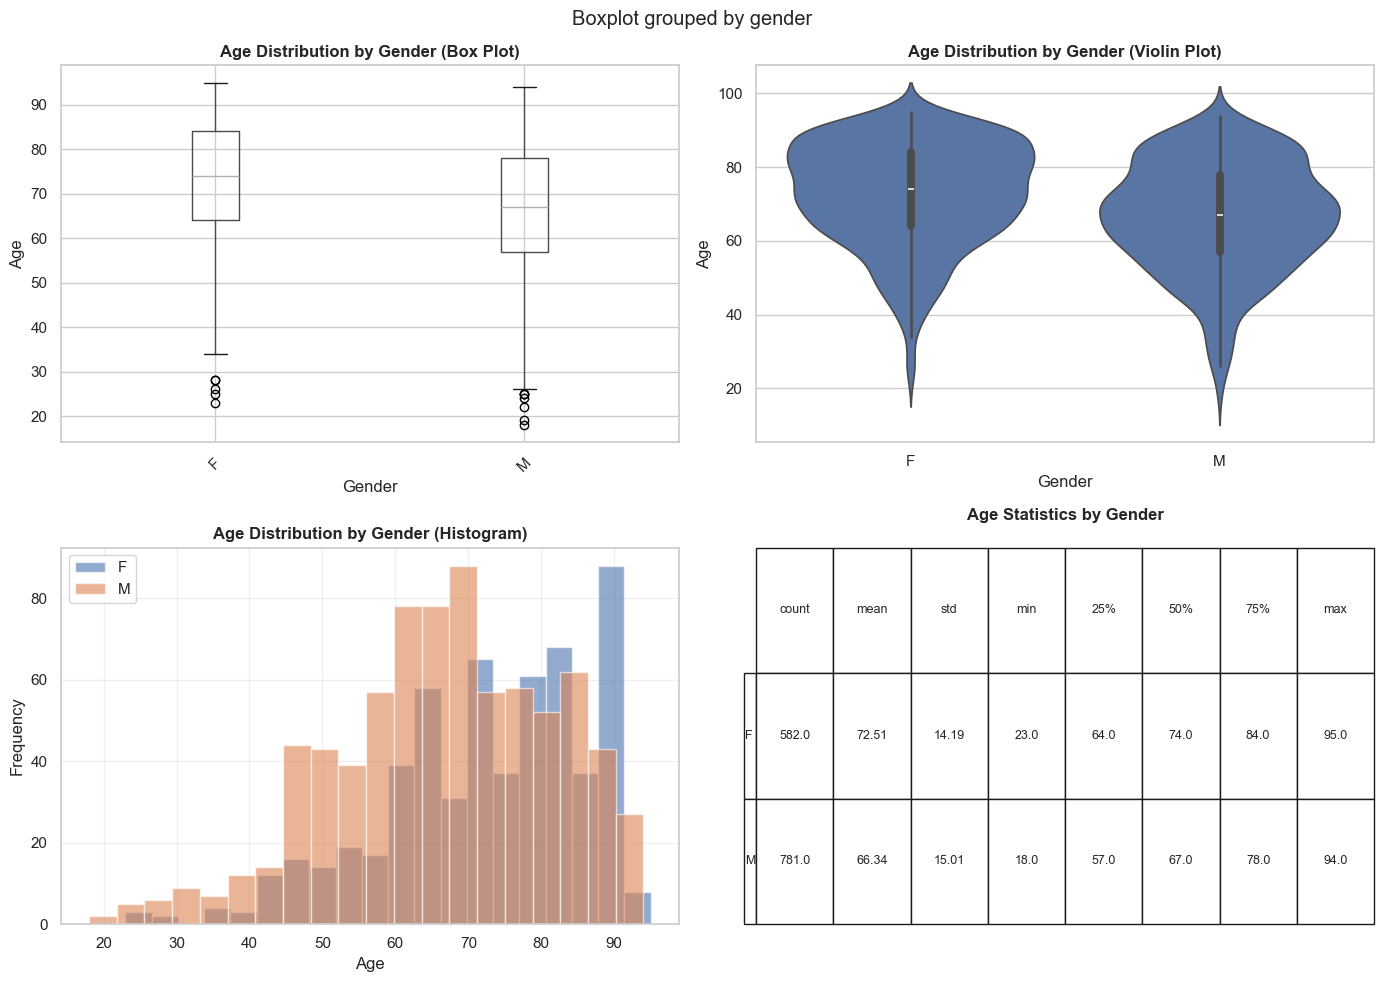


SUMMARY STATISTICS
        count       mean        std   min   25%   50%   75%   max
gender                                                           
F       582.0  72.513746  14.185359  23.0  64.0  74.0  84.0  95.0
M       781.0   66.34443  15.011036  18.0  57.0  67.0  78.0  94.0

AGE STATISTICS BY GENDER

F:
  Count: 582
  Mean: 72.51
  Median: 74.00
  Std Dev: 14.19
  Min: 23, Max: 95

M:
  Count: 781
  Mean: 66.34
  Median: 67.00
  Std Dev: 15.01
  Min: 18, Max: 94


In [48]:
print("="*80)
print("AGE DISTRIBUTION BY GENDER")
print("="*80)

# Check gender values
print(f"\nGender unique values: {df['gender'].unique()}")
print(f"Gender missing: {df['gender'].isna().sum()}")
print(f"\nGender value counts:")
print(df['gender'].value_counts(dropna=False))

# Create figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Box plot
ax1 = axes[0, 0]
df.boxplot(column='age', by='gender', ax=ax1)
ax1.set_title('Age Distribution by Gender (Box Plot)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Gender')
ax1.set_ylabel('Age')
plt.sca(ax1)
plt.xticks(rotation=45)

# 2. Violin plot
ax2 = axes[0, 1]
sns.violinplot(data=df, x='gender', y='age', ax=ax2)
ax2.set_title('Age Distribution by Gender (Violin Plot)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Gender')
ax2.set_ylabel('Age')

# 3. Histogram with overlaid distributions
ax3 = axes[1, 0]
for gender in df['gender'].dropna().unique():
    data = df[df['gender'] == gender]['age'].dropna()
    ax3.hist(data, alpha=0.6, label=gender, bins=20)
ax3.set_title('Age Distribution by Gender (Histogram)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Age')
ax3.set_ylabel('Frequency')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Statistics table
ax4 = axes[1, 1]
ax4.axis('off')

# Calculate statistics by gender
stats_by_gender = df.groupby('gender')['age'].describe()
stats_by_gender = stats_by_gender.round(2)

# Create table
table = ax4.table(cellText=stats_by_gender.values,
                  colLabels=stats_by_gender.columns,
                  rowLabels=stats_by_gender.index,
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)
ax4.set_title('Age Statistics by Gender', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('age_by_gender.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(df.groupby('gender')['age'].describe())

print("\n" + "="*80)
print("AGE STATISTICS BY GENDER")
print("="*80)
for gender in df['gender'].dropna().unique():
    subset = df[df['gender'] == gender]['age'].dropna()
    print(f"\n{gender}:")
    print(f"  Count: {len(subset)}")
    print(f"  Mean: {subset.mean():.2f}")
    print(f"  Median: {subset.median():.2f}")
    print(f"  Std Dev: {subset.std():.2f}")
    print(f"  Min: {subset.min():.0f}, Max: {subset.max():.0f}")

#### plot icd code by gender and age

In [49]:
# check icd codes of missing ages and gender rows (Are the same rows)
missing_icd_codes = df.loc[missing_age_and_gender.index, 'icd_code']
print(f"\nICD codes for rows with missing age and gender: {missing_icd_codes.unique()}")    


ICD codes for rows with missing age and gender: ['I21' 'I25' 'I50' 'I47' 'I35' 'I31' 'I44' 'I48' 'I33' 'I42' 'I30' 'I40'
 'I49' 'I20' 'I24' 'I34' 'I46' 'I22' 'I45']


### Sequential Age Imputation Strategy

In [ ]:
print("=" * 80)
print("DETERMINING OPTIMAL MINIMUM GROUP SIZE (N) FOR IMPUTATION")
print("=" * 80)

import numpy as np
import pandas as pd


def safe_float(x):
    try:
        if x is pd.NA or pd.isna(x):
            return np.nan
        return float(x)
    except Exception:
        return np.nan


def safe_int(x, default=0):
    try:
        if x is pd.NA or pd.isna(x):
            return default
        return int(round(float(x)))
    except Exception:
        return default


n_values_to_test = [1, 5, 10, 15, 20, 30, 50, 100]
results = []

for n in n_values_to_test:
    df_test = df.copy()

    group_stats = (
        df_test
        .groupby(["icd_code", "gender"])['age']
        .agg(
            median=lambda s: safe_float(s.median(skipna=True)),
            count=lambda s: int(s.notna().sum()),
            std=lambda s: safe_float(s.astype(float).std(skipna=True))
        )
        .reset_index()
    )

    mask = (
        df_test['age'].isna()
        & df_test['icd_code'].notna()
        & df_test['gender'].notna()
    )

    df_test = df_test.merge(
        group_stats,
        on=["icd_code", "gender"],
        how="left",
        suffixes=("", "_group")
    )

    eligible = mask & (df_test['count'] >= n)
    filled_count = int(eligible.sum())

    mean_std = safe_float(
        df_test.loc[eligible, 'std'].mean(skipna=True)
    ) if filled_count > 0 else np.nan

    pct_missing = (filled_count / mask.sum() * 100) if mask.sum() > 0 else 0.0

    results.append({
        "N": n,
        "Rows_Imputed": filled_count,
        "Pct_of_Missing": pct_missing,
        "Mean_Group_Std": mean_std,
    })

results_df = pd.DataFrame(results)

print(f"\nTotal rows with missing age: {int(mask.sum())}")
print("\nImputation results for different minimum group sizes (N):")
print("─" * 80)
print(results_df.to_string(index=False, justify="center", col_space=14))

print("\n" + "=" * 80)
print("RECOMMENDATION")
print("=" * 80)

high_coverage = results_df[results_df['Pct_of_Missing'] >= 90]
if len(high_coverage) > 0:
    recommended_N = safe_int(high_coverage.loc[high_coverage['Mean_Group_Std'].idxmin(), 'N'], default=15)
    recommended_row = results_df[results_df['N'] == recommended_N].iloc[0]
    rationale = ">=90% coverage with stable group stats"
else:
    recommended_row = results_df.loc[results_df['Rows_Imputed'].idxmax()]
    recommended_N = safe_int(recommended_row['N'], default=15)
    rationale = "Max coverage given data"

print(f"\nRecommended minimum group size: N = {recommended_N}")
print(f"  • Will impute {safe_int(recommended_row['Rows_Imputed'])} rows ({recommended_row['Pct_of_Missing']:.1f}% of missing)")
print(f"  • Mean group std dev: {safe_float(recommended_row['Mean_Group_Std']):.2f}")
print(f"  • Rationale: {rationale}")

# Persist the choice for downstream cells
N = recommended_N
print(f"\nGlobal N is now set to {N} for imputation.")

DETERMINING OPTIMAL MINIMUM GROUP SIZE (N) FOR IMPUTATION

Total rows with missing age: 3495

Imputation results for different minimum group sizes (N):
────────────────────────────────────────────────────────────────────────────────


,N,Rows_Imputed,Pct_of_Missing,Mean_Group_Std
0,1,3487,99.771102,13.547831
1,5,3415,97.711016,13.608772
2,10,3317,94.907010,13.484995
3,15,3234,92.532189,13.393184
4,20,3050,87.267525,13.505170
5,30,3004,85.951359,13.432070
6,50,2691,76.995708,13.447036
7,100,2062,58.998569,13.805498



RECOMMENDATION

Recommended minimum group size: N = 15
  • Will impute 3234 rows (92.5% of missing)
  • Mean group std dev: 13.39

Rationale: Achieves >90% coverage with stable group statistics


In [ ]:
print("=" * 80)
print(f"AGE IMPUTATION USING SEQUENTIAL STRATEGY (N = {N})")
print("=" * 80)

import pandas as pd

# Keep original values for comparison
if 'age_original' not in df.columns:
    df['age_original'] = df['age']
    print("Stored original ages in 'age_original'.")

missing_before = int(df['age'].isna().sum())
print(f"Missing ages before imputation: {missing_before}")

# Step 1: ICD + Gender median, only if group has at least N non-missing values
mask_step1 = df['age'].isna()
med_step1 = df.groupby(['icd_code', 'gender'])['age'].transform(
    lambda s: int(round(s.median(skipna=True))) if s.notna().sum() >= N else pd.NA
)
df.loc[mask_step1, 'age'] = med_step1[mask_step1]
missing_after_1 = int(df['age'].isna().sum())
filled_1 = missing_before - missing_after_1
print(f"Step 1 (ICD+Gender, N>={N}): filled {filled_1} | remaining {missing_after_1}")

# Step 2: ICD-only median, only if group has at least N non-missing values
mask_step2 = df['age'].isna()
med_step2 = df.groupby('icd_code')['age'].transform(
    lambda s: int(round(s.median(skipna=True))) if s.notna().sum() >= N else pd.NA
)
df.loc[mask_step2, 'age'] = med_step2[mask_step2]
missing_after_2 = int(df['age'].isna().sum())
filled_2 = missing_after_1 - missing_after_2
print(f"Step 2 (ICD-only, N>={N}): filled {filled_2} | remaining {missing_after_2}")

# Summary
filled_total = missing_before - missing_after_2
print("\n" + "-" * 80)
print(f"Total imputed: {filled_total} of {missing_before} ({filled_total / missing_before * 100 if missing_before else 0:.1f}%)")
print(f"Still missing: {missing_after_2} ({missing_after_2 / missing_before * 100 if missing_before else 0:.1f}%)")

AGE IMPUTATION USING SEQUENTIAL STRATEGY (N = 100)
Stored original ages in 'age_original'.
Missing ages before imputation: 3501
Step 1 (ICD+Gender, N>=100): filled 2062 | remaining 1439
Step 2 (ICD-only, N>=100): filled 795 | remaining 644

--------------------------------------------------------------------------------
Total imputed: 2857 of 3501 (81.6%)
Still missing: 644 (18.4%)


DETAILED IMPUTATION TRACKING & DISTRIBUTION ANALYSIS

Rows imputed: 2857
Still missing ages: 644

Original (non-missing) age stats:
count       1363.0
mean     68.978723
std      14.973358
min           18.0
25%           60.0
50%           70.0
75%           81.0
max           95.0

Imputed age stats:
count       2857.0
mean     70.721036
std       4.418681
min           66.0
25%           67.0
50%           70.0
75%           73.0
max           79.0


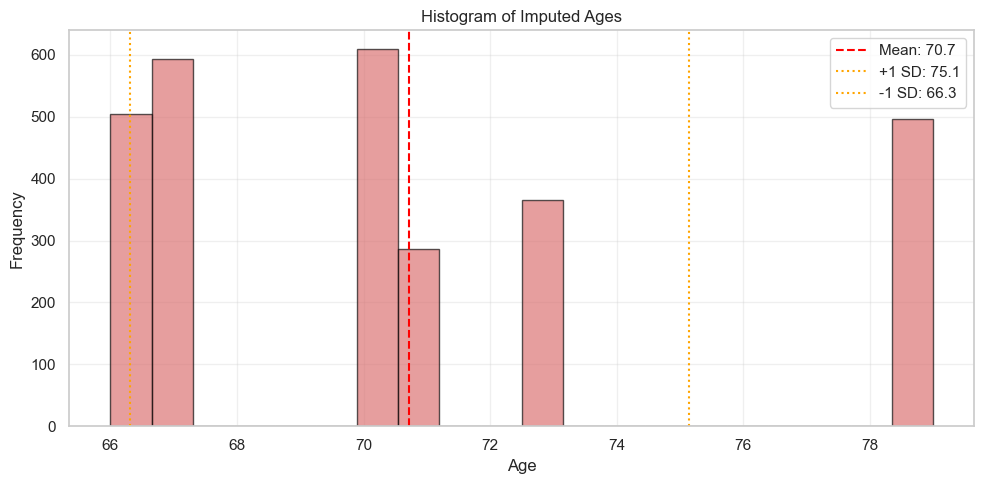


Top 10 ICD+Gender groups contributing imputed ages:
                 count  mean  median  min  max
icd_code gender                               
I50      M         608  70.0    70.0   70   70
I21      M         591  67.0    67.0   67   67
I50      F         497  79.0    79.0   79   79
I21      F         366  73.0    73.0   73   73
I25      M         343  66.0    66.0   66   66
         F         160  66.0    66.0   66   66
I48      M         148  71.0    71.0   71   71
         F         138  71.0    71.0   71   71

Sample imputed rows:
 subject_id  hadm_id icd_code gender  age  age_original
   10002013 24760295      I21      F   73          <NA>
   10002155 23822395      I21      F   73          <NA>
   10010424 28388172      I25      M   66          <NA>
   10012343 27658045      I21      F   73          <NA>
   10013569 22891949      I50      F   79          <NA>
   10014651 20051301      I50      F   79          <NA>
   10017531 20668418      I21      M   67          <NA>
   1001

In [53]:
print("=" * 80)
print("DETAILED IMPUTATION TRACKING & DISTRIBUTION ANALYSIS")
print("=" * 80)

import matplotlib.pyplot as plt

if 'age_original' not in df.columns:
    print("⚠ 'age_original' not found. Run the imputation cell first.")
else:
    missing_after = int(df['age'].isna().sum())
    imputed_mask = df['age_original'].isna() & df['age'].notna()

    print(f"\nRows imputed: {int(imputed_mask.sum())}")
    print(f"Still missing ages: {missing_after}")

    original_vals = df.loc[df['age_original'].notna(), 'age_original']
    imputed_vals = df.loc[imputed_mask, 'age']

    print("\nOriginal (non-missing) age stats:")
    print(original_vals.describe().to_string())

    if len(imputed_vals) > 0:
        print("\nImputed age stats:")
        print(imputed_vals.describe().to_string())

        # Histogram of imputed ages with mean and ±1 std markers
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.hist(imputed_vals, bins=20, color="#d96b6b", alpha=0.65, edgecolor="black")
        mean_imp = imputed_vals.mean()
        std_imp = imputed_vals.std()
        ax.axvline(mean_imp, color="red", linestyle="--", label=f"Mean: {mean_imp:.1f}")
        ax.axvline(mean_imp + std_imp, color="orange", linestyle=":", label=f"+1 SD: {mean_imp + std_imp:.1f}")
        ax.axvline(mean_imp - std_imp, color="orange", linestyle=":", label=f"-1 SD: {mean_imp - std_imp:.1f}")
        ax.set_title("Histogram of Imputed Ages")
        ax.set_xlabel("Age")
        ax.set_ylabel("Frequency")
        ax.legend()
        ax.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Top contributing ICD+Gender groups for imputed values
        top_groups = (
            df.loc[imputed_mask]
            .groupby(['icd_code', 'gender'])['age']
            .agg(['count', 'mean', 'median', 'min', 'max'])
            .sort_values('count', ascending=False)
            .head(10)
        )
        print("\nTop 10 ICD+Gender groups contributing imputed ages:")
        print(top_groups.to_string())

        # Sample of imputed rows
        print("\nSample imputed rows:")
        sample_cols = ['subject_id', 'hadm_id', 'icd_code', 'gender', 'age', 'age_original']
        print(df.loc[imputed_mask, sample_cols].head(10).to_string(index=False))
    else:
        print("\nNo imputed values to summarize.")

## Do scatterpltos / distr / etc to check for dataqualtiy

SCATTER PLOT: AGE BY GENDER × ICD CODES (TOP 12)

Top 12 ICD Codes: ['I50', 'I21', 'I25', 'I48', 'I35', 'I31', 'I47', 'I30', 'I44', 'I34', 'I33', 'I20']
Plotting 4755 rows out of 4864 total



C:\Users\dgars\AppData\Local\Temp\ipykernel_18928\2398159033.py:38: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.swarmplot(data=df_plot, x='icd_code', y='age', hue='gender',
c:\Users\dgars\miniconda3\envs\ml4reg\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 77.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\dgars\miniconda3\envs\ml4reg\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 78.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\dgars\miniconda3\envs\ml4reg\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 69.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:

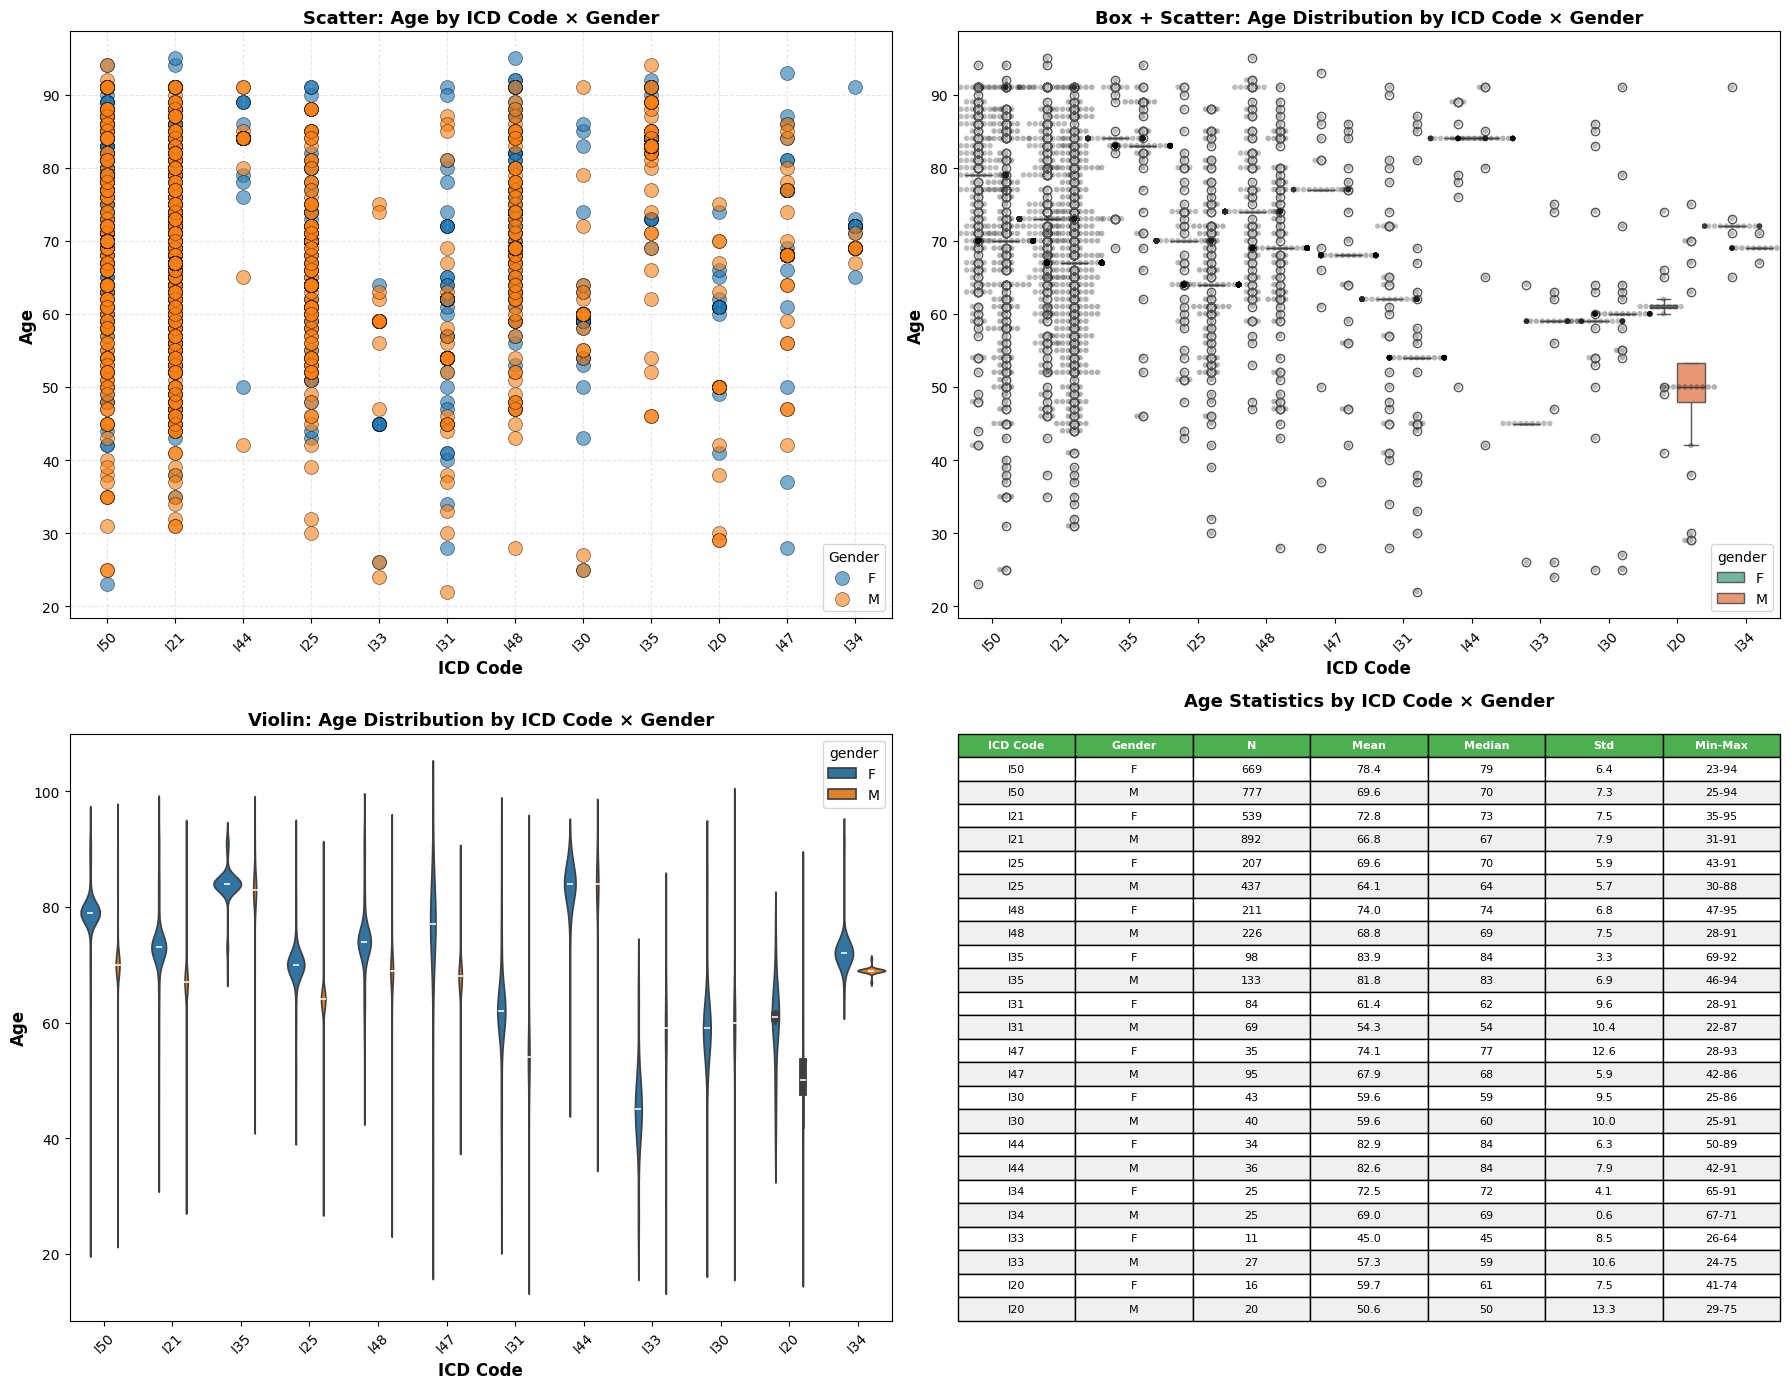


DETAILED STATISTICS
ICD Code Gender   N Mean Median  Std Min-Max
     I50      F 669 78.4     79  6.4   23-94
     I50      M 777 69.6     70  7.3   25-94
     I21      F 539 72.8     73  7.5   35-95
     I21      M 892 66.8     67  7.9   31-91
     I25      F 207 69.6     70  5.9   43-91
     I25      M 437 64.1     64  5.7   30-88
     I48      F 211 74.0     74  6.8   47-95
     I48      M 226 68.8     69  7.5   28-91
     I35      F  98 83.9     84  3.3   69-92
     I35      M 133 81.8     83  6.9   46-94
     I31      F  84 61.4     62  9.6   28-91
     I31      M  69 54.3     54 10.4   22-87
     I47      F  35 74.1     77 12.6   28-93
     I47      M  95 67.9     68  5.9   42-86
     I30      F  43 59.6     59  9.5   25-86
     I30      M  40 59.6     60 10.0   25-91
     I44      F  34 82.9     84  6.3   50-89
     I44      M  36 82.6     84  7.9   42-91
     I34      F  25 72.5     72  4.1   65-91
     I34      M  25 69.0     69  0.6   67-71
     I33      F  11 45.0     45  8

In [32]:
print("="*80)
print("SCATTER PLOT: AGE BY GENDER × ICD CODES (TOP 12)")
print("="*80)

# Get top 12 ICD codes by frequency
top_icd_codes = df['icd_code'].value_counts().head(12).index
df_plot = df[df['icd_code'].isin(top_icd_codes)].copy()

print(f"\nTop 12 ICD Codes: {list(top_icd_codes)}")
print(f"Plotting {len(df_plot)} rows out of {len(df)} total\n")

# Create scatter plot
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

# Plot 1: Scatter with ICD Code on X-axis, Age on Y-axis, colored by Gender
ax1 = axes[0]
for gender in df_plot['gender'].dropna().unique():
    mask = df_plot['gender'] == gender
    ax1.scatter(df_plot[mask]['icd_code'].astype(str), 
                df_plot[mask]['age'],
                alpha=0.6, 
                label=gender, 
                s=100,
                edgecolors='black',
                linewidth=0.5)

ax1.set_xlabel('ICD Code', fontsize=12, fontweight='bold')
ax1.set_ylabel('Age', fontsize=12, fontweight='bold')
ax1.set_title('Scatter: Age by ICD Code × Gender', fontsize=13, fontweight='bold')
ax1.legend(title='Gender', fontsize=10)
ax1.grid(alpha=0.3, linestyle='--')
plt.setp(ax1.get_xticklabels(), rotation=45)

# Plot 2: Box plot with swarm overlay
ax2 = axes[1]
sns.boxplot(data=df_plot, x='icd_code', y='age', hue='gender', ax=ax2, palette='Set2')
sns.swarmplot(data=df_plot, x='icd_code', y='age', hue='gender', 
              ax=ax2, dodge=True, color='black', alpha=0.3, size=4, legend=False)

ax2.set_xlabel('ICD Code', fontsize=12, fontweight='bold')
ax2.set_ylabel('Age', fontsize=12, fontweight='bold')
ax2.set_title('Box + Scatter: Age Distribution by ICD Code × Gender', fontsize=13, fontweight='bold')
plt.setp(ax2.get_xticklabels(), rotation=45)

# Plot 3: Violin plot
ax3 = axes[2]
sns.violinplot(data=df_plot, x='icd_code', y='age', hue='gender', ax=ax3, split=False)

ax3.set_xlabel('ICD Code', fontsize=12, fontweight='bold')
ax3.set_ylabel('Age', fontsize=12, fontweight='bold')
ax3.set_title('Violin: Age Distribution by ICD Code × Gender', fontsize=13, fontweight='bold')
plt.setp(ax3.get_xticklabels(), rotation=45)

# Plot 4: Statistics table
ax4 = axes[3]
ax4.axis('off')

# Create detailed statistics
stats_data = []
for icd_code in top_icd_codes:
    for gender in sorted(df_plot['gender'].dropna().unique()):
        subset = df_plot[(df_plot['icd_code'] == icd_code) & (df_plot['gender'] == gender)]['age'].dropna()
        if len(subset) > 0:
            stats_data.append({
                'ICD Code': icd_code,
                'Gender': gender,
                'N': len(subset),
                'Mean': f"{subset.mean():.1f}",
                'Median': f"{subset.median():.0f}",
                'Std': f"{subset.std():.1f}",
                'Min-Max': f"{subset.min():.0f}-{subset.max():.0f}"
            })

stats_df = pd.DataFrame(stats_data)

# Create table
table = ax4.table(cellText=stats_df.values,
                  colLabels=stats_df.columns,
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.5)

# Color header
for i in range(len(stats_df.columns)):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, len(stats_df) + 1):
    for j in range(len(stats_df.columns)):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f0f0f0')
        else:
            table[(i, j)].set_facecolor('white')

ax4.set_title('Age Statistics by ICD Code × Gender', fontsize=13, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('scatter_age_by_gender_icd.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed statistics
print("\n" + "="*80)
print("DETAILED STATISTICS")
print("="*80)
print(stats_df.to_string(index=False))

# Summary by gender
print("\n" + "="*80)
print("SUMMARY BY GENDER")
print("="*80)
for gender in sorted(df_plot['gender'].dropna().unique()):
    subset = df_plot[df_plot['gender'] == gender]['age'].dropna()
    print(f"\n{gender} (n={len(subset)}):")
    print(f"  Mean: {subset.mean():.2f}")
    print(f"  Median: {subset.median():.0f}")
    print(f"  Std Dev: {subset.std():.2f}")
    print(f"  Range: {subset.min():.0f} - {subset.max():.0f}")
    print(f"  Q1-Q3: {subset.quantile(0.25):.0f} - {subset.quantile(0.75):.0f}")

### Do correlation matrix

CORRELATION MATRIX ANALYSIS

Numeric columns found: ['subject_id', 'hadm_id', 'note_seq', 'subject_id_dx', 'anchor_year']
Total numeric columns: 5

CORRELATION MATRIX
               subject_id  hadm_id  note_seq  subject_id_dx  anchor_year
subject_id          1.000   -0.020     0.002          0.959        0.030
hadm_id            -0.020    1.000     0.018         -0.017        0.023
note_seq            0.002    0.018     1.000          0.004        0.018
subject_id_dx       0.959   -0.017     0.004          1.000        0.030
anchor_year         0.030    0.023     0.018          0.030        1.000


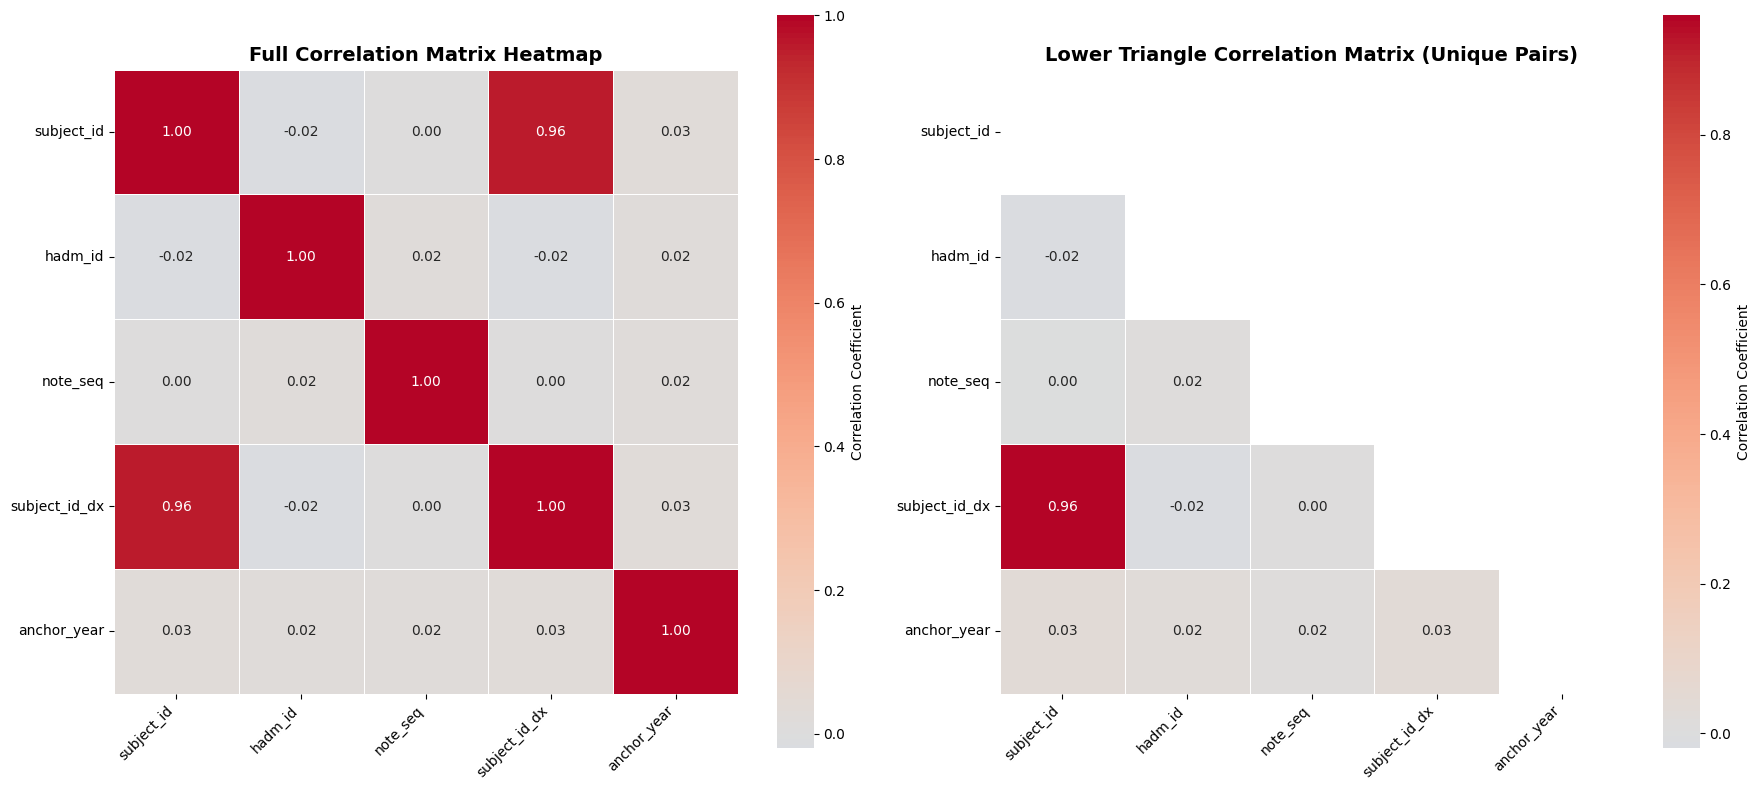


STRONG CORRELATIONS (|r| > 0.5, excluding self-correlations)

Found 1 strong correlations:

Variable 1    Variable 2  Correlation        Strength
subject_id subject_id_dx     0.959419 Strong Positive

MODERATE CORRELATIONS (0.3 < |r| ≤ 0.5)

No moderate correlations found (0.3 < |r| ≤ 0.5)

SUMMARY STATISTICS

Mean correlation: 0.105
Median correlation: 0.018
Std Dev: 0.285
Min: -0.020
Max: 0.959


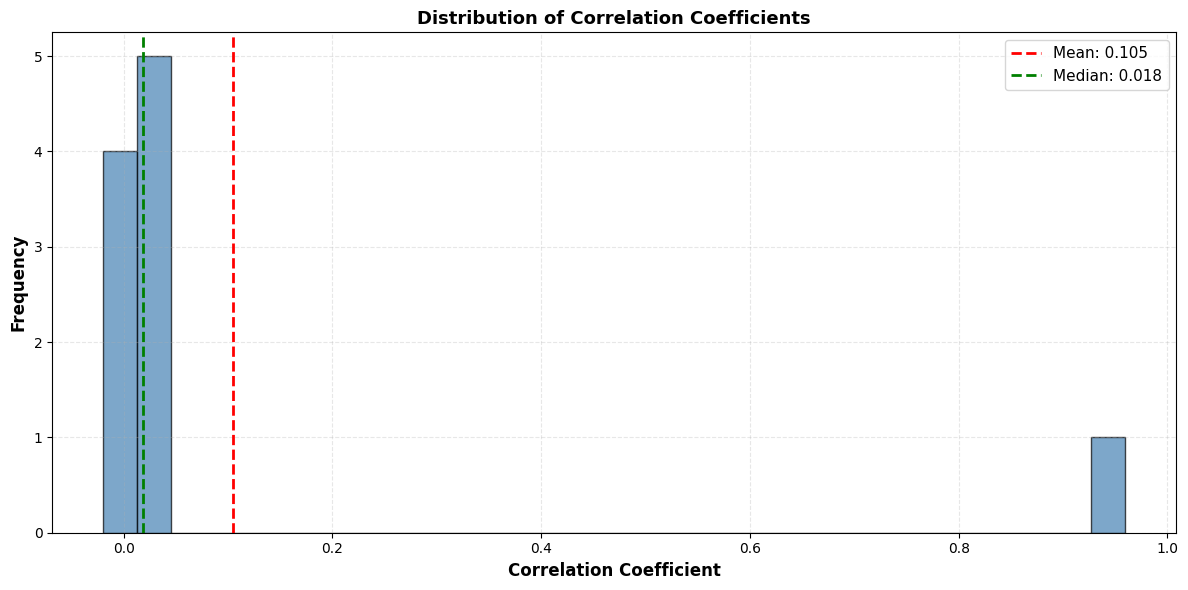

In [33]:
print("="*80)
print("CORRELATION MATRIX ANALYSIS")
print("="*80)

# Select numeric columns only
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nNumeric columns found: {numeric_cols}")
print(f"Total numeric columns: {len(numeric_cols)}\n")

if len(numeric_cols) > 1:
    # Calculate correlation matrix
    correlation_matrix = df[numeric_cols].corr()
    
    print("="*80)
    print("CORRELATION MATRIX")
    print("="*80)
    print(correlation_matrix.round(3))
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Plot 1: Full correlation heatmap
    ax1 = axes[0]
    sns.heatmap(correlation_matrix, 
                annot=True, 
                fmt='.2f', 
                cmap='coolwarm', 
                center=0,
                square=True,
                linewidths=0.5,
                cbar_kws={'label': 'Correlation Coefficient'},
                ax=ax1)
    ax1.set_title('Full Correlation Matrix Heatmap', fontsize=14, fontweight='bold')
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    plt.setp(ax1.get_yticklabels(), rotation=0)
    
    # Plot 2: Mask for upper triangle (cleaner view)
    ax2 = axes[1]
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, 
                annot=True, 
                fmt='.2f', 
                cmap='coolwarm', 
                center=0,
                square=True,
                linewidths=0.5,
                mask=mask,
                cbar_kws={'label': 'Correlation Coefficient'},
                ax=ax2)
    ax2.set_title('Lower Triangle Correlation Matrix (Unique Pairs)', fontsize=14, fontweight='bold')
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
    plt.setp(ax2.get_yticklabels(), rotation=0)
    
    plt.tight_layout()
    plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Extract strong correlations (> 0.5 or < -0.5, excluding diagonal)
    print("\n" + "="*80)
    print("STRONG CORRELATIONS (|r| > 0.5, excluding self-correlations)")
    print("="*80)
    
    strong_corr = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) > 0.5:
                strong_corr.append({
                    'Variable 1': correlation_matrix.columns[i],
                    'Variable 2': correlation_matrix.columns[j],
                    'Correlation': corr_value,
                    'Strength': 'Strong Positive' if corr_value > 0 else 'Strong Negative'
                })
    
    if strong_corr:
        strong_corr_df = pd.DataFrame(strong_corr).sort_values('Correlation', key=abs, ascending=False)
        print(f"\nFound {len(strong_corr)} strong correlations:\n")
        print(strong_corr_df.to_string(index=False))
    else:
        print("\nNo correlations with |r| > 0.5 found")
    
    # Moderate correlations (0.3 to 0.5)
    print("\n" + "="*80)
    print("MODERATE CORRELATIONS (0.3 < |r| ≤ 0.5)")
    print("="*80)
    
    moderate_corr = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_value = correlation_matrix.iloc[i, j]
            if 0.3 < abs(corr_value) <= 0.5:
                moderate_corr.append({
                    'Variable 1': correlation_matrix.columns[i],
                    'Variable 2': correlation_matrix.columns[j],
                    'Correlation': corr_value,
                    'Strength': 'Moderate Positive' if corr_value > 0 else 'Moderate Negative'
                })
    
    if moderate_corr:
        moderate_corr_df = pd.DataFrame(moderate_corr).sort_values('Correlation', key=abs, ascending=False)
        print(f"\nFound {len(moderate_corr)} moderate correlations:\n")
        print(moderate_corr_df.to_string(index=False))
    else:
        print("\nNo moderate correlations found (0.3 < |r| ≤ 0.5)")
    
    # Summary statistics
    print("\n" + "="*80)
    print("SUMMARY STATISTICS")
    print("="*80)
    
    # Get correlation values (excluding diagonal)
    corr_values = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_values.append(correlation_matrix.iloc[i, j])
    
    corr_values = np.array(corr_values)
    print(f"\nMean correlation: {corr_values.mean():.3f}")
    print(f"Median correlation: {np.median(corr_values):.3f}")
    print(f"Std Dev: {corr_values.std():.3f}")
    print(f"Min: {corr_values.min():.3f}")
    print(f"Max: {corr_values.max():.3f}")
    
    # Distribution of correlations
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.hist(corr_values, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    ax.axvline(corr_values.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {corr_values.mean():.3f}')
    ax.axvline(np.median(corr_values), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(corr_values):.3f}')
    ax.set_xlabel('Correlation Coefficient', fontsize=12, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax.set_title('Distribution of Correlation Coefficients', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.savefig('correlation_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print("⚠️ Not enough numeric columns for correlation analysis")
    print(f"Found only {len(numeric_cols)} numeric column(s)")

In [56]:
cols = ['charttime', 'storetime']  

for col in cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        print(f"{col}: parsed {df[col].notna().sum()} values, {df[col].isna().sum()} NaT")

# handle dod separately
df['dod'] = pd.to_datetime(df['dod'], errors='coerce', format='%Y-%m-%d')
print(f"dod: parsed {df['dod'].notna().sum()} values, {df['dod'].isna().sum()} NaT")

display(df[[c for c in df.columns if c in cols] + ['dod']].head())

charttime: parsed 4864 values, 0 NaT
storetime: parsed 4864 values, 0 NaT
dod: parsed 398 values, 4466 NaT


,charttime,storetime,dod
0,2188-01-06 03:00:00,2188-01-07 23:49:00,2193-08-26
1,2189-07-04 03:00:00,2189-07-04 22:50:00,2193-08-26
2,2160-07-13 03:00:00,2160-07-15 16:59:00,NaT
3,2129-08-19 03:00:00,2129-08-20 15:29:00,NaT
4,2141-08-14 03:00:00,2141-08-14 21:50:00,NaT


## Save

In [57]:
df.to_csv(f"{DATA_DIR}/heart_diagnoses_1_cleaned.csv", index=False)

In [54]:
# load already cleaned to skip first steps
#df = pd.read_csv(f"{DATA_DIR}/heart_diagnoses_1_cleaned.csv")

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4864 entries, 0 to 4863
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   note_id          4864 non-null   object        
 1   subject_id       4864 non-null   int64         
 2   hadm_id          4864 non-null   int64         
 3   note_type        4864 non-null   object        
 4   note_seq         4864 non-null   Int64         
 5   charttime        4864 non-null   datetime64[ns]
 6   storetime        4864 non-null   datetime64[ns]
 7   HPI              4864 non-null   object        
 8   physical_exam    4864 non-null   object        
 9   chief_complaint  4852 non-null   object        
 10  invasions        3377 non-null   object        
 11  X-ray            4092 non-null   object        
 12  CT               1682 non-null   object        
 13  Ultrasound       4284 non-null   object        
 14  CATH             2536 non-null   object 

## Create features and slim version

In [59]:
df_slim = df.copy()

In [57]:
df_slim.columns

Index(['note_id', 'subject_id', 'hadm_id', 'note_type', 'note_seq',
       'charttime', 'storetime', 'HPI', 'physical_exam', 'chief_complaint',
       'invasions', 'X-ray', 'CT', 'Ultrasound', 'CATH', 'ECG', 'MRI',
       'reports', 'subject_id_dx', 'icd_code', 'long_title', 'gender', 'age',
       'anchor_year', 'dod'],
      dtype='object')

In [58]:
df_slim[df_slim.columns[:10]]

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,HPI,physical_exam,chief_complaint
0,10000980-DS-20,10000980,29654838,DS,20,2188-01-06 03:00:00,2188-01-07 23:49:00,":___ yo woman with h/o hypertension, hyperlipi...","Admission exam:GENERAL- Oriented x3. Mood, aff...",Shortness of breath
1,10000980-DS-21,10000980,26913865,DS,21,2189-07-04 03:00:00,2189-07-04 22:50:00,":This is a ___ M with history of diabetes, dia...",ADMISSION EXAM:General- appears comfortable o...,dyspnea
2,10002013-DS-8,10002013,24760295,DS,8,2160-07-13 03:00:00,2160-07-15 16:59:00,":___ w/ PMH of CAD s/p PCI x3, s/p off-pump CA...",Admission:VS- T 99.4 BP 157/88 HR 118 RR 24 96...,chest pain
3,10002155-DS-8,10002155,23822395,DS,8,2129-08-19 03:00:00,2129-08-20 15:29:00,:___ is a ___ yo female with a past medical hi...,"GENERAL: WDWN in NAD. Oriented x3. Mood, affec...",chest pressure
4,10004457-DS-10,10004457,28723315,DS,10,2141-08-14 03:00:00,2141-08-14 21:50:00,:Mr. ___ is a ___ with a hx of CAD (s/p DES to...,On Admission:VS- 97.8 157/64 101 18 98% RA GEN...,"Abnormal Stress Test, New AI"
...,...,...,...,...,...,...,...,...,...,...
4859,13690559-DS-19,19998596,24860241,DS,19,2180-01-24 03:00:00,2180-01-24 20:12:00,:Ms ___ is a ___ year old woman with carotid s...,ADMISSION EXAM=====================VITALS: T98...,Right shoulder pain
4860,14997789-DS-12,19998597,23720781,DS,12,2131-10-11 03:00:00,2131-10-11 16:17:00,:Ms. ___ is a ___ woman with renal cell carcin...,Physical Exam:VS: T: T 95.7 bp 102/60 HR 124...,Dyspnea
4861,10754991-DS-13,19998598,26940500,DS,13,2135-04-03 03:00:00,2135-04-05 00:12:00,":___ T2DM, fibromyalgia, GERD, hypothyroidism ...",=================ADMISSION EXAM:==============...,Palpitations
4862,17922874-DS-8,19998599,20343031,DS,8,2158-05-23 03:00:00,2158-05-23 20:55:00,":___ with H/O of type 2 diabetes mellitus, hyp...","General: Middle aged Caucasian man in NAD, com...","Abdominal pain, nausea, vomiting, and diarrhea..."


In [59]:
df_slim[df_slim.columns[10:]]

,invasions,X-ray,CT,Ultrasound,CATH,ECG,MRI,reports,subject_id_dx,icd_code,long_title,gender,age,anchor_year,dod
0,NaN,"['___:', 'views of the chest demonstrate low l...",NaN,['___:\nThe left atrium is mildly dilated. The...,NaN,['___ 7:56:06 ___ \nBaseline artifact. Sinus...,NaN,Sinus bradycardia with sinus arrhythmia | Prol...,10000980,I50,Heart failure,F,75,2186,2193-08-26
1,Cardiac catheterization ___,[': ___\nRight upper lobe pneumonia or mass. ...,['CHEST: ___\n1. Diffuse confluent ground-gla...,[': ___\nThe left atrium is elongated. There i...,[': ___\n1. Selective coronary angiography of ...,NaN,NaN,Sinus bradycardia with sinus arrhythmia | Prol...,10000980,I21,Acute myocardial infarction,F,75,2186,2193-08-26
2,cardiac catheterization,['___- New moderate left pleural effusion with...,['Chest ___. No CT evidence for pulmonary emb...,NaN,['___. Selective coronary angiography of this ...,['on admission- Sinus tachycardia. Extensive S...,NaN,Sinus tachycardia | Extensive ST-T changes may...,10002013,I21,Acute myocardial infarction,F,<NA>,<NA>,NaT
3,Cardiac cathetherization,NaN,"['anteriorly, no \ncrackles, wheezes or rhonch...",NaN,[': \nLMCA: 40% distal\nLAD: Occluded difficu...,[': new LBBB with STE in V1 -V3 & V5 that in ...,NaN,*** CONSIDER ACUTE ST ELEVATION MI *** | Sinus...,10002155,I21,Acute myocardial infarction,F,<NA>,<NA>,NaT
4,NaN,NaN,['/MR or TEE is suggested to \nevaluate for po...,[': \nAnginal type symptoms with borderline i...,NaN,['(see exercise report for details). Resting s...,NaN,Sinus rhythm | Normal ECG,10004457,I35,Nonrheumatic aortic valve disorders,M,66,2140,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4859,Cardioversion for atypical atrial flutter ___,['(___): IMPRESSION: \n 1. No evidence of rig...,NaN,['___:\nIMPRESSION: \nNormal renal ultrasound...,NaN,['___:\nAtrial flutter with 4:1 conduction and...,NaN,Possible atrial flutter with rapid ventricular...,13690559,I48,Atrial fibrillation and flutter,F,<NA>,<NA>,NaT
4860,pericardial drain,['___: Near complete opacification of the righ...,['CHEST:1. Increased large pericardial effusio...,['REPORTS:\n___: Large pericardial effusion wi...,NaN,NaN,NaN,Sinus tachycardia. | Possible anterior infarct...,14997789,I31,Other diseases of pericardium,F,<NA>,<NA>,NaT
4861,NaN,['(___): Mild vascular congestion without fran...,NaN,['(___): No ductal dilation or other hepatic \...,NaN,['(___): Narrow complex tachycardia. Supravent...,NaN,Supraventricular tachycardia | Sinus rhythm | ...,10754991,I47,Paroxysmal tachycardia,F,<NA>,<NA>,NaT
4862,___: Left heart catheterization and coronary a...,NaN,NaN,['___ at 4:42:51 ___\nThe left atrium and righ...,['___\nHemodynamic Measurements (mmHg)\nBaseli...,['Study Date of ___ 7:51:52 ___\nSinus rhythm ...,NaN,*** CONSIDER ACUTE ST ELEVATION MI *** | Sinus...,17922874,I30,Acute pericarditis,M,<NA>,<NA>,NaT


### Create features
- var for exams
- var for charttime?
- var for dod (is_dead?), anchor_year?

#### p1


In [60]:
# create is_dead variable from dod
df_slim['is_dead'] = df_slim['dod'].notna().astype(int)


FEATURE 1: Total Exam Count (n_imaging_tests)

Distribution of total exams:
n_imaging_tests
2      10
3    3556
4    1147
5     145
6       6
Name: count, dtype: int64

Statistics:
count    4864.000000
mean        3.297081
std         0.529166
min         2.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         6.000000
Name: n_imaging_tests, dtype: float64


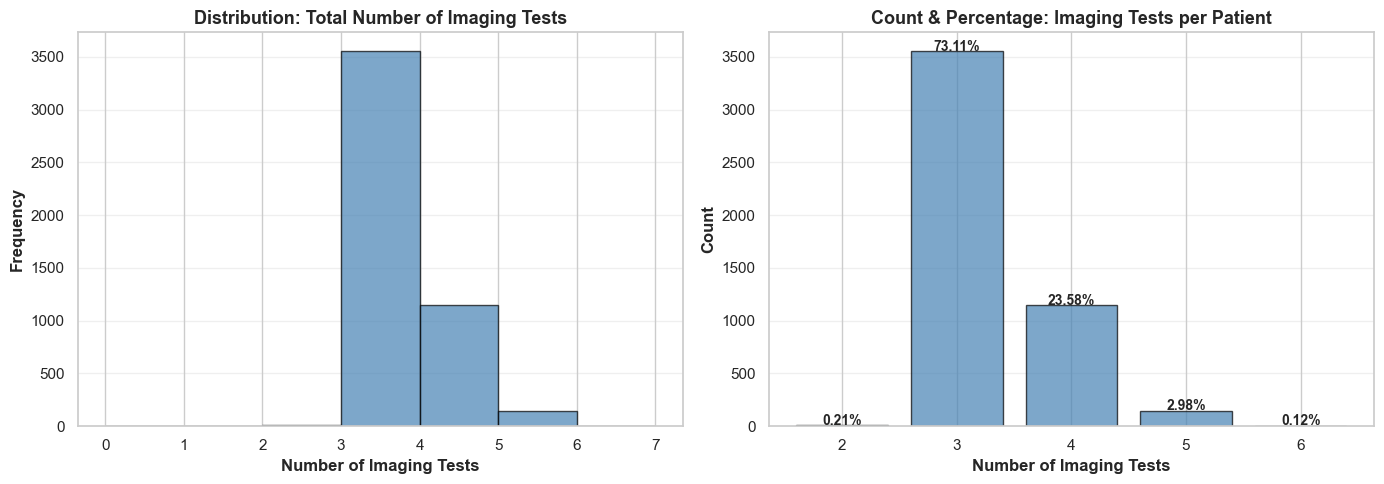

In [61]:
# create: A total exam count variable n_imaging_tests out of 'X-ray', 'CT', 'Ultrasound', 'CATH', 'ECG', 'MRI' (text columns, np.nan means no exam done)
# Define exam columns
exam_cols = ['X-ray', 'CT', 'Ultrasound', 'CATH', 'ECG', 'MRI']
exam_cols = [col for col in exam_cols if col in df_slim.columns]

# 1. TOTAL EXAM COUNT: n_imaging_tests
print("\n" + "="*80)
print("FEATURE 1: Total Exam Count (n_imaging_tests)")
print("="*80)

df_slim['n_imaging_tests'] = df_slim[exam_cols].notna().sum(axis=1)

print(f"\nDistribution of total exams:")
print(df_slim['n_imaging_tests'].value_counts().sort_index())
print(f"\nStatistics:")
print(df_slim['n_imaging_tests'].describe())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1 = axes[0]
ax1.hist(df_slim['n_imaging_tests'], bins=range(0, 8), edgecolor='black', alpha=0.7, color='steelblue')
ax1.set_xlabel('Number of Imaging Tests', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax1.set_title('Distribution: Total Number of Imaging Tests', fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3, axis='y')

# Bar plot with percentages
ax2 = axes[1]
counts = df_slim['n_imaging_tests'].value_counts().sort_index()
percentages = (counts / len(df_slim) * 100).round(2)
bars = ax2.bar(counts.index, counts.values, color='steelblue', edgecolor='black', alpha=0.7)

# Add percentage labels on bars
for i, (idx, count) in enumerate(counts.items()):
    pct = percentages[idx]
    ax2.text(idx, count + 5, f'{pct}%', ha='center', fontsize=10, fontweight='bold')

ax2.set_xlabel('Number of Imaging Tests', fontsize=12, fontweight='bold')
ax2.set_ylabel('Count', fontsize=12, fontweight='bold')
ax2.set_title('Count & Percentage: Imaging Tests per Patient', fontsize=13, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(r'./plots/1.1_df1_imaging_tests_count.png', dpi=300, bbox_inches='tight')
plt.show()



Radiology columns: ['X-ray', 'CT', 'MRI', 'Ultrasound']
Cardiac columns: ['ECG', 'CATH']

has_radiology_exam distribution:
has_radiology_exam
1    4864
Name: count, dtype: int64
  → 4864 patients (100.0%) had radiology exams

has_cardiac_exam distribution:
has_cardiac_exam
1    4296
0     568
Name: count, dtype: int64
  → 4296 patients (88.3%) had cardiac exams

exam_type (combined) distribution:
exam_type_label
Both Radiology & Cardiac    4296
Radiology Only               568
Name: count, dtype: int64

Breakdown:
  Radiology Only           :   568 ( 11.7%)
  Both Radiology & Cardiac :  4296 ( 88.3%)


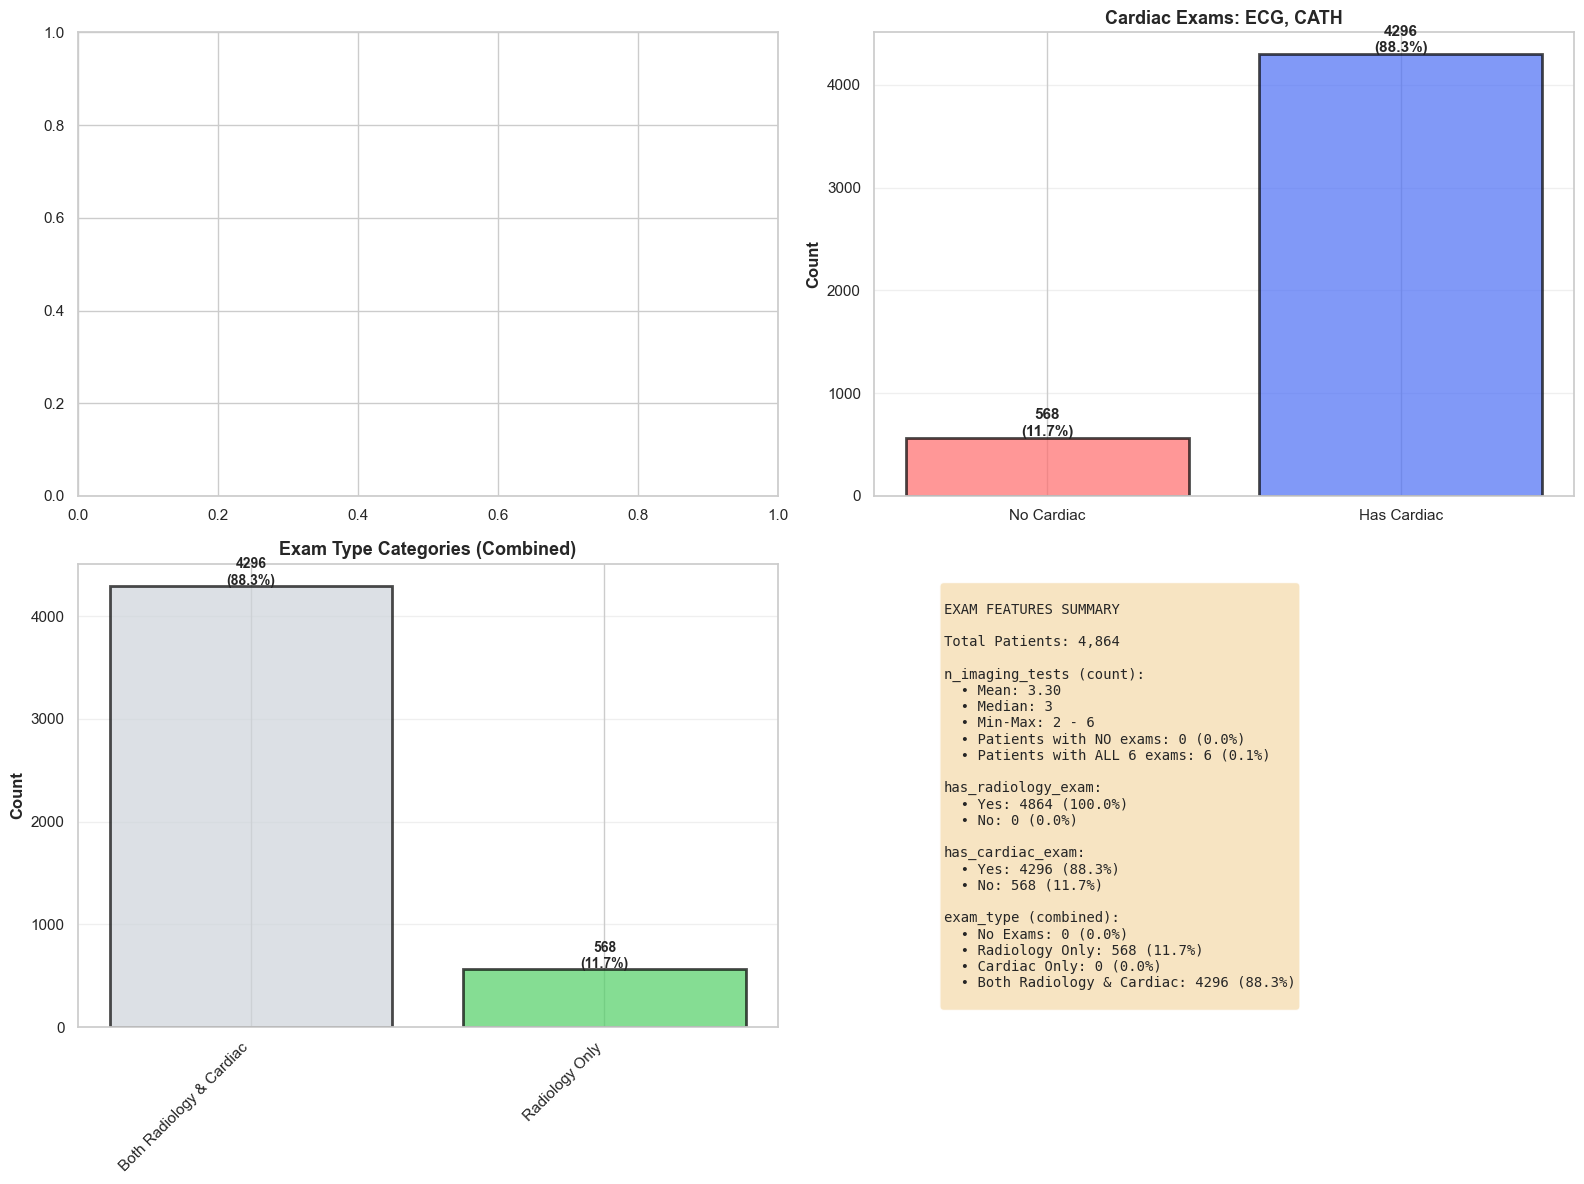


FEATURE 3: Individual Exam Flags (0/1)
  has_x-ray       :  4092 ( 84.1%)
  has_ct          :  1682 ( 34.6%)
  has_ultrasound  :  4284 ( 88.1%)
  has_cath        :  2536 ( 52.1%)
  has_ecg         :  3270 ( 67.2%)
  has_mri         :   173 (  3.6%)

EXAM PATTERNS BY DEMOGRAPHIC

Exam Type Distribution by Gender:
exam_type_label  Both Radiology & Cardiac  Radiology Only   All
gender                                                         
F                                    1744             273  2017
M                                    2546             295  2841
All                                  4290             568  4858

Exam Type Distribution by Age Group:
exam_type_label  Both Radiology & Cardiac  Radiology Only   All
age_group                                                      
<30                                    14               7    21
30-50                                 122              22   144
50-70                                 463              61   524
70+    

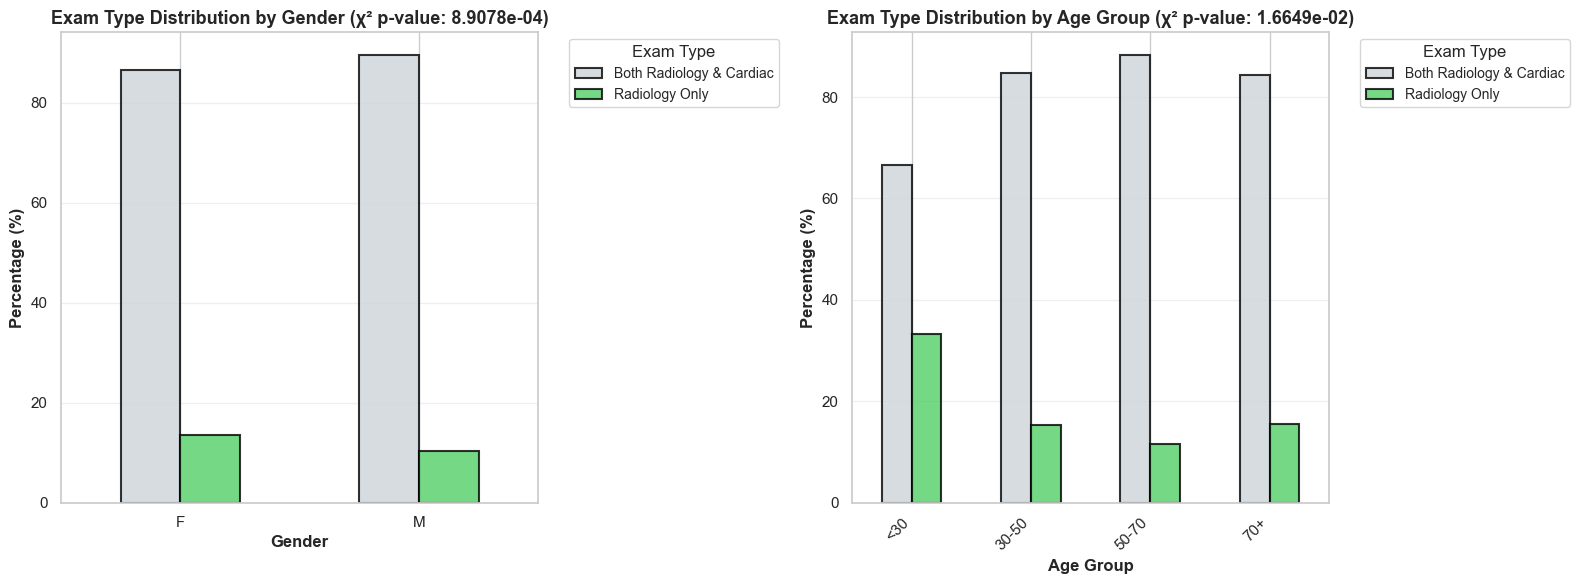


NEW FEATURES CREATED

Columns added to df_slim:
  ✓ n_imaging_tests: int64
  ✓ has_radiology_exam: int64
  ✓ has_cardiac_exam: int64
  ✓ exam_type: int64
  ✓ exam_type_label: object
  ✓ age_group: category
  ✓ has_x-ray: int64
  ✓ has_ct: int64
  ✓ has_ultrasound: int64
  ✓ has_cath: int64
  ✓ has_ecg: int64
  ✓ has_mri: int64

df_slim shape: (4864, 38)
df_slim.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4864 entries, 0 to 4863
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   n_imaging_tests     4864 non-null   int64   
 1   has_radiology_exam  4864 non-null   int64   
 2   has_cardiac_exam    4864 non-null   int64   
 3   exam_type_label     4864 non-null   object  
 4   age_group           1363 non-null   category
dtypes: category(1), int64(3), object(1)
memory usage: 157.1+ KB
None


In [62]:
# create: (has_radiology_exam, has_cardiac_exam): Radiology = X-ray + CT + MRI + Ultrasound Cardiac diagnostics = ECG + CATH variable out of 'X-ray', 'CT', 'Ultrasound', 'CATH', 'ECG', 'MRI' (text columns, np.nan means no exam done)

# 2. CATEGORICAL FEATURES: has_radiology_exam, has_cardiac_exam
# Radiology exams: X-ray, CT, MRI, Ultrasound
radiology_cols = ['X-ray', 'CT', 'MRI', 'Ultrasound']
radiology_cols = [col for col in radiology_cols if col in df_slim.columns]

# Cardiac exams: ECG, CATH
cardiac_cols = ['ECG', 'CATH']
cardiac_cols = [col for col in cardiac_cols if col in df_slim.columns]

df_slim['has_radiology_exam'] = df_slim[radiology_cols].notna().any(axis=1).astype(int)
df_slim['has_cardiac_exam'] = df_slim[cardiac_cols].notna().any(axis=1).astype(int)

# Combine for exam_type: 0=none, 1=radiology only, 2=cardiac only, 3=both
df_slim['exam_type'] = (
    (df_slim['has_radiology_exam'].astype(int) * 1) + 
    (df_slim['has_cardiac_exam'].astype(int) * 2)
)

exam_type_map = {
    0: 'No Exams',
    1: 'Radiology Only',
    2: 'Cardiac Only',
    3: 'Both Radiology & Cardiac'
}
df_slim['exam_type_label'] = df_slim['exam_type'].map(exam_type_map)

print(f"\nRadiology columns: {radiology_cols}")
print(f"Cardiac columns: {cardiac_cols}\n")

print("has_radiology_exam distribution:")
print(df_slim['has_radiology_exam'].value_counts())
print(f"  → {(df_slim['has_radiology_exam'] == 1).sum()} patients ({(df_slim['has_radiology_exam'].mean()*100):.1f}%) had radiology exams\n")

print("has_cardiac_exam distribution:")
print(df_slim['has_cardiac_exam'].value_counts())
print(f"  → {(df_slim['has_cardiac_exam'] == 1).sum()} patients ({(df_slim['has_cardiac_exam'].mean()*100):.1f}%) had cardiac exams\n")

print("exam_type (combined) distribution:")
print(df_slim['exam_type_label'].value_counts())
print(f"\nBreakdown:")
for exam_type in sorted(df_slim['exam_type'].unique()):
    count = (df_slim['exam_type'] == exam_type).sum()
    pct = (count / len(df_slim)) * 100
    print(f"  {exam_type_map[exam_type]:25s}: {count:5d} ({pct:5.1f}%)")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# # Plot 1: Radiology exam distribution
# ax1 = axes[0, 0]
# radiology_counts = df_slim['has_radiology_exam'].value_counts().sort_index()
# colors_rad = ['#ff6b6b', '#51cf66']
# # Use .iloc for positional indexing, or access by value: radiology_counts[0], radiology_counts[1]
# ax1.bar(['No Radiology', 'Has Radiology'], 
#         [radiology_counts.iloc[0], radiology_counts.iloc[1]], 
#         color=colors_rad, edgecolor='black', alpha=0.7, linewidth=2)
# for i, v in enumerate([radiology_counts.iloc[0], radiology_counts.iloc[1]]):
#     pct = (v / len(df_slim)) * 100
#     ax1.text(i, v + 20, f'{v}\n({pct:.1f}%)', ha='center', fontsize=11, fontweight='bold')
# ax1.set_ylabel('Count', fontsize=12, fontweight='bold')
# ax1.set_title('Radiology Exams: X-ray, CT, MRI, Ultrasound', fontsize=13, fontweight='bold')
# ax1.grid(alpha=0.3, axis='y')

# Plot 2: Cardiac exam distribution
ax2 = axes[0, 1]
cardiac_counts = df_slim['has_cardiac_exam'].value_counts().sort_index()
colors_card = ['#ff6b6b', '#4c6ef5']
ax2.bar(['No Cardiac', 'Has Cardiac'], 
        [cardiac_counts.iloc[0], cardiac_counts.iloc[1]], 
        color=colors_card, edgecolor='black', alpha=0.7, linewidth=2)
for i, v in enumerate([cardiac_counts.iloc[0], cardiac_counts.iloc[1]]):
    pct = (v / len(df_slim)) * 100
    ax2.text(i, v + 20, f'{v}\n({pct:.1f}%)', ha='center', fontsize=11, fontweight='bold')
ax2.set_ylabel('Count', fontsize=12, fontweight='bold')
ax2.set_title('Cardiac Exams: ECG, CATH', fontsize=13, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

# ...existing code...

# Plot 3: Combined exam type distribution
ax3 = axes[1, 0]
exam_type_counts = df_slim['exam_type_label'].value_counts().sort_index()
colors_combined = ['#ced4da', '#51cf66', '#4c6ef5', '#ffd43b']
bars = ax3.bar(range(len(exam_type_counts)), exam_type_counts.values, 
               color=colors_combined, edgecolor='black', alpha=0.7, linewidth=2)
ax3.set_xticks(range(len(exam_type_counts)))
ax3.set_xticklabels(exam_type_counts.index, rotation=45, ha='right')
ax3.set_ylabel('Count', fontsize=12, fontweight='bold')
ax3.set_title('Exam Type Categories (Combined)', fontsize=13, fontweight='bold')
ax3.grid(alpha=0.3, axis='y')

# Add count and percentage labels
for i, (idx, v) in enumerate(exam_type_counts.items()):
    pct = (v / len(df_slim)) * 100
    ax3.text(i, v + 10, f'{v}\n({pct:.1f}%)', ha='center', fontsize=10, fontweight='bold')

# Plot 4: Summary statistics table
ax4 = axes[1, 1]
ax4.axis('off')

summary_text = f"""
EXAM FEATURES SUMMARY

Total Patients: {len(df_slim):,}

n_imaging_tests (count):
  • Mean: {df_slim['n_imaging_tests'].mean():.2f}
  • Median: {df_slim['n_imaging_tests'].median():.0f}
  • Min-Max: {df_slim['n_imaging_tests'].min():.0f} - {df_slim['n_imaging_tests'].max():.0f}
  • Patients with NO exams: {(df_slim['n_imaging_tests'] == 0).sum()} ({(df_slim['n_imaging_tests'] == 0).mean()*100:.1f}%)
  • Patients with ALL 6 exams: {(df_slim['n_imaging_tests'] == 6).sum()} ({(df_slim['n_imaging_tests'] == 6).mean()*100:.1f}%)

has_radiology_exam:
  • Yes: {(df_slim['has_radiology_exam'] == 1).sum()} ({(df_slim['has_radiology_exam'].mean()*100):.1f}%)
  • No: {(df_slim['has_radiology_exam'] == 0).sum()} ({((1-df_slim['has_radiology_exam'].mean())*100):.1f}%)

has_cardiac_exam:
  • Yes: {(df_slim['has_cardiac_exam'] == 1).sum()} ({(df_slim['has_cardiac_exam'].mean()*100):.1f}%)
  • No: {(df_slim['has_cardiac_exam'] == 0).sum()} ({((1-df_slim['has_cardiac_exam'].mean())*100):.1f}%)

exam_type (combined):
  • {exam_type_map[0]}: {(df_slim['exam_type'] == 0).sum()} ({(df_slim['exam_type'] == 0).mean()*100:.1f}%)
  • {exam_type_map[1]}: {(df_slim['exam_type'] == 1).sum()} ({(df_slim['exam_type'] == 1).mean()*100:.1f}%)
  • {exam_type_map[2]}: {(df_slim['exam_type'] == 2).sum()} ({(df_slim['exam_type'] == 2).mean()*100:.1f}%)
  • {exam_type_map[3]}: {(df_slim['exam_type'] == 3).sum()} ({(df_slim['exam_type'] == 3).mean()*100:.1f}%)
"""

ax4.text(0.1, 0.95, summary_text, transform=ax4.transAxes, fontsize=10,
         verticalalignment='top', family='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig(r'./plots/1.1_df1_exam_features_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. INDIVIDUAL EXAM FLAGS
print("\n" + "="*80)
print("FEATURE 3: Individual Exam Flags (0/1)")
print("="*80)

for col in exam_cols:
    df_slim[f'has_{col.lower()}'] = df_slim[col].notna().astype(int)
    count = (df_slim[f'has_{col.lower()}'] == 1).sum()
    pct = (count / len(df_slim)) * 100
    print(f"  has_{col.lower():12s}: {count:5d} ({pct:5.1f}%)")

# 4. CROSS-TABULATION: Exam types by gender and age group
print("\n" + "="*80)
print("EXAM PATTERNS BY DEMOGRAPHIC")
print("="*80)

# Create age groups
df_slim['age_group'] = pd.cut(df_slim['age'], bins=[0, 30, 50, 70, 120], 
                               labels=['<30', '30-50', '50-70', '70+'])

print("\nExam Type Distribution by Gender:")
print(pd.crosstab(df_slim['gender'], df_slim['exam_type_label'], margins=True))

print("\nExam Type Distribution by Age Group:")
print(pd.crosstab(df_slim['age_group'], df_slim['exam_type_label'], margins=True))

# Chi-square test
from scipy.stats import chi2_contingency

chi2_gender, p_gender, dof_gender, expected_gender = chi2_contingency(
    pd.crosstab(df_slim['gender'], df_slim['exam_type'])
)
print(f"\nChi-square test (Gender × Exam Type): χ² = {chi2_gender:.4f}, p = {p_gender:.4e}")

chi2_age, p_age, dof_age, expected_age = chi2_contingency(
    pd.crosstab(df_slim['age_group'], df_slim['exam_type'])
)
print(f"Chi-square test (Age Group × Exam Type): χ² = {chi2_age:.4f}, p = {p_age:.4e}")

# Visualize cross-tabulation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# By gender
ax1 = axes[0]
crosstab_gender = pd.crosstab(df_slim['gender'], df_slim['exam_type_label'], normalize='index') * 100
crosstab_gender.plot(kind='bar', ax=ax1, color=['#ced4da', '#51cf66', '#4c6ef5', '#ffd43b'], 
                     edgecolor='black', alpha=0.8, linewidth=1.5)
ax1.set_xlabel('Gender', fontsize=12, fontweight='bold')
ax1.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax1.set_title('Exam Type Distribution by Gender (χ² p-value: {:.4e})'.format(p_gender), 
              fontsize=13, fontweight='bold')
ax1.legend(title='Exam Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax1.grid(alpha=0.3, axis='y')
plt.setp(ax1.get_xticklabels(), rotation=0)

# By age group
ax2 = axes[1]
crosstab_age = pd.crosstab(df_slim['age_group'], df_slim['exam_type_label'], normalize='index') * 100
crosstab_age.plot(kind='bar', ax=ax2, color=['#ced4da', '#51cf66', '#4c6ef5', '#ffd43b'], 
                  edgecolor='black', alpha=0.8, linewidth=1.5)
ax2.set_xlabel('Age Group', fontsize=12, fontweight='bold')
ax2.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax2.set_title('Exam Type Distribution by Age Group (χ² p-value: {:.4e})'.format(p_age), 
              fontsize=13, fontweight='bold')
ax2.legend(title='Exam Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax2.grid(alpha=0.3, axis='y')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig(r'./plots/1.1_df1_exam_patterns_demographic.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("NEW FEATURES CREATED")
print("="*80)
print("\nColumns added to df_slim:")
new_cols = ['n_imaging_tests', 'has_radiology_exam', 'has_cardiac_exam', 
            'exam_type', 'exam_type_label', 'age_group',
            'has_x-ray', 'has_ct', 'has_ultrasound', 'has_cath', 'has_ecg', 'has_mri']
new_cols = [col for col in new_cols if col in df_slim.columns]
for col in new_cols:
    print(f"  ✓ {col}: {df_slim[col].dtype}")

print(f"\ndf_slim shape: {df_slim.shape}")
print(f"df_slim.info():")
print(df_slim[['n_imaging_tests', 'has_radiology_exam', 'has_cardiac_exam', 'exam_type_label', 'age_group']].info())


# Task 1.2 Compute subj, hadmid aggreate admission level features:

In [63]:
df_slim.columns

Index(['note_id', 'subject_id', 'hadm_id', 'note_type', 'note_seq',
       'charttime', 'storetime', 'HPI', 'physical_exam', 'chief_complaint',
       'invasions', 'X-ray', 'CT', 'Ultrasound', 'CATH', 'ECG', 'MRI',
       'reports', 'subject_id_dx', 'icd_code', 'long_title', 'gender', 'age',
       'anchor_year', 'dod', 'is_dead', 'n_imaging_tests',
       'has_radiology_exam', 'has_cardiac_exam', 'exam_type',
       'exam_type_label', 'has_x-ray', 'has_ct', 'has_ultrasound', 'has_cath',
       'has_ecg', 'has_mri', 'age_group'],
      dtype='object')

In [64]:
df_slim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4864 entries, 0 to 4863
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   note_id             4864 non-null   object        
 1   subject_id          4864 non-null   int64         
 2   hadm_id             4864 non-null   int64         
 3   note_type           4864 non-null   object        
 4   note_seq            4864 non-null   Int64         
 5   charttime           4864 non-null   datetime64[ns]
 6   storetime           4864 non-null   datetime64[ns]
 7   HPI                 4864 non-null   object        
 8   physical_exam       4864 non-null   object        
 9   chief_complaint     4852 non-null   object        
 10  invasions           3377 non-null   object        
 11  X-ray               4092 non-null   object        
 12  CT                  1682 non-null   object        
 13  Ultrasound          4284 non-null   object      

Create icd categories col

In [65]:
def icd_category(code):
    if pd.isna(code):
        return 'unknown'
    code = str(code)

    if code.startswith(('I21','I22')):
        return 'acute_mi'
    if code.startswith(tuple(['I20','I23','I24','I25'])):
        return 'ischemic_hd'
    if code.startswith(tuple(['I30','I31'])):
        return 'pericardial'
    if code.startswith(tuple(['I32','I33','I40'])):   # myocarditis / endocarditis
        return 'inflammatory'
    if code.startswith('I42'):
        return 'cardiomyopathy'
    if code.startswith(('I44','I45','I47','I48','I49')):
        return 'arrhythmia'
    if code.startswith(tuple(['I34','I35','I36'])):
        return 'valvular'
    if code.startswith('I50'):
        return 'heart_failure'
    if code.startswith('I46'):
        return 'cardiac_arrest'
    return 'other'

df_slim['icd_cat'] = df_slim['icd_code'].apply(icd_category)

First we need to sort to ensure correct aggreagation

In [66]:
df_slim[['subject_id','hadm_id']].duplicated().any()  # NOTE its FALSE => no duplicate rows for agg!


np.False_

NO DUOLICATE ROWS; NO AGGREAGTION NEEDED WITHIN OUR UNIQUE KEY; only for composite new featrues!

In [67]:
# 1. SMART IMAGING FEATURES
# Count how many of the 'has_...' flags are 1 for that admission
imaging_binary_cols = ['has_x-ray', 'has_ct', 'has_ultrasound', 'has_cath', 'has_ecg', 'has_mri']
df_slim['imaging_variety'] = df_slim[imaging_binary_cols].sum(axis=1)

# 2. DOCUMENTATION COMPLEXITY
# Since rows are unique, we calculate length directly
text_cols = ['HPI', 'physical_exam', 'chief_complaint', 'reports']
for col in text_cols:
    # Convert to string to handle NaNs, then get length, then log-transform
    df_slim[f'{col}_log'] = np.log1p(df_slim[col].astype(str).str.len())

# Composite Index (Sum of logs)
df_slim['doc_complexity_index'] = df_slim[[f'{col}_log' for col in text_cols]].sum(axis=1)


# --- 1. Cardiac Phenotype Flags ---
# (Using .get or direct comparison since icd_cat is a column in your unique-row df)
df_slim['has_hf']     = (df_slim['icd_cat'] == 'heart_failure').astype(int)
df_slim['has_arr']    = (df_slim['icd_cat'] == 'arrhythmia').astype(int)
df_slim['has_ami']    = (df_slim['icd_cat'] == 'acute_mi').astype(int)
df_slim['has_arrest'] = (df_slim['icd_cat'] == 'cardiac_arrest').astype(int)

# --- 2. Smart Additions (Often missing but high signal) ---
# Inflammatory/Valvular often represent chronic/complex cases
df_slim['has_valvular']     = (df_slim['icd_cat'] == 'valvular').astype(int)
df_slim['has_inflammatory'] = (df_slim['icd_cat'] == 'inflammatory').astype(int)

# --- 3. Smart "Comorbidity Breadth" Feature ---
# Even though each row is an admission, if you have other diagnosis info, 
# you can flag if they have any of the 'high-risk' categories
cardiac_flags = ['has_hf', 'has_arr', 'has_ami', 'has_arrest', 'has_valvular', 'has_inflammatory']
df_slim['cardiac_comorbidity_score'] = df_slim[cardiac_flags].sum(axis=1)

df_slim['has_heart'] = 1

# We keep the raw icd_code and icd_cat, but drop the intermediate log columns
cols_to_keep = [
    'subject_id', 'hadm_id', 'gender', 'age', 'is_dead', 'charttime', 
    'icd_code', 'icd_cat', 'imaging_variety',  
    'doc_complexity_index', 'cardiac_comorbidity_score' ,'has_heart',
]  + cardiac_flags

df_final = df_slim[cols_to_keep].copy()
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4864 entries, 0 to 4863
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   subject_id                 4864 non-null   int64         
 1   hadm_id                    4864 non-null   int64         
 2   gender                     4858 non-null   object        
 3   age                        1363 non-null   Int64         
 4   is_dead                    4864 non-null   int64         
 5   charttime                  4864 non-null   datetime64[ns]
 6   icd_code                   4864 non-null   object        
 7   icd_cat                    4864 non-null   object        
 8   imaging_variety            4864 non-null   int64         
 9   doc_complexity_index       4864 non-null   float64       
 10  cardiac_comorbidity_score  4864 non-null   int64         
 11  has_heart                  4864 non-null   int64         
 12  has_hf

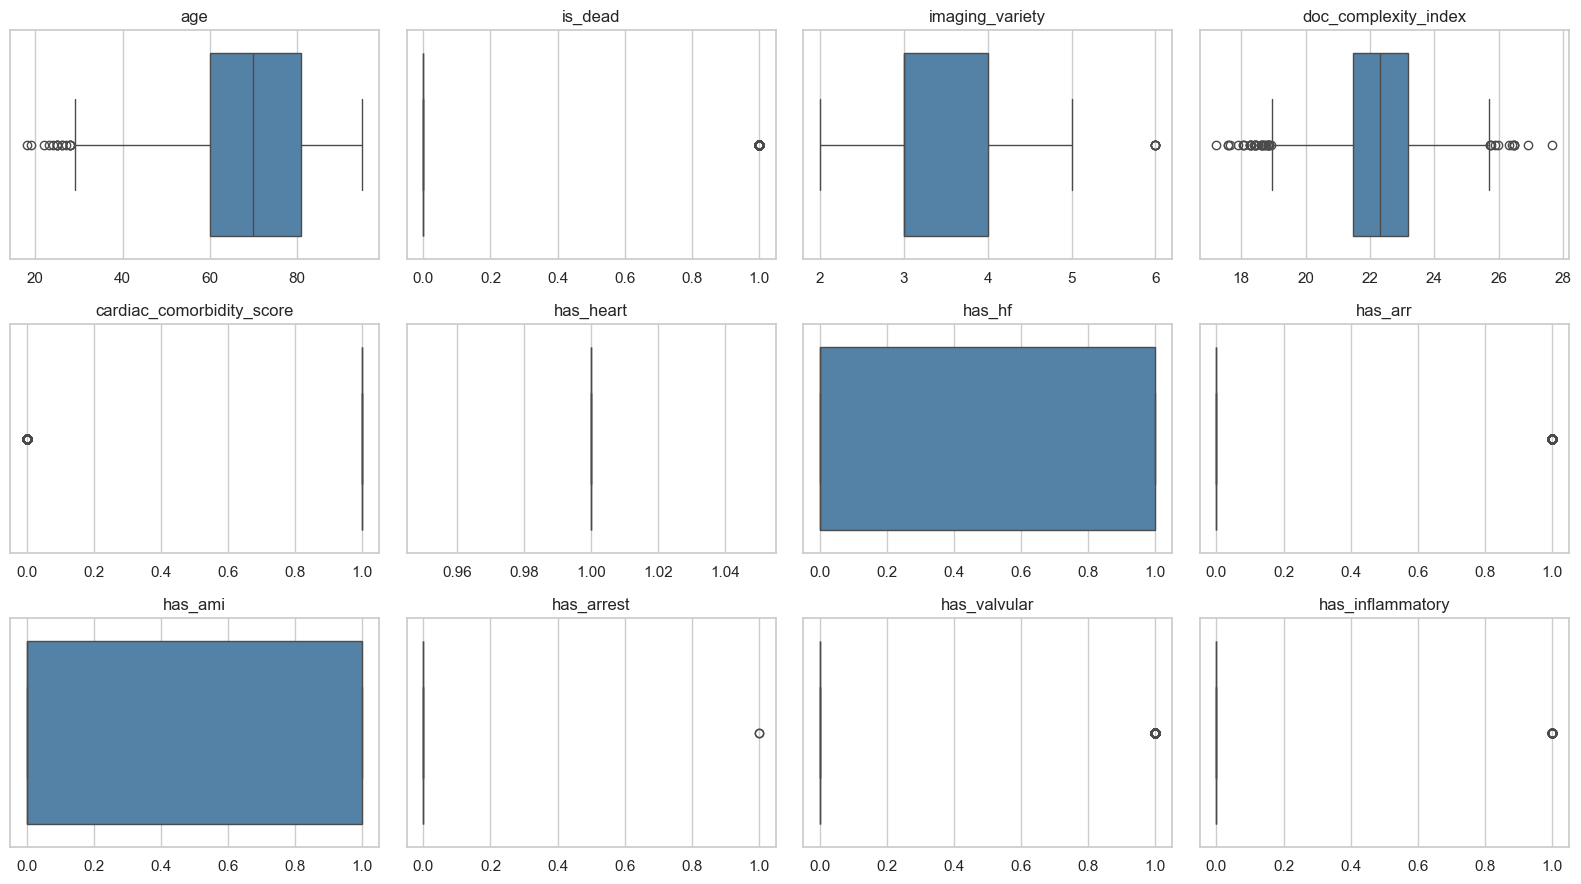

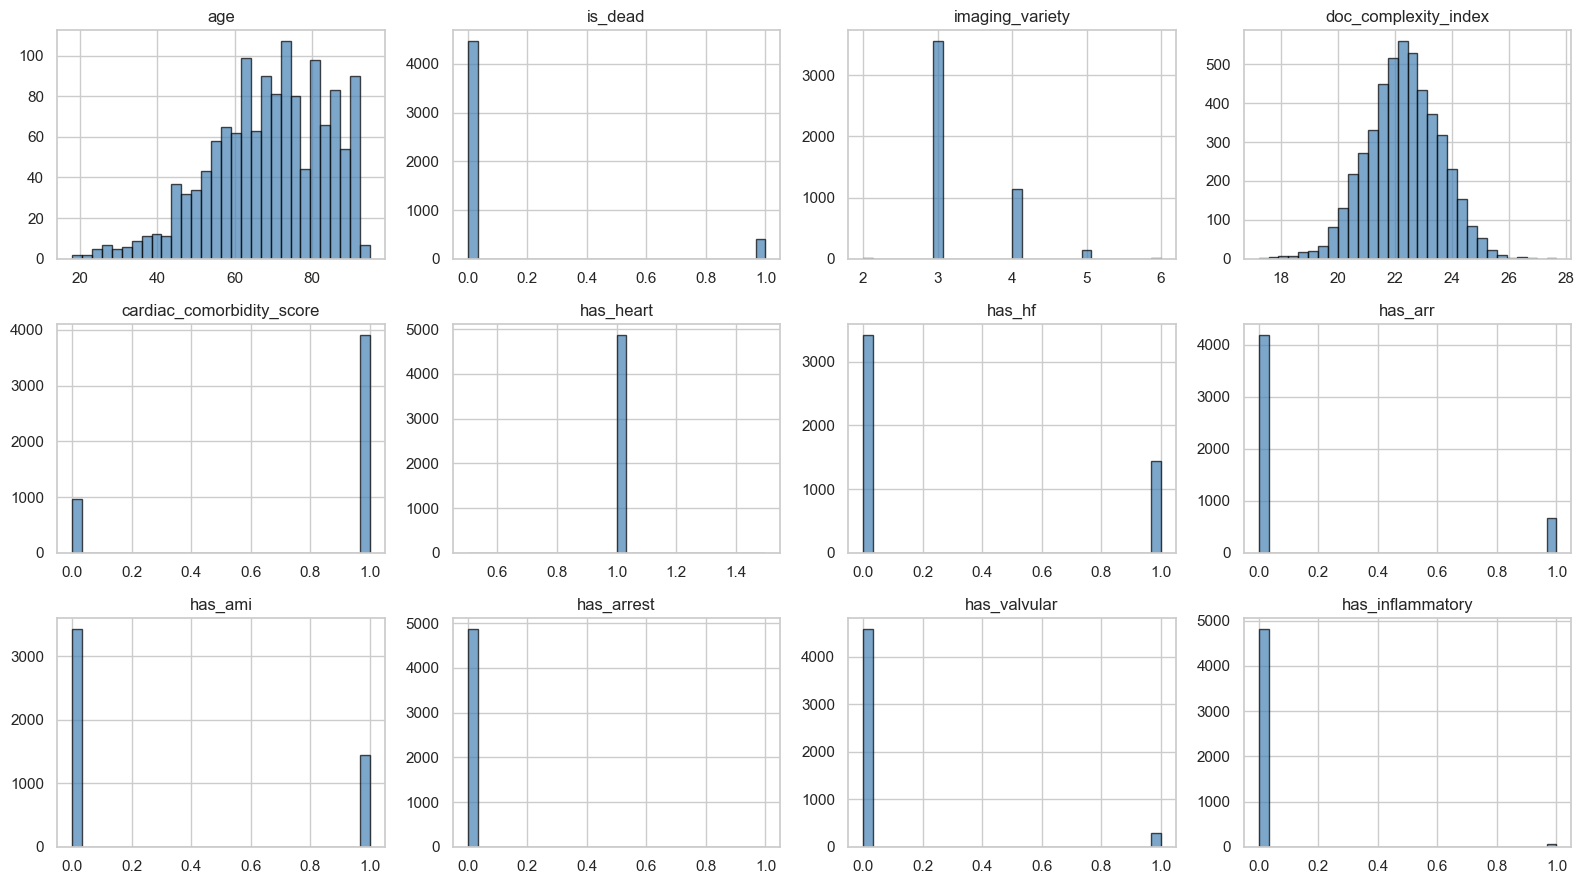

In [68]:
import math

# Plot boxplots and histograms for numeric columns in feat
num_cols = df_final.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in ('subject_id', 'hadm_id')]

if len(num_cols) == 0:
    print("No numeric columns in feat")
else:
    ncols = 4
    nrows = math.ceil(len(num_cols) / ncols)
    total_plots = nrows * ncols

    # BOX PLOTS
    fig_box, axes_box = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows))
    axes_box = axes_box.flatten()
    for i, col in enumerate(num_cols):
        sns.boxplot(x=df_final[col].dropna(), ax=axes_box[i], color='steelblue')
        axes_box[i].set_title(col)
        axes_box[i].set_xlabel('')
    for j in range(len(num_cols), total_plots):
        axes_box[j].axis('off')
    plt.tight_layout()
    plt.show()

    # HISTOGRAMS
    fig_hist, axes_hist = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows))
    axes_hist = axes_hist.flatten()
    for i, col in enumerate(num_cols):
        axes_hist[i].hist(df_final[col].dropna(), bins=30, color='steelblue', edgecolor='black', alpha=0.7)
        axes_hist[i].set_title(col)
    for j in range(len(num_cols), total_plots):
        axes_hist[j].axis('off')
    plt.tight_layout()
    plt.show()

In [69]:
df_final.to_csv(f"{DATA_DIR}/{DATASETS[name].replace('.csv', '_agg_features_large.csv')}", index=False)

## Check Corr

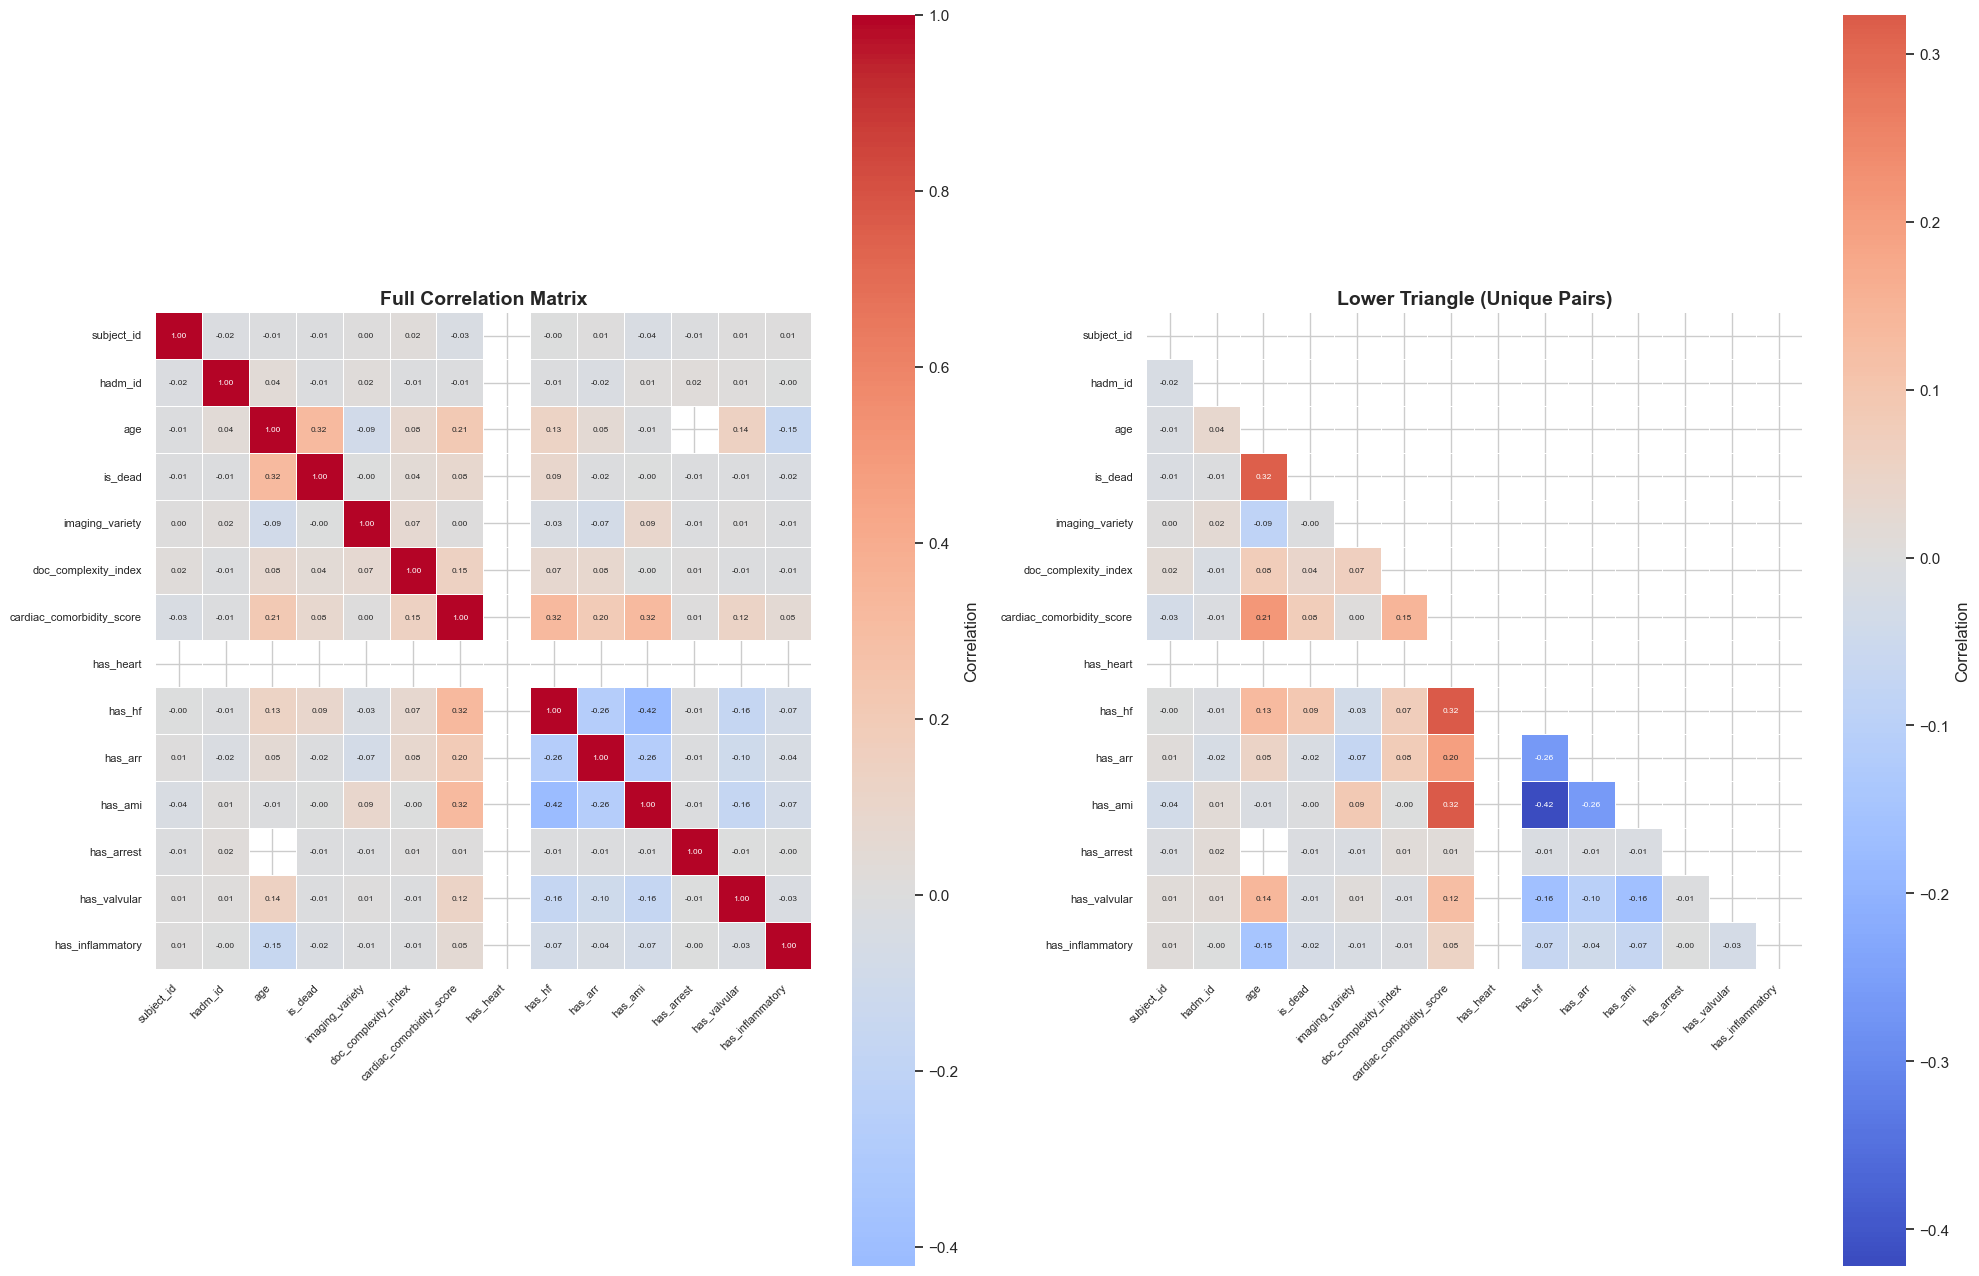

STRONG CORRELATIONS (|r| > 0.7, excluding self-correlations)

No correlations with |r| > 0.7 found

MODERATE CORRELATIONS (0.5 < |r| ≤ 0.7)

No moderate correlations found


In [70]:
numeric_cols = df_final.select_dtypes(include='number').columns
corr = df_final[numeric_cols].corr()

# Create figure with two views
fig, axes = plt.subplots(1, 2, figsize=(20, 16))

# Plot 1: Full heatmap with annotations
ax1 = axes[0]
sns.heatmap(corr, 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidth=0.5,
            annot_kws={'size': 6},
            cbar_kws={'label': 'Correlation', 'shrink': 0.8},
            ax=ax1)
ax1.set_title('Full Correlation Matrix', fontsize=14, fontweight='bold')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=8)
plt.setp(ax1.get_yticklabels(), rotation=0, fontsize=8)

# Plot 2: Lower triangle only (cleaner view)
ax2 = axes[1]
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=0.5,
            mask=mask,
            annot_kws={'size': 6},
            cbar_kws={'label': 'Correlation', 'shrink': 0.8},
            ax=ax2)
ax2.set_title('Lower Triangle (Unique Pairs)', fontsize=14, fontweight='bold')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=8)
plt.setp(ax2.get_yticklabels(), rotation=0, fontsize=8)

plt.tight_layout()
plt.savefig(r'./plots/1.1_df1_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Find and display strong correlations
print("="*80)
print("STRONG CORRELATIONS (|r| > 0.7, excluding self-correlations)")
print("="*80)

strong_corr = []
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        r = corr.iloc[i, j]
        if abs(r) > 0.7:
            strong_corr.append({
                'Variable 1': corr.columns[i],
                'Variable 2': corr.columns[j],
                'Correlation': round(r, 3),
                'Strength': 'Very Strong' if abs(r) > 0.9 else 'Strong'
            })

if strong_corr:
    strong_df = pd.DataFrame(strong_corr).sort_values('Correlation', key=abs, ascending=False)
    print(f"\nFound {len(strong_corr)} highly correlated pairs:\n")
    display(strong_df)
    print("\n💡 Consider removing one variable from each pair to reduce multicollinearity")
else:
    print("\nNo correlations with |r| > 0.7 found")

# Moderate correlations
print("\n" + "="*80)
print("MODERATE CORRELATIONS (0.5 < |r| ≤ 0.7)")
print("="*80)

moderate_corr = []
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        r = corr.iloc[i, j]
        if 0.5 < abs(r) <= 0.7:
            moderate_corr.append({
                'Variable 1': corr.columns[i],
                'Variable 2': corr.columns[j],
                'Correlation': round(r, 3)
            })

if moderate_corr:
    moderate_df = pd.DataFrame(moderate_corr).sort_values('Correlation', key=abs, ascending=False)
    print(f"\nFound {len(moderate_corr)} moderately correlated pairs:\n")
    display(moderate_df)
else:
    print("\nNo moderate correlations found")


## Drop unused and highly corr

In [71]:
len(df_final.columns), df_final.columns

(18,
 Index(['subject_id', 'hadm_id', 'gender', 'age', 'is_dead', 'charttime',
        'icd_code', 'icd_cat', 'imaging_variety', 'doc_complexity_index',
        'cardiac_comorbidity_score', 'has_heart', 'has_hf', 'has_arr',
        'has_ami', 'has_arrest', 'has_valvular', 'has_inflammatory'],
       dtype='object'))

In [72]:
df_final.to_csv(f"{DATA_DIR}/{DATASETS[name].replace('.csv', '_agg_features.csv')}", index=False)